<a id='introduction'></a>
# <p style="padding:15px;background-color:#fff798;margin:10px 0;color:#435672;font-family:'Arial',sans-serif;text-align:center;border-radius:15px 50px;overflow:hidden;font-weight:600">🇪🇺🏛️ European Citizens' Initiative: Commission Response</p>

<div align="center">
  <img src="LOGO CE_RGB_MUTE_POS.svg" alt="EU Commission Logo" height="200" style="display:inline-block; margin:10px;">
  <img src="1_2021_1-1.jpg" alt="ECI Material" height="200" style="display:inline-block; margin:10px;">
</div>

<p style="text-align:center;">
  <i>Source: European Citizens' Initiative | European Commission (CC BY 4.0)</i>
</p>

Examines Commission responses to [European Citizens' Initiative proposals](https://commission.europa.eu/get-involved/engage-eu-policymaking/european-citizens-initiative_en) that successfully met signature thresholds between 2012 and 2025. Once an ECI collects 1 million signatures from at least 7 member states, the Commission must provide a formal response within 6 months explaining whether it will propose new legislation. This dataset tracks 11 out of 16 ECIs that successfully met both signature criteria (1M+ signatures and 7-country thresholds) — analyzing Commission response types, implementation timelines, parliamentary engagement, and follow-up actions.

This analysis focuses exclusively on what happens after ECIs meet signature requirements, building upon the previous [**🇪🇺✍️ European Citizens' Initiative: Signature Collection**]() study which examined all 121 registered ECIs. It does not cover the registration approval process itself, including which proposed ECIs were refused registration or how to prepare a successful registration application — [more about this](https://citizens-initiative.europa.eu/how-it-works_en). However, meeting signature thresholds does not guarantee legislative action — a reality known as the ["successful but failed" paradox](https://thegoodlobby.eu/when-failure-succeeds-and-success-fails-a-reality-check-on-the-european-citizens-initiative/).

Success in this analysis is measured by Commission outcome categories (Law Active, Law Promised, Rejected, etc.) and implementation status, not by whether proposals were substantively "correct" or how individual organizers interpret their outcomes.

NOTE:<br>
> If you're interested in understanding how laws are passed at the EU level and how much power each institution holds, watch this [10-minutes explanation](https://www.youtube.com/watch?v=cotxhOkux18).

<a id='table-of-contents'></a>
## <p style="padding:10px;background-color:#fff798;margin:0;color:#435672;font-family:newtimesroman;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500">🧭 Table of content</p>

[🌟 **Introduction**](#introduction)

[❓ **Questions to Ask:**](#question-1)
- [1. Success Patterns](#question-1)
- [2. Temporal Patterns](#question-2)
- [3. Parliament Actions](#question-3)
- [4. Funding Patterns](#question-4)
- [5. Geographic Strategies](#question-5)
- [6. Organizational](#question-6)
- [7. Content Features](#question-7)
- [8. Commission Engagement](#question-8)
- [9. Response Mechanisms](#question-9)
- [10. Key Findings](#question-10)


<a id='setup'></a>
## <p style="padding:10px;background-color:#fff798;margin:0;color:#435672;font-family:newtimesroman;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500">⚙️ Setup: Import Libraries and Load Data</p>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import json
import warnings
warnings.filterwarnings('ignore')

# Set defaults
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)

# Load main datasets
# Load the dataset
data_folder = "../data/2025-09-18_16-33-57"

df_initiatives = pd.read_csv(f'{data_folder}/eci_initiatives_2025-12-15_19-12-45.csv')
df_responses = pd.read_csv(f'{data_folder}/eci_merger_responses_and_followup_2026-01-13_13-52-31.csv')

print(f"✓ Initiatives file: {df_initiatives.shape[0]} ECIs")
print(f"✓ Merger file: {df_responses.shape[0]} Commission responses")
print(f"\nColumns: {len(df_initiatives.columns)} initiative columns")
print(f"        {len(df_responses.columns)} response columns")

✓ Initiatives file: 124 ECIs
✓ Merger file: 11 Commission responses

Columns: 26 initiative columns
        36 response columns


<a id='data-cleaning'></a>
## <p style="padding:10px;background-color:#fff798;margin:0;color:#435672;font-family:newtimesroman;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500">🧹 Data Cleaning and Feature Engineering</p>

In [2]:
# ==============================================================================
# DATA CLEANING AND FEATURE ENGINEERING
# ==============================================================================

import pandas as pd
import numpy as np
import json
import json
import re
import pandas as pd
from datetime import datetime
from dateutil import parser

# ==============================================================================
# COMMON UTILITY FUNCTIONS (Reusable across entire notebook)
# ==============================================================================

# ------------------------------------------------------------------------------
# Numeric Parsing Functions
# ------------------------------------------------------------------------------

def parse_numeric_with_separators(value):
    """Convert numeric strings with commas/separators to float."""
    if pd.isna(value):
        return np.nan
    if isinstance(value, str):
        return float(value.replace(',', ''))
    return float(value)

def parse_numeric_or_zero(value):
    """Convert numeric strings to float, return 0 for missing values."""
    if pd.isna(value):
        return 0
    if isinstance(value, str):
        return float(value.replace(',', ''))
    return float(value)

# ------------------------------------------------------------------------------
# Date Parsing Functions
# ------------------------------------------------------------------------------

def parse_date(date_str):
    """Convert date string to datetime object (supports DD/MM/YYYY and ISO)."""
    if pd.isna(date_str) or date_str == '':
        return pd.NaT
    try:
        return pd.to_datetime(date_str, format='%d/%m/%Y')
    except:
        try:
            return pd.to_datetime(date_str, errors='coerce')
        except:
            return pd.NaT

def parse_dates_in_dataframe(df, date_columns):
    """Parse multiple date columns in a dataframe."""
    df = df.copy()
    for col in date_columns:
        if col in df.columns:
            df[col] = df[col].apply(parse_date)
    return df

def format_dates_for_display(df, date_columns):
    """
    Convert datetime columns to formatted strings for display.
    Creates new columns with '_formatted' suffix.
    """
    df = df.copy()
    for col in date_columns:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col], errors='coerce')
            df[f'{col}_formatted'] = df[col].dt.strftime('%d %b %Y').fillna('Unknown')
    return df

# ------------------------------------------------------------------------------
# Duration Calculation Functions
# ------------------------------------------------------------------------------

def format_duration(start_date, end_date):
    """Format duration between two dates as 'X years Y months Z days'."""
    if pd.isna(start_date) or pd.isna(end_date):
        return 'Unknown'
    
    delta = (end_date - start_date).days
    
    if delta < 0:
        return 'Invalid date range'
    
    years = delta // 365
    remaining = delta % 365
    months = remaining // 30
    days = remaining % 30
    
    parts = []
    if years > 0:
        parts.append(f"{years} year{'s' if years > 1 else ''}")
    if months > 0:
        parts.append(f"{months} month{'s' if months > 1 else ''}")
    if days > 0 or len(parts) == 0:
        parts.append(f"{days} day{'s' if days != 1 else ''}")
    
    return ' '.join(parts)

# ------------------------------------------------------------------------------
# Text Formatting Functions
# ------------------------------------------------------------------------------

def format_objective(objective, words_per_line=11):
    """Format objective text with line breaks and bullet preservation for hover tooltips."""
    if pd.isna(objective):
        return "No objective provided"
    
    obj_str = str(objective)
    bullet_sections = obj_str.split('•')
    formatted_sections = []
    
    for i, section in enumerate(bullet_sections):
        section = section.strip()
        if not section:
            continue
            
        if i > 0:
            section = '• ' + section
        
        words = section.split()
        lines = [' '.join(words[j:j+words_per_line]) for j in range(0, len(words), words_per_line)]
        formatted_sections.append('<br>'.join(lines))
    
    return '<br>'.join(formatted_sections)

# ------------------------------------------------------------------------------
# JSON Parsing Functions
# ------------------------------------------------------------------------------

def safe_json_load(x):
    """Safely parse JSON strings."""
    try:
        return json.loads(x) if pd.notna(x) else None
    except:
        return None

# ------------------------------------------------------------------------------
# Updating `status` for `laws_actions` from historical to current one
# ------------------------------------------------------------------------------

def extract_effective_date_text(text):
    """
    Extracts the effective date and its corresponding status label from text.
    Returns: (datetime_object, status_string)
             status_string is either 'law_active' or 'in_vacatio_legis'
    """
    if not isinstance(text, str):
        return None, None
    
    # Clean up text for easier parsing
    text_clean = text.replace('\xa0', ' ').strip()
    
    # 1. Regex definitions
    
    # Force: "entered into force on 18 August 2024"
    force_pattern = r"(?:enter(?:ed)?|coming|came).{0,10}(?:into force).{0,10}(?:on|in)\s+((?:\d{1,2}\s+)?[A-Za-z]{3,10}\s+\d{4}|\d{4}-\d{2}-\d{2})"
    
    # Apply: "applies from...", "applicable on..."
    apply_pattern = r"(?<!will )(?:appl(?:y|ies|ied|icable|ication)|transpos(?:ed|ition)|edition).{0,20}(?:on|from|in)\s+((?:\d{1,2}\s+)?[A-Za-z]{3,10}\s+\d{4}|\d{4}-\d{2}-\d{2})"
    
    # Special Case: "became applicable immediately"
    immediate_pattern = r"(?:bec(?:ome|ame|omes)|is|are)\s+applicable\s+immediately"
    
    def parse_date(d_str):
        try:
            # Clean up "on " or "in " prefixes if captured
            d_str = re.sub(r'^(on|in)\s+', '', d_str.strip(), flags=re.IGNORECASE)
            return parser.parse(d_str)
        except:
            return None

    valid_dates = []

    # 2. Check for "Applicable Immediately" Case
    # If explicitly stated as immediately applicable, the Force date IS 'law_active'
    if re.search(immediate_pattern, text_clean, re.IGNORECASE):
        force_match = re.search(force_pattern, text_clean, re.IGNORECASE)
        if force_match:
            dt = parse_date(force_match.group(1))
            if dt:
                return dt, 'law_active'

    # 3. Standard Search
    
    # Find Application Dates -> Map to 'law_active'
    for match in re.finditer(apply_pattern, text_clean, re.IGNORECASE):
        dt = parse_date(match.group(1))
        if dt:
            valid_dates.append({'date': dt, 'status': 'law_active'})

    # Find Entry into Force Dates -> Map to 'in_vacatio_legis'
    for match in re.finditer(force_pattern, text_clean, re.IGNORECASE):
        dt = parse_date(match.group(1))
        if dt:
            valid_dates.append({'date': dt, 'status': 'in_vacatio_legis'})

    if not valid_dates:
        return None, None
        
    # Priority: law_active > in_vacatio_legis
    active_dates = [d for d in valid_dates if d['status'] == 'law_active']
    if active_dates:
        active_dates.sort(key=lambda x: x['date'], reverse=True)
        return active_dates[0]['date'], 'law_active'
    
    # Fallback to force date (in_vacatio_legis)
    valid_dates.sort(key=lambda x: x['date'], reverse=True)
    return valid_dates[0]['date'], 'in_vacatio_legis'

def update_law_status(json_str, current_date_str="2026-01-13"):
    if pd.isna(json_str) or json_str == "":
        return json_str
    
    try:
        actions = json.loads(json_str)
    except:
        return json_str
        
    current_date = datetime.strptime(current_date_str, "%Y-%m-%d")
    updated_actions = []
    
    for action in actions:
        desc = action.get('description', '')
        
        # Get date AND the direct status label
        text_date, status_label = extract_effective_date_text(desc)
        
        if text_date:
            # Check if date is in the past relative to analysis date
            if text_date <= current_date:
                action['status'] = status_label
            else:
                # If date is future, it's always in_vacatio_legis regardless of type
                action['status'] = 'in_vacatio_legis'
            
            # FIX: Update the date field to reflect the new effective date found
            action['date'] = text_date.strftime('%Y-%m-%d')
                
        updated_actions.append(action)
        
    return json.dumps(updated_actions)

# ------------------------------------------------------------------------------
# Get ECIs with the `status` for `waiting for response``
# ------------------------------------------------------------------------------

def get_waiting_for_response_ecis(df_initiatives, df_responses):
    """
    Identifies ECIs that successfully met collection thresholds but have not 
    yet received a Commission response.
    
    Returns dict with keys: 'registration_numbers', 'count', 'dataframe'
    """
    
    def has_collection_closed(timeline_json):
        if pd.isna(timeline_json):
            return False
        try:
            timeline = json.loads(timeline_json) if isinstance(timeline_json, str) else timeline_json

            if isinstance(timeline, list):
                return any("Collection closed" in str(event.get("step", "")) for event in timeline)

        except:
            return False
            
        return False
    
    successful_closed = df_initiatives[
        (df_initiatives['success_collection'] == True) &
        (df_initiatives['timeline'].apply(has_collection_closed))
    ]['registration_number'].tolist()
    
    responded_ecis = df_responses['registration_number'].tolist()
    waiting_ecis = [eci for eci in successful_closed if eci not in responded_ecis]
    
    waiting_df = df_initiatives[
        df_initiatives['registration_number'].isin(waiting_ecis)
    ].copy()
    
    return {
        'registration_numbers': waiting_ecis,
        'count': len(waiting_ecis),
        'dataframe': waiting_df
    }

# ==============================================================================
# DATA CLEANING: Apply to Raw Data
# ==============================================================================

# ------------------------------------------------------------------------------
# Signature Data Parsing
# ------------------------------------------------------------------------------

df_initiatives['signatures_numeric'] = df_initiatives['signatures_collected'].apply(parse_numeric_with_separators)
df_initiatives['signatures_threshold_met_numeric'] = pd.to_numeric(
    df_initiatives['signatures_threshold_met'], errors='coerce'
)

# ------------------------------------------------------------------------------
# Funding Data Parsing
# ------------------------------------------------------------------------------

df_initiatives['funding_numeric'] = df_initiatives['funding_total'].apply(parse_numeric_or_zero)

# ------------------------------------------------------------------------------
# Date Parsing
# ------------------------------------------------------------------------------

date_cols = ['timeline_registered', 'timeline_collection_start_date', 
             'timeline_collection_closed', 'timeline_verification_start',
             'timeline_verification_end', 'timeline_response_commission_date']

df_initiatives = parse_dates_in_dataframe(df_initiatives, date_cols)

# Extract year from registration
df_initiatives['registration_year'] = df_initiatives['timeline_registered'].dt.year

# ------------------------------------------------------------------------------
# Duration Calculations (Basic)
# ------------------------------------------------------------------------------

df_initiatives['collection_days'] = (
    df_initiatives['timeline_collection_closed'] - 
    df_initiatives['timeline_collection_start_date']
).dt.days

df_initiatives['verification_days'] = (
    df_initiatives['timeline_verification_end'] - 
    df_initiatives['timeline_verification_start']
).dt.days

df_initiatives['time_to_response_days'] = (
    df_initiatives['timeline_response_commission_date'] - 
    df_initiatives['timeline_registered']
).dt.days

# ------------------------------------------------------------------------------
# JSON Fields Parsing
# ------------------------------------------------------------------------------

df_initiatives['organizer_data'] = df_initiatives['organizer_representative'].apply(safe_json_load)

# ==============================================================================
# FEATURE ENGINEERING: Create Analysis Features
# ==============================================================================

# ------------------------------------------------------------------------------
# Success Metrics (Core Analysis Features)
# ------------------------------------------------------------------------------

df_initiatives['reached_signatures'] = df_initiatives['signatures_numeric'] >= 1000000
df_initiatives['met_country_threshold'] = df_initiatives['signatures_threshold_met_numeric'] >= 7
df_initiatives['success_collection'] = (
    df_initiatives['reached_signatures'] & 
    df_initiatives['met_country_threshold']
)

success_outcomes = ['Commission Response', 'Answered initiative', 'Valid initiative']
df_initiatives['collection_accepted'] = df_initiatives['final_outcome'].isin(success_outcomes).astype(int)

# ------------------------------------------------------------------------------
# Signature Volume Categories
# ------------------------------------------------------------------------------

df_initiatives['signature_category'] = pd.cut(
    df_initiatives['signatures_numeric'],
    bins=[0, 100000, 500000, 1000000, float('inf')],
    labels=['<100k', '100k-500k', '500k-1M', '>1M'],
    include_lowest=True
)

# ------------------------------------------------------------------------------
# Renaming 'Law Approved' to 'Law Passed' for better readability
# ------------------------------------------------------------------------------

df_responses['final_outcome_status'] = df_responses['final_outcome_status'].replace('Law Approved', 'Law Passed')

# ------------------------------------------------------------------------------
# Updating `laws actions` to current status
# ------------------------------------------------------------------------------

df_responses['laws_actions'] = df_responses['laws_actions'].apply(update_law_status)

# ------------------------------------------------------------------------------
#  `laws_actions` - Fix False Positive Status Values
# ------------------------------------------------------------------------------
# Corrects specific cases where "adopted" incorrectly refers to a policy 
# document (Vision for Agriculture and Food) rather than the legislation itself.
# These entries describe future legislative proposals ("will present proposals")
# and should be marked as "planned" instead of "adopted".
# ------------------------------------------------------------------------------

import json
import pandas as pd

def fix_vision_status(json_str):
    """
    Corrects the status of specific 'Vision for Agriculture' entries where
    'adopted' refers to the Vision document, not the legislation.
    """
    if pd.isna(json_str) or json_str == "":
        return json_str
    
    try:
        actions = json.loads(json_str)
    except (json.JSONDecodeError, TypeError):
        return json_str
        
    modified = False
    # Unique substring identifying the specific false positive cases
    target_phrase = "Vision for Agriculture and Food adopted on 19 February 2025"
    
    for action in actions:
        description = action['description']
        status = action['status']
        
        # Check if this is the specific false positive case
        if target_phrase in description and status == 'adopted':
            # "will present proposals" implies the legislation is in planning stage
            action['status'] = 'planned'
            modified = True
                
    if modified:
        return json.dumps(actions)
    return json_str

df_responses['laws_actions'] = df_responses['laws_actions'].apply(fix_vision_status)

# ------------------------------------------------------------------------------
# Updating `final status` based on the `laws actions`
# ------------------------------------------------------------------------------

# Define Hierarchy Ranks (Higher number = "more advanced" status)
OUTCOME_HIERARCHY = {
    'Law Active': 50,
    'Law Passed': 40,
    'Law Proposed': 30,
    'Law Promised': 20,
    'Action Plan Created': 20, # Equivalent to Promised
    'Being Studied': 10,
    'Rejected - Already Covered': 0,
    'Rejected - Alternative Actions': 0,
    'Rejected': 0,
    'Withdrawn': 0
}

# Map CSV 'status' values to the Outcome Hierarchy
# Tuple format: (New Label, Rank)
ACTION_STATUS_MAPPING = {
    'law_active': ('Law Active', 50),
    'in_vacatio_legis': ('Law Passed', 40),
    'adopted': ('Law Passed', 40), # Maps 'adopted' acts to Approved
    'proposed': ('Law Promised', 20), # Maps 'proposed'/consultations to Promised
    'planned': ('Law Promised', 20),
    'withdrawn': ('Withdrawn', 0)
}

def update_outcome_status_upwards(row):
    """
    Updates final_outcome_status only if the derived status from laws_actions
    is strictly higher in the hierarchy than the current status.
    """

    current_status = row['final_outcome_status']
    current_rank = OUTCOME_HIERARCHY.get(current_status, -1)
    
    actions_json = row['laws_actions']
    
    # Parse JSON
    if pd.isna(actions_json) or actions_json == '':
        return current_status
    try:
        actions = json.loads(actions_json)
    except:
        return current_status
        
    if not actions:
        return current_status

    # Find the highest rank achieved by any action in the list
    max_action_rank = -1
    best_new_status = current_status
    
    for action in actions:
        act_status = action['status'].lower()
        
        if act_status in ACTION_STATUS_MAPPING:
            candidate_status, candidate_rank = ACTION_STATUS_MAPPING[act_status]
            
            # Keep the highest ranked action
            if candidate_rank > max_action_rank:
                max_action_rank = candidate_rank
                best_new_status = candidate_status
    
    # Update only if the found action status is higher than the current outcome
    if max_action_rank > current_rank:
        return best_new_status
    
    return current_status

# Apply the function to the merged dataframe
df_responses['final_outcome_status'] = df_responses.apply(update_outcome_status_upwards, axis=1)

# ==============================================================================
# CREATE MASTER MERGED DATAFRAME (Once, used by all plots)
# ==============================================================================

# Merge df_responses with df_initiatives to create comprehensive dataset
df_responses_enriched = df_responses.merge(
    df_initiatives, 
    on='registration_number', 
    how='left',
    suffixes=('_response', '_initiative')
)


print("✅ Data cleaning complete!")
print(f"   - Initiatives: {len(df_initiatives)} records")
print(f"   - Commission Responses: {len(df_responses)} records")
print(f"   - Merged dataset: {len(df_responses_enriched)} records")
print(f"   - Signatures converted: {df_initiatives['signatures_numeric'].notna().sum()} records")
print(f"   - Successful ECIs: {df_initiatives['success_collection'].sum()} out of {len(df_initiatives)}")

✅ Data cleaning complete!
   - Initiatives: 124 records
   - Commission Responses: 11 records
   - Merged dataset: 11 records
   - Signatures converted: 60 records
   - Successful ECIs: 16 out of 124


<a id='question-1'></a>
## <p style="padding:10px;background-color:#fff798;margin:0;color:#435672;font-family:newtimesroman;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500">1. What are the success patterns and outcome distributions for ECIs?</p>

Analyzes the final outcomes of European Citizens' Initiatives that reached the Commission response stage, categorizing them by the **highest legislative status achieved** to understand what happens after 1 million signatures are collected.<br>

This question examines whether collecting signatures translates into concrete legal changes, policy commitments, or rejections. A "successful" classification means **some legislative action occurred**, not that the initiative achieved its full vision. Consequently, initiatives resulting **only in non-legislative actions** (such as working groups or communications) are **not treated as "success"** in this specific analysis. Furthermore, the **interpretation of "success" can vary significantly**: organizers may view partial implementation as a failure if core demands are unmet, while institutions may view the same outcome as a policy victory.<br>

**NOTE:**<br>
> - The **outcome ranking** (`Law Active`, `Law Passed`, etc.) represents the **highest legislative milestone reached**, not comprehensive success.
> - A status like `Law Active` means **at least one law** related to the ECI became operational, but **does not guarantee all ECI objectives were met**.
> - The classification **prioritizes legislative actions** over non-legislative measures (like international negotiations, policy frameworks, or stakeholder consultations).
> - **Partial implementation is common**: The Commission may adopt some ECI demands while rejecting others, leading to outcomes that organizers may not consider successful.

**Example: Ban Glyphosate ECI (2017/000002)**<br>
This initiative had [three objectives](https://citizens-initiative.europa.eu/initiatives/details/2017/000002/ban-glyphosate-and-protect-people-and-environment-toxic-pesticides_en):
1. **Ban glyphosate-based herbicides** → ❌ **Rejected**: Commission stated "neither scientific nor legal grounds to justify a ban"
2. **Ensure transparent, publicly-commissioned studies** → ✅ **Success**: [Regulation 2019/1381](https://eur-lex.europa.eu/legal-content/EN/TXT/PDF/?uri=CELEX:32019R1381) entered into force on March 27, 2021, strengthening transparency in EU food safety assessments
3. **Set mandatory pesticide reduction targets** → 🟡 **Partial**: The Farm to Fork Strategy (May 2020) established binding 50% reduction targets for chemical pesticide use and risk by 2030. However, these remain **policy commitments** rather than legally binding law.


**Organizers' Response**: Despite the passed law, some organizers were [dissatisfied](https://www.pan-europe.info/press-releases/2017/12/commission-rejects-demands-stopglyphosate-citizens%E2%80%99-initiative), stating the Commission *"proposed action that could fulfil one aspect of one of the three demands"* while rejecting the primary objective of banning glyphosate and ignoring mandatory pesticide reduction targets.

In [3]:
# ==============================================================================
# PIE CHART: Outcome Distribution
# ==============================================================================

import plotly.graph_objects as go
import pandas as pd
import json
from IPython.display import HTML

# ==============================================================================
# CONSTANTS
# ==============================================================================

MAX_HOVER_ITEMS = 15

# Outcome ranking: higher = better outcome
OUTCOME_RANKING = {
    'Law Active': 5,
    'Law Passed': 4,
    'Law Promised': 3,
    'Action Plan Created': 2,
    'Being Studied': 1,
    'Waiting for Response': 0,
    'Rejected - Alternative Actions': -1,
    'Rejected - Already Covered': -2,
}

# Color scheme: green (good) → yellow (neutral) → red (bad)
OUTCOME_COLORS = {
    'Law Active': 'rgb(60, 163, 113)',
    'Law Passed': 'rgb(102, 187, 106)',
    'Law Promised': 'rgb(156, 204, 101)',
    'Action Plan Created': 'rgb(255, 193, 7)',
    'Being Studied': 'rgb(255, 152, 0)',
    'Rejected - Alternative Actions': 'rgb(244, 67, 54)',
    'Rejected - Already Covered': 'rgb(183, 28, 28)',
    'Waiting for Response': 'rgb(158, 158, 158)',
}

DEFAULT_COLOR = 'rgb(117, 117, 117)'

# ==============================================================================
# HELPER FUNCTIONS
# ==============================================================================

def has_collection_closed(timeline_json):
    """Check if 'Collection closed' appears in timeline."""
    if pd.isna(timeline_json):
        return False
    
    try:
        timeline = json.loads(timeline_json) if isinstance(timeline_json, str) else timeline_json
        if isinstance(timeline, list):
            return any('Collection closed' in str(event.get('step', '')) for event in timeline)
    except (json.JSONDecodeError, AttributeError, TypeError):
        return False
    
    return False


def prepare_eci_list_for_hover(eci_titles, max_items=MAX_HOVER_ITEMS):
    """Prepare ECI title list for hover tooltips with truncation."""
    if not eci_titles:
        return "No ECIs"
    
    if len(eci_titles) <= max_items:
        return '<br>'.join(f"• {title}" for title in eci_titles)
    
    displayed_items = '<br>'.join(f"• {title}" for title in eci_titles[:max_items])
    return f"{displayed_items}<br><i>... (and {len(eci_titles) - max_items} more)</i>"


def get_outcome_color(outcome):
    """Get color for outcome status."""
    return OUTCOME_COLORS.get(outcome, DEFAULT_COLOR)


def prepare_outcome_data(df_responses_enriched, waiting_ecis_data):
    """Prepare aggregated outcome counts with waiting ECIs."""
    # Get outcome counts from responded ECIs
    plot_data = df_responses_enriched[['final_outcome_status', 'title']].copy()
    outcome_counts = plot_data['final_outcome_status'].value_counts().reset_index()
    outcome_counts.columns = ['Outcome', 'Count']
    
    # Add waiting ECIs if any
    waiting_count = waiting_ecis_data['count']
    if waiting_count > 0:
        waiting_row = pd.DataFrame({
            'Outcome': ['Waiting for Response'],
            'Count': [waiting_count]
        })
        outcome_counts = pd.concat([outcome_counts, waiting_row], ignore_index=True)
    
    return outcome_counts, plot_data, waiting_count


def enrich_outcome_data(outcome_counts, plot_data, waiting_ecis_data, total_responses):
    """Add percentages, rankings, colors, and ECI lists to outcome data."""
    total_count = total_responses + waiting_ecis_data['count']
    
    # Add percentage
    outcome_counts['Percentage'] = (outcome_counts['Count'] / total_count * 100).round(1)
    
    # Add ranking and color
    outcome_counts['Rank'] = outcome_counts['Outcome'].map(OUTCOME_RANKING)
    outcome_counts['Color'] = outcome_counts['Outcome'].apply(get_outcome_color)
    
    # Add ECI lists for hover
    eci_lists = []
    for outcome in outcome_counts['Outcome']:
        if outcome == 'Waiting for Response':
            titles = waiting_ecis_data['dataframe']['title'].tolist()
        else:
            titles = plot_data[plot_data['final_outcome_status'] == outcome]['title'].tolist()
        eci_lists.append(prepare_eci_list_for_hover(titles))
    
    outcome_counts['ECI_List'] = eci_lists
    
    # Sort by rank (best outcomes first)
    return outcome_counts.sort_values('Rank', ascending=False)


def create_outcome_pie_chart(outcome_counts, total_responses, waiting_count):
    """Create interactive pie chart for outcome distribution."""
    fig = go.Figure(go.Pie(
        labels=outcome_counts['Outcome'],
        values=outcome_counts['Count'],
        hole=0.1,
        marker=dict(colors=outcome_counts['Color'].tolist()),
        customdata=outcome_counts['ECI_List'],
        hovertemplate=(
            '<b>%{label}</b><br>'
            'Count: %{value}<br>'
            'Percentage: %{percent}<br><br>'
            '<b>ECIs:</b><br>%{customdata}'
            '<extra></extra>'
        ),
        textinfo='percent+label',
        textposition='inside',
        textfont=dict(size=11, color='white', family='Arial Black'),
        sort=False
    ))
    
    fig.update_layout(
        title=f'<b>Commission Response Outcomes ({total_responses} responded, {waiting_count} waiting)</b>',
        height=600,
        showlegend=True,
        legend=dict(
            font=dict(size=12),
            orientation='v',
            yanchor='middle',
            y=0.5,
            xanchor='left',
            x=1.02
        )
    )
    
    return fig


# ==============================================================================
# MAIN EXECUTION
# ==============================================================================

# Get waiting ECIs (those that met thresholds but haven't received a response)
waiting_ecis = get_waiting_for_response_ecis(df_initiatives, df_responses)

# Prepare outcome data
outcome_counts, plot_data, waiting_count = prepare_outcome_data(
    df_responses_enriched, 
    waiting_ecis
)

# Enrich with percentages, rankings, colors, and ECI lists
outcome_counts = enrich_outcome_data(
    outcome_counts, 
    plot_data, 
    waiting_ecis, 
    len(df_responses)
)

# Create and display pie chart
fig = create_outcome_pie_chart(outcome_counts, len(df_responses), waiting_count)
fig.show()

# Display detailed ECI lists
pd.set_option('display.max_colwidth', None)
outcome_counts_display = outcome_counts[['Outcome', 'ECI_List']].copy()
display(HTML(outcome_counts_display.to_html(escape=False, index=False)))

Outcome,ECI_List
Law Active,"• Water and sanitation are a human right! Water is a public good, not a commodity!• Ban glyphosate and protect people and the environment from toxic pesticides• Save bees and farmers ! Towards a bee-friendly agriculture for a healthy environment• Stop Finning – Stop the trade"
Law Passed,• Fur Free Europe
Law Promised,• End the Cage Age
Action Plan Created,• SAVE CRUELTY FREE COSMETICS - COMMIT TO A EUROPE WITHOUT ANIMAL TESTING
Waiting for Response,"• Stop Extremism• Ban on conversion practices in the European Union• My Voice, My Choice: For Safe And Accessible Abortion• Stop Destroying Videogames• Stop Cruelty Stop Slaughter"
Rejected - Alternative Actions,• Stop vivisection
Rejected - Already Covered,• One of us• Minority SafePack – one million signatures for diversity in Europe• Cohesion policy for the equality of the regions and sustainability of the regional cultures


For an ECI organizer, collecting 1 million signatures is just the **"entry ticket"**. The real challenge begins afterward. Here is how the legislative machine processes our demands, illustrated by actual ECI cases from data.

1. **(Law Active, Law Passed)** - Legislative Success:<br>
   The law is adopted. The legislative process is finished. 
   The organizer has secured a tangible legal act.<br>
   Example: ['Right2Water'](https://www.greeneuropeanjournal.eu/the-success-story-of-the-right2water-european-citizens-initiative/) protected public water services from privatization and influenced EU drinking water standards.
   
2. **(Law Promised, Action Plan Created, Being Studied)** - Political Commitment:<br>
   The Commission has promised action or is investigating, but NO legal act exists yet.<br>
   Risky phase: Promises can be delayed (e.g., ['End the Cage Age'](https://animalequality.org.uk/news/2025/03/25/in-2021-the-eu-promised-to-ban-cages-but-years-later-nothing-has-changed/)).
   
3. **(Rejected - All Types)** - Proposal Declined:<br>
   The Commission refuses to propose NEW legislation.<br>
   They may offer non-legislative alternatives (funding, better enforcement of old laws),<br>
   but the core legislative demand is denied.

**NOTE:**<br>
> - "Law Active" means the EU passed the law; however, each country must still put it into their own legal system. Poland [missed the 2023 deadline](https://notesfrompoland.com/2023/08/30/poland-has-not-implemented-eu-water-quality-directive/) to implement the Drinking Water Directive (linked to Right2Water ECI)

In [4]:
# ==============================================================================
# SCATTER PLOT: Signatures vs Outcome
# ==============================================================================

import plotly.express as px
import pandas as pd

# =============================================================================
# CONSTANTS
# =============================================================================

# Outcome classification and visual encoding
OUTCOME_RANKING = {
    'Law Active': 5,
    'Law Passed': 4,
    'Law Promised': 3,
    'Action Plan Created': 2,
    'Being Studied': 1,
    'Rejected - Alternative Actions': -1,
    'Rejected - Already Covered': -2,
}

OUTCOME_COLORS = {
    'Law Active': 'rgb(60, 163, 113)',
    'Law Passed': 'rgb(102, 187, 106)',
    'Law Promised': 'rgb(156, 204, 101)',
    'Action Plan Created': 'rgb(255, 193, 7)',
    'Being Studied': 'rgb(255, 152, 0)',
    'Rejected - Alternative Actions': 'rgb(244, 67, 54)',
    'Rejected - Already Covered': 'rgb(183, 28, 28)',
}

# Visual scaling parameters
BUBBLE_SIZE_EXPONENT = 4.3
BUBBLE_MAX_SIZE = 60

# Column name aliases for response date
RESPONSE_DATE_COLUMNS = [
    'official_communication_adoption_date',
    'commission_submission_date'
]

# Date columns to format
DATE_COLUMNS_TO_FORMAT = [
    'timeline_registered',
    'timeline_collection_closed',
    'response_date'
]


# =============================================================================
# DATA PREPARATION FUNCTIONS
# =============================================================================

def extract_response_date(df: pd.DataFrame) -> pd.Series:
    """Extract commission response date from available columns."""
    for col in RESPONSE_DATE_COLUMNS:
        if col in df.columns:
            return pd.to_datetime(df[col], errors='coerce')
    return pd.Series([pd.NaT] * len(df), index=df.index)


def prepare_plot_data(df: pd.DataFrame) -> pd.DataFrame:
    """Prepare data for scatter plot with all required transformations."""
    plot_data = df.copy()
    
    # Extract and format dates
    plot_data['response_date'] = extract_response_date(plot_data)
    plot_data = format_dates_for_display(plot_data, DATE_COLUMNS_TO_FORMAT)
    
    # Format objective text
    plot_data['objective_display'] = plot_data['objective'].apply(format_objective)
    
    # Calculate wait time
    plot_data['wait_time'] = plot_data.apply(
        lambda row: format_duration(
            row['timeline_collection_closed'],
            row['response_date']
        ),
        axis=1
    )
    
    # Add outcome ranking and positioning
    plot_data['outcome_rank'] = plot_data['final_outcome_status'].map(OUTCOME_RANKING)
    outcome_order = sorted(
        plot_data['final_outcome_status'].unique(),
        key=lambda x: OUTCOME_RANKING.get(x, 0),
        reverse=True
    )
    plot_data['outcome_position'] = plot_data['final_outcome_status'].map(
        {outcome: i for i, outcome in enumerate(outcome_order)}
    )
    
    # Scale bubble sizes using power transformation
    plot_data['size_scaled'] = plot_data['signatures_numeric'] ** BUBBLE_SIZE_EXPONENT
    
    return plot_data, outcome_order


def build_hover_template() -> str:
    """Build the hover template for scatter plot points."""
    return (
        '<b>%{customdata[0]}</b><br><br>'
        '<b>Outcome:</b> %{customdata[5]}<br>'
        '<b>Signatures:</b> %{customdata[6]:,.0f}<br><br>'
        '<b>Registration:</b> %{customdata[1]}<br>'
        '<b>Signatures Ended:</b> %{customdata[2]}<br>'
        '<b>Response Date:</b> %{customdata[3]}<br>'
        '<b>Response Wait Time:</b> %{customdata[4]}<br><br>'
        '<b>Objective:</b><br>%{customdata[7]}<br>'
        '<extra></extra>'
    )


# =============================================================================
# FIGURE CREATION
# =============================================================================

def create_signatures_vs_outcome_scatter(
    df: pd.DataFrame,
    title_suffix: str = ''
) -> None:
    """Create and display scatter plot of signatures vs outcome."""
    
    # Prepare data
    plot_data, outcome_order = prepare_plot_data(df)
    
    # Create base figure
    fig = px.scatter(
        plot_data.sort_values('outcome_rank', ascending=False),
        x='outcome_position',
        y='signatures_numeric',
        size='size_scaled',
        color='final_outcome_status',
        custom_data=[
            'title',
            'timeline_registered_formatted',
            'timeline_collection_closed_formatted',
            'response_date_formatted',
            'wait_time',
            'final_outcome_status',
            'signatures_numeric',
            'objective_display'
        ],
        title=f'<b>Signatures vs Commission Response Outcome (Responses: {len(plot_data)}){title_suffix}</b>',
        labels={
            'outcome_position': 'Outcome Category',
            'signatures_numeric': 'Total Signatures Collected',
            'final_outcome_status': 'Outcome'
        },
        category_orders={'final_outcome_status': outcome_order},
        color_discrete_map=OUTCOME_COLORS,
        size_max=BUBBLE_MAX_SIZE
    )
    
    # Configure hover behavior
    fig.update_traces(hovertemplate=build_hover_template())
    
    # Configure axes
    fig.update_xaxes(
        tickmode='array',
        tickvals=list(range(len(outcome_order))),
        ticktext=outcome_order,
        tickangle=45,
        title=dict(text='Outcome Category', font=dict(size=14))
    )
    
    fig.update_yaxes(
        title=dict(text='Total Signatures Collected', font=dict(size=14)),
        tickformat=','
    )
    
    # Configure layout
    fig.update_layout(
        height=650,
        showlegend=True,
        legend=dict(
            title=dict(text='<b>Outcome</b>', font=dict(size=12)),
            font=dict(size=11),
            orientation='v',
            yanchor='top',
            y=1,
            xanchor='left',
            x=1.02
        ),
        hovermode='closest'
    )
    
    fig.show()


# =============================================================================
# EXECUTE
# =============================================================================

create_signatures_vs_outcome_scatter(df_responses_enriched)

### The Signature Paradox: Why More Signatures Don't Guarantee Success

Examples of rejected ECIs:

In [5]:
# ==============================================================================
# TABLE: Rejected ECIs with Full Reasons
# ==============================================================================

import pandas as pd
from IPython.display import display
from contextlib import contextmanager

# =============================================================================
# CONSTANTS
# =============================================================================

REJECTION_OUTCOMES = [
    'Rejected - Already Covered',
    'Rejected - Alternative Actions'
]

# Column selection and renaming
REJECTION_TABLE_COLUMNS = {
    'registration_number': 'Registration Number',
    'title': 'ECI Title',
    'signatures_numeric': 'Signatures',
    'final_outcome_status': 'Rejection Type',
    'commission_rejection_reason': 'Rejection Reason'
}

# Display columns (after formatting)
DISPLAY_COLUMNS = [
    'Registration Number',
    'ECI Title',
    'Total Signatures',
    'Rejection Type',
    'Rejection Reason'
]

# Table styling
TABLE_STYLE_PROPS = {
    'text-align': 'left',
    'white-space': 'pre-wrap'
}


# =============================================================================
# UTILITY FUNCTIONS
# =============================================================================

@contextmanager
def pandas_display_options(**kwargs):
    """Context manager for temporarily setting pandas display options."""
    original_options = {}
    for key, value in kwargs.items():
        original_options[key] = pd.get_option(key)
        pd.set_option(key, value)
    
    try:
        yield
    finally:
        for key, value in original_options.items():
            pd.set_option(key, value)


def format_signatures_column(series: pd.Series) -> pd.Series:
    """Format signature numbers with thousand separators."""
    return series.apply(lambda x: f'{x:,.0f}' if pd.notna(x) else 'N/A')


# =============================================================================
# DATA PREPARATION FUNCTIONS
# =============================================================================

def filter_rejected_ecis(df: pd.DataFrame) -> pd.DataFrame:
    """Filter dataframe for rejected ECIs only."""
    return df[df['final_outcome_status'].isin(REJECTION_OUTCOMES)].copy()


def prepare_rejection_table(df: pd.DataFrame) -> pd.DataFrame:
    """Prepare rejection data for table display."""
    # Select relevant columns
    table_data = df[list(REJECTION_TABLE_COLUMNS.keys())].copy()
    
    # Sort by signatures (highest first)
    table_data = table_data.sort_values('signatures_numeric', ascending=False)
    
    # Rename columns for display
    table_data = table_data.rename(columns=REJECTION_TABLE_COLUMNS)
    
    # Format signatures with thousand separators
    table_data['Total Signatures'] = format_signatures_column(table_data['Signatures'])
    
    # Drop the unformatted signatures column
    table_data = table_data.drop(columns=['Signatures'])
    
    return table_data[DISPLAY_COLUMNS]


def calculate_rejection_statistics(df: pd.DataFrame) -> dict:
    """Calculate summary statistics for rejected ECIs.
    
    Args:
        df: Filtered dataframe with original column names (final_outcome_status).
    """
    rejection_counts = df['final_outcome_status'].value_counts().to_dict()
    
    return {
        'total': len(df),
        'already_covered': rejection_counts.get('Rejected - Already Covered', 0),
        'alternative_actions': rejection_counts.get('Rejected - Alternative Actions', 0)
    }


# =============================================================================
# DISPLAY FUNCTIONS
# =============================================================================

def display_rejection_table(df: pd.DataFrame) -> None:
    """Display styled table of rejected ECIs."""
    styled_table = df.style.set_properties(**TABLE_STYLE_PROPS).hide(axis='index')
    
    with pandas_display_options(**{'display.max_colwidth': None}):
        display(styled_table)


def print_rejection_summary(stats: dict) -> None:
    """Print summary statistics for rejected ECIs."""
    print(f"\n📊 Total Rejected ECIs: {stats['total']}")
    print(f"   - Rejected - Already Covered: {stats['already_covered']}")
    print(f"   - Rejected - Alternative Actions: {stats['alternative_actions']}")


# =============================================================================
# MAIN EXECUTION FUNCTION
# =============================================================================

def show_rejected_ecis_table(df: pd.DataFrame) -> None:
    """Display complete table and summary of rejected ECIs."""
    # Filter data (keeps original column names)
    rejected_data = filter_rejected_ecis(df)
    
    # Calculate statistics on original data
    stats = calculate_rejection_statistics(rejected_data)
    
    # Prepare formatted table for display
    table_data = prepare_rejection_table(rejected_data)
    
    # Display table and summary
    display_rejection_table(table_data)
    print_rejection_summary(stats)


# =============================================================================
# EXECUTE
# =============================================================================

show_rejected_ecis_table(df_responses_enriched)

Registration Number,ECI Title,Total Signatures,Rejection Type,Rejection Reason
2012/000005,One of us,"1,721,626",Rejected - Already Covered,The Commission decided not to make a legislative proposal.
2019/000007,Cohesion policy for the equality of the regions and sustainability of the regional cultures,"1,269,351",Rejected - Already Covered,"The Commission carefully analysed the citizens' proposals and concluded that while some proposals fall outside of EU competence, as they would interfere with the existing constitutional setup of the concerned Member States, others are already covered under the current Cohesion policy thanks to its robust safeguards promoting inclusion and equal treatment of minorities, as well as the respect for cultural and linguistic diversity."
2012/000007,Stop vivisection,"1,173,130",Rejected - Alternative Actions,"While the Commission does share the conviction that animal testing should be phased out in Europe, its approach for achieving that objective differs from the one proposed in this Citizens' Initiative. The Commission considers that the Directive on the protection of animals used for scientific purposes (Directive 2010/63/EU), which the Initiative seeks to repeal, is the right legislation to achieve the underlying objectives of the Initiative. It sets full replacement of animals as its ultimate goal as soon as it is scientifically possibly, and provides a legally binding stepwise approach as non-animal alternatives become available. Therefore, no repeal of that legislation was proposed."
2017/000004,Minority SafePack – one million signatures for diversity in Europe,"1,123,422",Rejected - Already Covered,The Commission decided not to make a legislative proposal.



📊 Total Rejected ECIs: 4
   - Rejected - Already Covered: 3
   - Rejected - Alternative Actions: 1


Example of one of the successful ECIs:

In [6]:
# ==============================================================================
# TABLE: Water and Sanitation ECI Data
# ==============================================================================

import pandas as pd
from IPython.display import display
from contextlib import contextmanager

# =============================================================================
# CONSTANTS
# =============================================================================

# Target ECI title
WATER_SANITATION_TITLE = 'Water and sanitation are a human right!  Water is a public good, not a commodity!'

# Column selection and renaming
WATER_SANITATION_COLUMNS = {
    'registration_number': 'Registration Number',
    'title': 'ECI Title',
    'signatures_numeric': 'Signatures Numeric',
    'commission_answer_text': 'Commission Answer'
}

# Final display columns
DISPLAY_COLUMNS = [
    'Registration Number',
    'ECI Title',
    'Total Signatures',
    'Commission Answer'
]

# Table styling
TABLE_STYLE_PROPS = {
    'text-align': 'left',
    'white-space': 'pre-wrap'
}


# =============================================================================
# UTILITY FUNCTIONS
# =============================================================================

@contextmanager
def pandas_display_options(**kwargs):
    """Context manager for temporarily setting pandas display options."""
    original_options = {}
    for key, value in kwargs.items():
        original_options[key] = pd.get_option(key)
        pd.set_option(key, value)
    
    try:
        yield
    finally:
        for key, value in original_options.items():
            pd.set_option(key, value)


def format_signatures_column(series: pd.Series) -> pd.Series:
    """Format signature numbers with thousand separators."""
    return series.apply(lambda x: f'{x:,.0f}' if pd.notna(x) else 'N/A')


# =============================================================================
# DATA PREPARATION FUNCTIONS
# =============================================================================

def filter_eci_by_title(df: pd.DataFrame, title: str) -> pd.DataFrame:
    """Filter dataframe for a specific ECI title (case-sensitive, stripped)."""
    return df[df['title'].str.strip() == title.strip()].copy()


def prepare_eci_detail_table(df: pd.DataFrame) -> pd.DataFrame:
    """Prepare ECI data for detailed display table."""
    # Select relevant columns
    table_data = df[list(WATER_SANITATION_COLUMNS.keys())].copy()
    
    # Rename columns for display
    table_data = table_data.rename(columns=WATER_SANITATION_COLUMNS)
    
    # Format signatures with thousand separators
    table_data['Total Signatures'] = format_signatures_column(
        table_data['Signatures Numeric']
    )
    
    # Drop the temporary numeric column
    table_data = table_data.drop(columns=['Signatures Numeric'])
    
    return table_data[DISPLAY_COLUMNS]


# =============================================================================
# DISPLAY FUNCTIONS
# =============================================================================

def display_eci_detail_table(df: pd.DataFrame) -> None:
    """Display styled table of ECI details."""
    styled_table = df.style.set_properties(**TABLE_STYLE_PROPS).hide(axis='index')
    
    with pandas_display_options(**{'display.max_colwidth': None}):
        display(styled_table)


# =============================================================================
# MAIN EXECUTION FUNCTION
# =============================================================================

def show_eci_by_title(df: pd.DataFrame, title: str) -> None:
    """Display detailed table for a specific ECI by title.
    
    Args:
        df: Source dataframe with ECI data
        title: Exact title of the ECI to display
    """
    # Filter and prepare data
    filtered_data = filter_eci_by_title(df, title)
    
    if filtered_data.empty:
        print(f"⚠️  No ECI found with title: '{title}'")
        return
    
    table_data = prepare_eci_detail_table(filtered_data)
    
    # Display table
    display_eci_detail_table(table_data)


# =============================================================================
# EXECUTE
# =============================================================================

show_eci_by_title(df_responses_enriched, WATER_SANITATION_TITLE)


Registration Number,ECI Title,Total Signatures,Commission Answer
2012/000003,"Water and sanitation are a human right! Water is a public good, not a commodity!","1,659,543","The Commission committed, in particular, to taking the following actions: reinforcing implementation of EU water quality legislation, building on the commitments presented in the 7th Environment Action Programme (EAP) and the Water Blueprint;launching an EU-wide public consultation on the Drinking Water Directive, notably in view of improving access to quality water in the EU;improving transparency for urban wastewater and drinking water data management and explore the idea of benchmarking water quality;bringing about a more structured dialogue between stakeholders on transparency in the water sector;cooperating with existing initiatives to provide a wider set of benchmarks for water services;stimulating innovative approaches for development assistance (e.g. support to partnerships between water operators and to public-public partnerships);promoting sharing of best practices between Member States (e.g. on solidarity instruments) and identifying new opportunities for cooperation;advocating universal access to safe drinking water and sanitation as a priority area for Sustainable Development Goals. Official documents related to the decision:"


In [7]:
# ==============================================================================
# COMPARISON: Signature Paradox - Extreme Cases
# ==============================================================================

from typing import Dict, Tuple, List
import pandas as pd


# Constants
SUCCESS_OUTCOMES = ['Law Active', 'Law Passed', 'Law Promised']
REJECTION_OUTCOMES = ['Rejected - Already Covered', 'Rejected - Alternative Actions']
NEUTRAL_OUTCOMES = ['Being Studied', 'Action Plan Created']
DIVIDER_LINE = "=" * 120


# ==============================================================================
# Helper Functions
# ==============================================================================

def get_outcome_emoji(outcome: str) -> str:
    """Return appropriate emoji based on outcome category."""
    if outcome in SUCCESS_OUTCOMES:
        return "✅"
    elif outcome in REJECTION_OUTCOMES:
        return "❌"
    elif outcome in NEUTRAL_OUTCOMES:
        return "⏳"
    else:
        raise ValueError(
            f"❌ UNKNOWN OUTCOME ERROR: Encountered unexpected outcome '{outcome}'.\n"
            f"Known outcomes:\n"
            f"  - Success: {SUCCESS_OUTCOMES}\n"
            f"  - Rejection: {REJECTION_OUTCOMES}\n"
            f"  - Neutral: {NEUTRAL_OUTCOMES}\n"
            f"Please add this outcome to the appropriate category."
        )


def validate_extreme_case(
    eci: pd.Series, 
    is_highest: bool, 
    forbidden_outcomes: list
) -> None:
    """
    Validate that extreme cases match expected signature paradox pattern.
    
    Args:
        eci: Series containing ECI data
        is_highest: True for highest signatures, False for lowest
        forbidden_outcomes: List of outcomes that contradict the paradox
    """
    case_type = "Highest" if is_highest else "Lowest"
    outcome = eci['final_outcome_status']
    
    if outcome in forbidden_outcomes:
        forbidden_type = "SUCCESS" if is_highest else "REJECTION"
        raise ValueError(
            f"❌ VALIDATION ERROR: {case_type} signature ECI "
            f"({eci['signatures_numeric']:,.0f}) has {forbidden_type} outcome '{outcome}'.\n"
            f"This contradicts the 'signature paradox' narrative."
        )


def create_explanation(outcome: str, is_highest: bool) -> str:
    """Generate explanation text for paradox finding."""
    if is_highest:
        if outcome in REJECTION_OUTCOMES:
            return 'Most signatures → Still rejected'
        return f'Most signatures → Outcome: {outcome}'
    else:
        if outcome == 'Law Active':
            return 'Least signatures → Full success'
        return f'Least signatures → Outcome: {outcome}'


def get_extreme_ecis(df: pd.DataFrame) -> Tuple[pd.Series, pd.Series]:
    """Extract highest and lowest signature ECIs."""
    return (
        df.loc[df['signatures_numeric'].idxmax()],
        df.loc[df['signatures_numeric'].idxmin()]
    )


def create_paradox_dataframe(
    highest_eci: pd.Series, 
    lowest_eci: pd.Series
) -> pd.DataFrame:
    """Build the signature paradox comparison dataframe."""
    highest_outcome = highest_eci['final_outcome_status']
    lowest_outcome = lowest_eci['final_outcome_status']
    
    return pd.DataFrame({
        'Finding': [
            '🏆 Highest signature count',
            '📉 Lowest signature count',
        ],
        'ECI Title': [
            highest_eci['title'],
            lowest_eci['title'],
        ],
        'Signatures': [
            f"{highest_eci['signatures_numeric']:,.0f}",
            f"{lowest_eci['signatures_numeric']:,.0f}",
        ],
        'Outcome': [
            f"{get_outcome_emoji(highest_outcome)} {highest_outcome}",
            f"{get_outcome_emoji(lowest_outcome)} {lowest_outcome}",
        ],
        'Explanation': [
            create_explanation(highest_outcome, is_highest=True),
            create_explanation(lowest_outcome, is_highest=False),
        ]
    })


def calculate_category_stats(df: pd.DataFrame, outcomes: List[str]) -> Dict[str, float]:
    """Calculate statistical metrics for outcome categories."""
    filtered = df[df['final_outcome_status'].isin(outcomes)]['signatures_numeric']
    return {
        'count': len(filtered),
        'min': filtered.min(),
        'mean': filtered.mean(),
        'max': filtered.max()
    }


def format_difference(diff: float) -> str:
    """Format difference value with appropriate sign and description."""
    if diff > 0:
        return f'+{diff:,.0f} more for rejected'
    return f'{abs(diff):,.0f} less for rejected'


def create_comparison_summary(
    success_stats: Dict[str, float], 
    rejected_stats: Dict[str, float]
) -> pd.DataFrame:
    """Build statistical comparison dataframe."""
    diff = {
        key: rejected_stats[key] - success_stats[key] 
        for key in ['min', 'mean', 'max']
    }
    
    count_comparison = (
        'Same' if success_stats['count'] == rejected_stats['count']
        else f"{rejected_stats['count']} vs {success_stats['count']}"
    )
    
    key_insight_rejected = (
        'Rejection with MOST signatures' if diff['mean'] > 0 
        else 'Rejection with LESS signatures'
    )
    key_insight_summary = (
        'Rejected have consistently MORE' if diff['mean'] > 0 
        else 'Law Active/Passed have consistently MORE'
    )
    
    return pd.DataFrame({
        'Outcome Category': [
            'Law Active/Passed (Success)', 
            'Rejected (All Types)', 
            'Difference'
        ],
        'Count': [
            int(success_stats['count']),
            int(rejected_stats['count']),
            count_comparison
        ],
        'Min Signatures': [
            f"{success_stats['min']:,.0f}",
            f"{rejected_stats['min']:,.0f}",
            format_difference(diff['min'])
        ],
        'Mean Signatures': [
            f"{success_stats['mean']:,.0f}",
            f"{rejected_stats['mean']:,.0f}",
            format_difference(diff['mean'])
        ],
        'Max Signatures': [
            f"{success_stats['max']:,.0f}",
            f"{rejected_stats['max']:,.0f}",
            format_difference(diff['max'])
        ],
        'Key Insight': [
            'Success with LEAST signatures' if diff['mean'] < 0 else 'Success with MORE signatures',
            key_insight_rejected, 
            key_insight_summary
        ]
    })


# ==============================================================================
# Main Analysis
# ==============================================================================

# Prepare data
plot_data = df_responses_enriched[[
    'registration_number', 'signatures_numeric', 'title', 'final_outcome_status'
]].copy()

# Extract extreme cases
highest_sig_eci, lowest_sig_eci = get_extreme_ecis(plot_data)

# Validate paradox assumptions
validate_extreme_case(highest_sig_eci, is_highest=True, forbidden_outcomes=SUCCESS_OUTCOMES)
validate_extreme_case(lowest_sig_eci, is_highest=False, forbidden_outcomes=REJECTION_OUTCOMES)

# Create and display paradox comparison
df_paradox = create_paradox_dataframe(highest_sig_eci, lowest_sig_eci)

print(DIVIDER_LINE)
print("📊 SIGNATURE PARADOX: The Two Most Extreme Cases")
print(DIVIDER_LINE)
display(df_paradox.style.set_properties(**{
    'text-align': 'left',
    'white-space': 'pre-wrap'
}).hide(axis='index'))


# ==============================================================================
# Statistical Summary
# ==============================================================================

success_stats = calculate_category_stats(plot_data, SUCCESS_OUTCOMES)
rejected_stats = calculate_category_stats(plot_data, REJECTION_OUTCOMES)

summary_comparison = create_comparison_summary(success_stats, rejected_stats)

print("\n" + DIVIDER_LINE)
print("📈 STATISTICAL SUMMARY: Law Active/Passed vs Rejected")
print(DIVIDER_LINE)
display(summary_comparison.style.hide(axis='index'))

print("\n💡 KEY TAKEAWAY FOR ORGANIZERS:")
print("""
   Beyond 1 million signatures, collecting more doesn't significantly improve success rates.
   
   The Commission evaluates each ECI based on policy alignment, legal feasibility, 
   and current EU priorities. Since Commissioners are appointed rather than directly 
   elected, they respond to broader EU institutional dynamics rather than signature 
   counts alone.
""")

📊 SIGNATURE PARADOX: The Two Most Extreme Cases


Finding,ECI Title,Signatures,Outcome,Explanation
🏆 Highest signature count,One of us,"1,721,626",❌ Rejected - Already Covered,Most signatures → Still rejected
📉 Lowest signature count,Save bees and farmers ! Towards a bee-friendly agriculture for a healthy environment,"1,054,973",✅ Law Active,Least signatures → Full success



📈 STATISTICAL SUMMARY: Law Active/Passed vs Rejected


Outcome Category,Count,Min Signatures,Mean Signatures,Max Signatures,Key Insight
Law Active/Passed (Success),6,"1,054,973","1,300,802","1,659,543",Success with MORE signatures
Rejected (All Types),4,"1,123,422","1,321,882","1,721,626",Rejection with MOST signatures
Difference,4 vs 6,"+68,449 more for rejected","+21,081 more for rejected","+62,083 more for rejected",Rejected have consistently MORE



💡 KEY TAKEAWAY FOR ORGANIZERS:

   Beyond 1 million signatures, collecting more doesn't significantly improve success rates.
   
   The Commission evaluates each ECI based on policy alignment, legal feasibility, 
   and current EU priorities. Since Commissioners are appointed rather than directly 
   elected, they respond to broader EU institutional dynamics rather than signature 
   counts alone.



<a id='question-2'></a>
## <p style="padding:10px;background-color:#fff798;margin:0;color:#435672;font-family:newtimesroman;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500">2. What are the key temporal patterns from submission through implementation?</p>

In [8]:
import plotly.graph_objects as go
import numpy as np
import pandas as pd
import json
import textwrap


# ==============================================================================
# CONSTANTS
# ==============================================================================

CURRENT_DATE = pd.Timestamp.now()
STATUS_REJECTED = [
    'Rejected - Already Covered', 
    'Rejected - Alternative Actions', 
    'Rejected', 
    'Withdrawn'
]
OUTCOME_CATEGORIES = [
    'Commitment from Commission', 
    'Still Waiting for Response', 
    'Rejected'
]
CATEGORY_COLORS = {
    'Commitment from Commission': '#66bb6a',
    'Still Waiting for Response': '#9e9e9e',
    'Rejected': '#ef5350'
}


# ==============================================================================
# UTILITY FUNCTIONS
# ==============================================================================

def extract_collection_closed_date(timeline_json):
    """Extract collection closed date from timeline JSON."""
    if pd.isna(timeline_json):
        return pd.NaT
    
    try:
        timeline = json.loads(timeline_json) if isinstance(timeline_json, str) else timeline_json
        for step in timeline:
            if step.get('step') == 'Collection closed':
                return pd.to_datetime(step.get('date'), format='%d/%m/%Y', errors='coerce')
    except (json.JSONDecodeError, TypeError):
        pass
    
    return pd.NaT


def days_to_readable(total_days):
    """Convert days to human-readable format (years, months, days)."""
    if pd.isna(total_days):
        return "N/A"
    
    total_days = int(total_days)
    if total_days == 0:
        return "0 days"
    
    is_negative = total_days < 0
    abs_days = abs(total_days)
    
    years, remaining = divmod(abs_days, 365)
    months, days = divmod(remaining, 30)
    
    parts = []
    if years > 0:
        parts.append(f"{years} year{'s' if years != 1 else ''}")
    if months > 0:
        parts.append(f"{months} month{'s' if months != 1 else ''}")
    if days > 0 or not parts:
        parts.append(f"{days} day{'s' if days != 1 else ''}")
    
    readable_str = ' '.join(parts)
    return f"- {readable_str}" if is_negative else readable_str


def format_hover_text(text, width=50):
    """Format text for hover tooltips with word wrapping and HTML line breaks."""
    if not isinstance(text, str):
        return str(text)
    
    normalized_text = ' '.join(text.split())
    wrapped_lines = textwrap.wrap(normalized_text, width=width)
    return "<br>".join(wrapped_lines)


# ==============================================================================
# DATA PREPARATION
# ==============================================================================

def prepare_waiting_ecis(df_initiatives, df_responses):
    """Prepare data for ECIs still waiting for response."""
    waiting = get_waiting_for_response_ecis(df_initiatives, df_responses)
    
    df_waiting = waiting['dataframe'][
        ['registration_number', 'title', 'objective', 'timeline']
    ].copy()
    
    df_waiting['date_collection_closed'] = df_waiting['timeline'].apply(
        extract_collection_closed_date
    )
    df_waiting['plot_duration'] = (
        CURRENT_DATE - df_waiting['date_collection_closed']
    ).dt.days
    df_waiting['group_label'] = 'Still Waiting for Response'
    
    return df_waiting


def prepare_responded_ecis(df_initiatives, df_responses):
    """Prepare data for ECIs that have received responses."""
    df_responded = df_responses.merge(
        df_initiatives[['registration_number', 'title', 'objective', 'timeline']], 
        on='registration_number', 
        how='left'
    )
    
    df_responded['date_collection_closed'] = df_responded['timeline'].apply(
        extract_collection_closed_date
    )
    df_responded['response_date'] = pd.to_datetime(
        df_responded['official_communication_adoption_date'], 
        errors='coerce'
    )
    df_responded['plot_duration'] = (
        df_responded['response_date'] - df_responded['date_collection_closed']
    ).dt.days
    
    is_rejected = df_responded['final_outcome_status'].isin(STATUS_REJECTED)
    df_responded['group_label'] = np.where(
        is_rejected, 
        'Rejected', 
        'Commitment from Commission'
    )
    
    return df_responded


def prepare_plot_data(df_initiatives, df_responses):
    """Combine and format all ECI data for plotting."""
    df_waiting = prepare_waiting_ecis(df_initiatives, df_responses)
    df_responded = prepare_responded_ecis(df_initiatives, df_responses)
    
    plot_df = pd.concat([
        df_waiting[['registration_number', 'title', 'objective', 'plot_duration', 'group_label']],
        df_responded[['registration_number', 'title', 'objective', 'plot_duration', 'group_label']]
    ], ignore_index=True)
    
    plot_df = plot_df[plot_df['plot_duration'].notna()].copy()
    plot_df['readable_duration'] = plot_df['plot_duration'].apply(days_to_readable)
    plot_df['objective_formatted'] = plot_df['objective'].apply(format_hover_text)
    
    return plot_df


# ==============================================================================
# VISUALIZATION
# ==============================================================================

def add_median_line(fig, category, median_val, show_legend):
    """Add median line marker to the plot."""
    fig.add_trace(go.Scatter(
        x=[category, category],
        y=[median_val, median_val],
        mode='markers',
        marker=dict(
            symbol='line-ew',
            size=60,
            color='black',
            line=dict(width=3)
        ),
        hoverinfo='skip',
        showlegend=show_legend,
        name='Median',
        legendgroup='median'
    ))


def add_category_points(fig, category, subset, color):
    """Add scatter points for a category."""
    custom_data = np.stack((
        subset['readable_duration'].to_numpy(),
        subset['objective_formatted'].to_numpy()
    ), axis=-1)
    
    fig.add_trace(go.Scatter(
        x=[category] * len(subset),
        y=subset['plot_duration'],
        mode='markers',
        name=category,
        text=subset['title'],
        customdata=custom_data,
        hovertemplate=(
            '<b>%{text}</b><br>'
            'Waited: %{customdata[0]}<br>'
            '<br><b>Objective:</b><br>%{customdata[1]}'
            '<extra></extra>'
        ),
        marker=dict(
            color=color,
            size=12,
            line=dict(color='white', width=1),
            opacity=0.8
        )
    ))


def create_response_time_plot(plot_df):
    """Create dot plot showing response times by outcome category."""
    fig = go.Figure()
    median_legend_added = False
    
    for category in OUTCOME_CATEGORIES:
        subset = plot_df[plot_df['group_label'] == category]
        if subset.empty:
            continue
        
        # Add median line
        median_val = subset['plot_duration'].median()
        if not np.isnan(median_val):
            add_median_line(fig, category, median_val, not median_legend_added)
            median_legend_added = True
        
        # Add data points
        add_category_points(fig, category, subset, CATEGORY_COLORS[category])
    
    # Configure layout
    max_days = plot_df['plot_duration'].max()
    max_years = int(max_days // 365) + 2
    
    fig.update_layout(
        title='<b>Time from Collection End to Commission Response (or Current Wait)</b>',
        yaxis=dict(
            title='Duration',
            zeroline=True,
            gridcolor='rgb(243, 243, 243)',
            tickmode='array',
            tickvals=[i * 365 for i in range(max_years)],
            ticktext=[f"{i} yr" for i in range(max_years)]
        ),
        xaxis=dict(title='Outcome Group'),
        showlegend=True,
        plot_bgcolor='white',
        height=500,
        width=1000
    )
    
    return fig


# ==============================================================================
# MAIN EXECUTION
# ==============================================================================

plot_df = prepare_plot_data(df_initiatives, df_responses)
fig = create_response_time_plot(plot_df)
fig.show()

**NOTE:**
> - [**Total timeline from collection end**](https://citizens-initiative.europa.eu/how-it-works_en#Step-4-Get-statements-of-support-verified):<br>Up to 3 months (organizers submit for verification) + 3 months (authorities verify) + 3 months (organizers submit the initiative) + 6 months (Commission responds) = **maximum 15 months** from when collection closes
> - [**Stop Extremism**](https://citizens-initiative.europa.eu/initiatives/details/2017/000007_en):<br>However, actual response times can be extreme: this ECI has been waiting over **7 years (and still ongoing)** for a Commission response

In [9]:
import plotly.graph_objects as go
import numpy as np
from scipy import stats
import pandas as pd
import json
import re
from typing import Dict, List, Optional, Any


# ==============================================================================
# CONSTANTS
# ==============================================================================

DATE_BUFFER_DAYS = 30
DATE_FORMATS = {
    'timeline': '%d/%m/%Y',
}

# Regex patterns
FORCE_DATE_PATTERN = r"(?:entered into force|adopted)(?:\s+\w+){0,5}?(?: on| in)?\s+(\d{1,2}\s+[A-Za-z]+\s+\d{4}|[A-Za-z]+\s+\d{4})"

# Status classifications
LAW_PASSED_STATUSES = ['in_vacatio_legis', 'adopted']
LAW_ACTIVE_STATUS = 'law_active'

# Visualization constants
COLORS = {
    'collection': 'rgb(66, 165, 245)',
    'verification': 'rgb(100, 181, 246)',
    'response_wait': 'rgb(158, 158, 158)',
    'law_passed': 'rgb(102, 187, 106)',
    'law_active': 'rgb(60, 163, 113)',
    'policy': 'rgb(255, 152, 0)'
}

STAGE_ORDER = ['Collection', 'Verification', 'Response Wait', 
               'Law Passed', 'Law Active', 'Other Non-Legislative Actions']


# ==============================================================================
# UTILITY FUNCTIONS
# ==============================================================================

def days_to_readable(days: float) -> str:
    """Convert days to human-readable format."""
    if pd.isna(days) or days == 0:
        return "N/A"
    
    years = int(days // 365)
    remaining_days = int(days % 365)
    months = remaining_days // 30
    days_remainder = remaining_days % 30
    
    parts = []
    if years > 0:
        parts.append(f"{years}y")
    if months > 0:
        parts.append(f"{months}m")
    if days_remainder > 0 or not parts:
        parts.append(f"{days_remainder}d")
    
    return " ".join(parts)


def safe_json_loads(json_data: Any) -> Any:
    """Safely load JSON data, handling both strings and already-parsed objects."""
    if pd.isna(json_data):
        return None
    try:
        return json.loads(json_data) if isinstance(json_data, str) else json_data
    except (json.JSONDecodeError, TypeError):
        return None


# ==============================================================================
# DATE EXTRACTION FUNCTIONS
# ==============================================================================

def find_earlier_force_date(description: str, active_date_obj: pd.Timestamp) -> Optional[pd.Timestamp]:
    """
    Scan description for 'entered into force' or 'adopted' dates earlier than the active date.
    Returns the earliest such date found, or None.
    """
    if not isinstance(description, str) or pd.isna(active_date_obj):
        return None
    
    matches = re.finditer(FORCE_DATE_PATTERN, description, re.IGNORECASE)
    earliest_date = None
    
    for match in matches:
        date_text = match.group(1)
        found_date = pd.to_datetime(date_text, errors='coerce')
        
        if pd.notna(found_date) and found_date < (active_date_obj - pd.Timedelta(days=DATE_BUFFER_DAYS)):
            if earliest_date is None or found_date < earliest_date:
                earliest_date = found_date
    
    return earliest_date


def extract_timeline_dates(timeline_json: Any) -> Dict[str, pd.Timestamp]:
    """Extract dates from timeline JSON structure."""
    timeline = safe_json_loads(timeline_json)
    if timeline is None:
        return {}
    
    dates = {}
    for step in timeline:
        step_name = step.get('step', '')
        date_str = step.get('date', '')
        if date_str:
            dates[step_name] = pd.to_datetime(
                date_str, 
                format=DATE_FORMATS['timeline'], 
                errors='coerce'
            )
    
    return dates


def extract_action_dates(actions_json: Any, enrich_vacatio: bool = False) -> List[Dict]:
    """
    Extract all dates from laws_actions or policies_actions.
    If enrich_vacatio is True, splits 'law_active' into 'in_vacatio_legis' if earlier dates found.
    """
    actions = safe_json_loads(actions_json)
    if actions is None:
        return []
    
    dates = []
    for action in actions:
        date_str = action.get('date')
        if not date_str:
            continue
        
        date_obj = pd.to_datetime(date_str, errors='coerce')
        if pd.isna(date_obj):
            continue
        
        current_status = action.get('status', 'Unknown')
        action_type = action.get('type', 'Unknown')
        
        # Add original action
        dates.append({
            'date': date_obj,
            'type': action_type,
            'status': current_status
        })
        
        # Enrichment: check for earlier vacatio legis date
        if enrich_vacatio and current_status == LAW_ACTIVE_STATUS:
            earlier_date = find_earlier_force_date(action.get('description', ''), date_obj)
            if earlier_date:
                dates.append({
                    'date': earlier_date,
                    'type': f"{action_type} (Adopted/Force)",
                    'status': 'in_vacatio_legis'
                })
    
    return dates


def extract_followup_dates(followup_json: Any) -> List[pd.Timestamp]:
    """Extract all dates from followup_events_with_dates."""
    followup = safe_json_loads(followup_json)
    if followup is None:
        return []
    
    all_dates = []
    for event in followup:
        date_strings = event.get('dates', [])
        if not date_strings:
            continue
        
        for date_str in date_strings:
            if date_str:
                date_obj = pd.to_datetime(date_str, errors='coerce')
                if pd.notna(date_obj):
                    all_dates.append(date_obj)
    
    return all_dates


# ==============================================================================
# DATE AGGREGATION FUNCTIONS
# ==============================================================================

def get_earliest_date_by_status(action_dates: List[Dict], 
                                 status_filter: List[str]) -> Optional[pd.Timestamp]:
    """Get earliest date from actions matching any status in status_filter."""
    if not action_dates:
        return None
    
    filtered_dates = [a['date'] for a in action_dates if a['status'] in status_filter]
    return min(filtered_dates) if filtered_dates else None


def get_law_approved_date(action_dates: List[Dict]) -> Optional[pd.Timestamp]:
    """Get earliest Law Passed date (in_vacatio_legis or adopted)."""
    return get_earliest_date_by_status(action_dates, LAW_PASSED_STATUSES)


def get_law_active_date(action_dates: List[Dict]) -> Optional[pd.Timestamp]:
    """Get earliest law active date."""
    return get_earliest_date_by_status(action_dates, [LAW_ACTIVE_STATUS])


def get_earliest_policy_date(action_dates: List[Dict]) -> Optional[pd.Timestamp]:
    """Get earliest policy action date (any status)."""
    if not action_dates:
        return None
    dates = [a['date'] for a in action_dates]
    return min(dates) if dates else None


# ==============================================================================
# STATISTICS CALCULATION
# ==============================================================================

def calculate_stats(series: pd.Series) -> Dict[str, float]:
    """Calculate statistical summary for a series of durations."""
    series_clean = series.dropna()
    
    if len(series_clean) == 0:
        return {'mode': 0, 'min': 0, 'median': 0, 'max': 0, 'count': 0}
    
    mode_result = stats.mode(series_clean, keepdims=True)
    mode_val = mode_result.mode[0] if len(mode_result.mode) > 0 else series_clean.median()
    
    return {
        'mode': float(mode_val),
        'min': float(series_clean.min()),
        'median': float(series_clean.median()),
        'max': float(series_clean.max()),
        'count': len(series_clean)
    }


# ==============================================================================
# DATA PROCESSING PIPELINE
# ==============================================================================

def process_timeline_data(df: pd.DataFrame) -> pd.DataFrame:
    """Extract and calculate timeline-based stages."""
    df = df.copy()
    
    # Extract timeline dates
    df['timeline_dates'] = df['timeline'].apply(extract_timeline_dates)
    df['date_collection_start'] = df['timeline_dates'].apply(
        lambda x: x.get('Collection start date')
    )
    df['date_collection_closed'] = df['timeline_dates'].apply(
        lambda x: x.get('Collection closed')
    )
    df['date_valid_initiative'] = df['timeline_dates'].apply(
        lambda x: x.get('Valid initiative')
    )
    
    # Calculate stage durations
    df['stage_collection'] = (
        df['date_collection_closed'] - df['date_collection_start']
    ).dt.days
    df['stage_verification'] = (
        df['date_valid_initiative'] - df['date_collection_closed']
    ).dt.days
    df['stage_response_wait'] = (
        df['timeline_response_commission_date'] - df['date_valid_initiative']
    ).dt.days
    
    return df


def process_action_data(df: pd.DataFrame) -> pd.DataFrame:
    """Extract and calculate action-based milestones."""
    df = df.copy()
    
    # Extract action dates with enrichment for laws
    df['laws_action_dates'] = df['laws_actions'].apply(
        lambda x: extract_action_dates(x, enrich_vacatio=True)
    )
    df['policies_action_dates'] = df['policies_actions'].apply(
        lambda x: extract_action_dates(x, enrich_vacatio=False)
    )
    
    # Calculate milestone dates
    df['law_approved_date'] = df['laws_action_dates'].apply(get_law_approved_date)
    df['law_active_date'] = df['laws_action_dates'].apply(get_law_active_date)
    df['policy_action_date'] = df['policies_action_dates'].apply(get_earliest_policy_date)
    
    # Calculate durations from response to milestones
    df['stage_to_law_approved'] = (
        df['law_approved_date'] - df['timeline_response_commission_date']
    ).dt.days
    df['stage_to_law_active'] = (
        df['law_active_date'] - df['timeline_response_commission_date']
    ).dt.days
    df['stage_to_policy_action'] = (
        df['policy_action_date'] - df['timeline_response_commission_date']
    ).dt.days
    
    return df


# ==============================================================================
# VISUALIZATION
# ==============================================================================

def format_hover(stage_name: str, stats_dict: Dict, eci_list: Optional[List[str]] = None) -> str:
    """Format hover text for visualization bars."""
    hover = (
        f'<b>{stage_name}</b><br>'
        f'<b>most cases:</b> {days_to_readable(stats_dict["mode"])}<br>'
        '<br>'
        f'<b>min:</b> {days_to_readable(stats_dict["min"])}<br>'
        f'<b>median:</b> {days_to_readable(stats_dict["median"])}<br>'
        f'<b>max:</b> {days_to_readable(stats_dict["max"])}<br>'
        '<br>'
        f'<b>n:</b> {stats_dict["count"]} ECIs'
    )
    
    if eci_list and len(eci_list) > 0:
        hover += '<br><br><b>ECIs:</b><br>'
        for i, eci in enumerate(eci_list, 1):
            eci_short = eci if len(eci) <= 60 else eci[:57] + '...'
            hover += f'{i}. {eci_short}<br>'
    
    return hover


def add_sequential_bars(fig: go.Figure, stats_dict: Dict) -> float:
    """Add sequential stage bars to figure and return cumulative base."""
    stages_config = [
        ('Collection', 'Collection Signatures', stats_dict['collection'], COLORS['collection']),
        ('Verification', 'Verification', stats_dict['verification'], COLORS['verification']),
        ('Response Wait', 'Response Wait', stats_dict['response_wait'], COLORS['response_wait'])
    ]
    
    cumulative = 0
    for stage, hover_name, stats, color in stages_config:
        duration = stats['mode']
        
        fig.add_trace(go.Bar(
            x=[stage],
            y=[duration],
            base=[cumulative],
            marker_color=color,
            text=[f"{int(duration)} days"],
            textposition='outside',
            hovertext=format_hover(hover_name, stats),
            hoverinfo='text',
            showlegend=False
        ))
        
        cumulative += duration
    
    return cumulative


def add_branching_bars(fig: go.Figure, base: float, stats_dict: Dict, eci_lists: Dict):
    """Add branching stage bars to figure."""
    branches_config = [
        ('Law Passed', 'Law Passed (since Response)', stats_dict['law_approved'], 
         eci_lists['law_approved'], COLORS['law_passed']),
        ('Law Active', 'Law Active (since Response)', stats_dict['law_active'], 
         eci_lists['law_active'], COLORS['law_active']),
        ('Other Non-Legislative Actions', 'Other Non-Legislative Actions (since Response)', 
         stats_dict['policy'], eci_lists['policy'], COLORS['policy'])
    ]
    
    for stage, hover_name, stats, eci_list, color in branches_config:
        duration = stats['mode']
        text = f"{int(duration)} days" if not pd.isna(duration) and duration > 0 else "N/A"
        
        fig.add_trace(go.Bar(
            x=[stage],
            y=[duration],
            base=[base],
            marker_color=color,
            text=[text],
            textposition='outside',
            hovertext=format_hover(hover_name, stats, eci_list),
            hoverinfo='text',
            showlegend=False
        ))


def create_timeline_figure(stats_dict: Dict, eci_lists: Dict) -> go.Figure:
    """Create the complete timeline visualization."""
    fig = go.Figure()
    
    # Add sequential stages and get cumulative base
    base_cumulative = add_sequential_bars(fig, stats_dict)
    
    # Add branching stages
    add_branching_bars(fig, base_cumulative, stats_dict, eci_lists)
    
    # Update layout
    fig.update_layout(
        title='<b>Time to First Commission Action: From Signatures to Legislative Proposal</b>',
        xaxis=dict(
            title='Process Stage',
            categoryorder='array',
            categoryarray=STAGE_ORDER
        ),
        yaxis=dict(
            title='Duration (Days)',
            tickformat=','
        ),
        height=600,
        barmode='overlay',
        plot_bgcolor='rgb(240, 242, 246)',
        annotations=[
            dict(
                x=4.5,
                y=base_cumulative - 30,
                text="Since Response ",
                showarrow=True,
                arrowhead=2,
                arrowsize=1,
                arrowwidth=2,
                arrowcolor="gray",
                ax=-80,
                ay=0,
                font=dict(size=10, color="gray")
            )
        ]
    )
    
    return fig


# ==============================================================================
# MAIN EXECUTION
# ==============================================================================

def main(df_responses_enriched: pd.DataFrame) -> go.Figure:
    """Main execution pipeline."""
    # Process data
    df = df_responses_enriched.copy()
    df = process_timeline_data(df)
    df = process_action_data(df)
    
    # Calculate statistics
    stats_dict = {
        'collection': calculate_stats(df['stage_collection']),
        'verification': calculate_stats(df['stage_verification']),
        'response_wait': calculate_stats(df['stage_response_wait']),
        'law_approved': calculate_stats(df['stage_to_law_approved']),
        'law_active': calculate_stats(df['stage_to_law_active']),
        'policy': calculate_stats(df['stage_to_policy_action'])
    }
    
    # Extract ECI lists
    eci_lists = {
        'law_approved': df[df['stage_to_law_approved'].notna()]['title'].tolist(),
        'law_active': df[df['stage_to_law_active'].notna()]['title'].tolist(),
        'policy': df[df['stage_to_policy_action'].notna()]['title'].tolist()
    }
    
    # Create and return visualization
    fig = create_timeline_figure(stats_dict, eci_lists)
    return fig


# Execute
fig = main(df_responses_enriched)
fig.show()


**NOTE**
> This chart shows the time until the **first** law is formally adopted ("Law Passed") or becomes binding ("Law Active"). 
> 
> *   **Transition Period:** The gap between the `Law Passed` and `Law Active` stages is intentional. It provides a necessary time buffer (often called *vacatio legis*) for companies, citizens, and public institutions to learn the new regulations and prepare their systems for implementation before the rules become legally binding.
> *   **Data Limitations:** Official EU communications may sometimes omit specific legal terminology like "applicable from" or "entered into force," focusing instead on the adoption event. This inconsistency in reporting can affect the precision of the "Law Active" dates in this analysis.
> *   **Long-term Process:** Formal adoption is rarely the finish line. Often **additional laws** are needed to fully achieve the ECI's goals, and the battle shifts to **implementation**. Campaigning for complementary legislation remains crucial, as a single legal act rarely solves the entire issue.

In [10]:
import plotly.graph_objects as go
import numpy as np
from scipy import stats
import pandas as pd
import json
import re
from typing import Dict, List, Optional, Any


# ==============================================================================
# CONSTANTS
# ==============================================================================

DATE_BUFFER_DAYS = 30
DATE_FORMATS = {
    'timeline': '%d/%m/%Y',
}

# Regex patterns
FORCE_DATE_PATTERN = r"(?:entered into force|adopted)(?:\s+\w+){0,5}?(?: on| in)?\s+(\d{1,2}\s+[A-Za-z]+\s+\d{4}|[A-Za-z]+\s+\d{4})"

# Status classifications
LAW_PASSED_STATUSES = ['in_vacatio_legis', 'adopted']
LAW_ACTIVE_STATUS = 'law_active'

# Visualization constants
COLORS = {
    'collection': 'rgb(66, 165, 245)',
    'verification': 'rgb(100, 181, 246)',
    'response_wait': 'rgb(158, 158, 158)',
    'law_passed': 'rgb(102, 187, 106)',
    'law_active': 'rgb(60, 163, 113)',
    'policy': 'rgb(255, 152, 0)'
}

STAGE_ORDER = ['Collection', 'Verification', 'Response Wait', 
               'Law Passed', 'Law Active', 'Other Non-Legislative Actions']


# ==============================================================================
# UTILITY FUNCTIONS
# ==============================================================================

def days_to_readable(days: float) -> str:
    """Convert days to human-readable format."""
    if pd.isna(days) or days == 0:
        return "N/A"
    
    years = int(days // 365)
    remaining_days = int(days % 365)
    months = remaining_days // 30
    days_remainder = remaining_days % 30
    
    parts = []
    if years > 0:
        parts.append(f"{years}y")
    if months > 0:
        parts.append(f"{months}m")
    if days_remainder > 0 or not parts:
        parts.append(f"{days_remainder}d")
    
    return " ".join(parts)


def safe_json_loads(json_data: Any) -> Any:
    """Safely load JSON data, handling both strings and already-parsed objects."""
    if pd.isna(json_data):
        return None
    try:
        return json.loads(json_data) if isinstance(json_data, str) else json_data
    except (json.JSONDecodeError, TypeError):
        return None


# ==============================================================================
# DATE EXTRACTION FUNCTIONS
# ==============================================================================

def find_earlier_force_date(description: str, active_date_obj: pd.Timestamp) -> Optional[pd.Timestamp]:
    """
    Scan description for 'entered into force' or 'adopted' dates earlier than the active date.
    Returns the earliest such date found, or None.
    """
    if not isinstance(description, str) or pd.isna(active_date_obj):
        return None
    
    matches = re.finditer(FORCE_DATE_PATTERN, description, re.IGNORECASE)
    earliest_date = None
    
    for match in matches:
        date_text = match.group(1)
        found_date = pd.to_datetime(date_text, errors='coerce')
        
        if pd.notna(found_date) and found_date < (active_date_obj - pd.Timedelta(days=DATE_BUFFER_DAYS)):
            if earliest_date is None or found_date < earliest_date:
                earliest_date = found_date
    
    return earliest_date


def extract_timeline_dates(timeline_json: Any) -> Dict[str, pd.Timestamp]:
    """Extract dates from timeline JSON structure."""
    timeline = safe_json_loads(timeline_json)
    if timeline is None:
        return {}
    
    dates = {}
    for step in timeline:
        step_name = step.get('step', '')
        date_str = step.get('date', '')
        if date_str:
            dates[step_name] = pd.to_datetime(
                date_str, 
                format=DATE_FORMATS['timeline'], 
                errors='coerce'
            )
    
    return dates


def extract_action_dates(actions_json: Any, enrich_vacatio: bool = False) -> List[Dict]:
    """
    Extract all dates from laws_actions or policies_actions.
    If enrich_vacatio is True, splits 'law_active' into 'in_vacatio_legis' if earlier dates found.
    """
    actions = safe_json_loads(actions_json)
    if actions is None:
        return []
    
    dates = []
    for action in actions:
        date_str = action.get('date')
        if not date_str:
            continue
        
        date_obj = pd.to_datetime(date_str, errors='coerce')
        if pd.isna(date_obj):
            continue
        
        current_status = action.get('status', 'Unknown')
        action_type = action.get('type', 'Unknown')
        
        # Add original action
        dates.append({
            'date': date_obj,
            'type': action_type,
            'status': current_status
        })
        
        # Enrichment: check for earlier vacatio legis date
        if enrich_vacatio and current_status == LAW_ACTIVE_STATUS:
            earlier_date = find_earlier_force_date(action.get('description', ''), date_obj)
            if earlier_date:
                dates.append({
                    'date': earlier_date,
                    'type': f"{action_type} (Adopted/Force)",
                    'status': 'in_vacatio_legis'
                })
    
    return dates


def extract_followup_dates(followup_json: Any) -> List[pd.Timestamp]:
    """Extract all dates from followup_events_with_dates."""
    followup = safe_json_loads(followup_json)
    if followup is None:
        return []
    
    all_dates = []
    for event in followup:
        date_strings = event.get('dates', [])
        if not date_strings:
            continue
        
        for date_str in date_strings:
            if date_str:
                date_obj = pd.to_datetime(date_str, errors='coerce')
                if pd.notna(date_obj):
                    all_dates.append(date_obj)
    
    return all_dates


# ==============================================================================
# DATE AGGREGATION FUNCTIONS
# ==============================================================================

def get_earliest_date_by_status(action_dates: List[Dict], 
                                 status_filter: List[str]) -> Optional[pd.Timestamp]:
    """Get earliest date from actions matching any status in status_filter."""
    if not action_dates:
        return None
    
    filtered_dates = [a['date'] for a in action_dates if a['status'] in status_filter]
    return min(filtered_dates) if filtered_dates else None


def get_law_approved_date(action_dates: List[Dict]) -> Optional[pd.Timestamp]:
    """Get earliest Law Passed date (in_vacatio_legis or adopted)."""
    return get_earliest_date_by_status(action_dates, LAW_PASSED_STATUSES)


def get_law_active_date(action_dates: List[Dict]) -> Optional[pd.Timestamp]:
    """Get earliest law active date."""
    return get_earliest_date_by_status(action_dates, [LAW_ACTIVE_STATUS])


def get_earliest_policy_date(action_dates: List[Dict]) -> Optional[pd.Timestamp]:
    """Get earliest policy action date (any status)."""
    if not action_dates:
        return None
    dates = [a['date'] for a in action_dates]
    return min(dates) if dates else None


# ==============================================================================
# STATISTICS CALCULATION
# ==============================================================================

def calculate_stats(series: pd.Series) -> Dict[str, float]:
    """Calculate statistical summary for a series of durations."""
    series_clean = series.dropna()
    
    if len(series_clean) == 0:
        return {'mode': 0, 'min': 0, 'median': 0, 'max': 0, 'count': 0}
    
    mode_result = stats.mode(series_clean, keepdims=True)
    mode_val = mode_result.mode[0] if len(mode_result.mode) > 0 else series_clean.median()
    
    return {
        'mode': float(mode_val),
        'min': float(series_clean.min()),
        'median': float(series_clean.median()),
        'max': float(series_clean.max()),
        'count': len(series_clean)
    }


# ==============================================================================
# DATA PROCESSING PIPELINE
# ==============================================================================

def process_timeline_data(df: pd.DataFrame) -> pd.DataFrame:
    """Extract and calculate timeline-based stages."""
    df = df.copy()
    
    # Extract timeline dates
    df['timeline_dates'] = df['timeline'].apply(extract_timeline_dates)
    df['date_collection_start'] = df['timeline_dates'].apply(
        lambda x: x.get('Collection start date')
    )
    df['date_collection_closed'] = df['timeline_dates'].apply(
        lambda x: x.get('Collection closed')
    )
    df['date_valid_initiative'] = df['timeline_dates'].apply(
        lambda x: x.get('Valid initiative')
    )
    
    # Calculate stage durations
    df['stage_collection'] = (
        df['date_collection_closed'] - df['date_collection_start']
    ).dt.days
    df['stage_verification'] = (
        df['date_valid_initiative'] - df['date_collection_closed']
    ).dt.days
    df['stage_response_wait'] = (
        df['timeline_response_commission_date'] - df['date_valid_initiative']
    ).dt.days
    
    return df


def process_action_data(df: pd.DataFrame) -> pd.DataFrame:
    """Extract and calculate action-based milestones."""
    df = df.copy()
    
    # Extract action dates with enrichment for laws
    df['laws_action_dates'] = df['laws_actions'].apply(
        lambda x: extract_action_dates(x, enrich_vacatio=True)
    )
    df['policies_action_dates'] = df['policies_actions'].apply(
        lambda x: extract_action_dates(x, enrich_vacatio=False)
    )
    
    # Calculate milestone dates
    df['law_approved_date'] = df['laws_action_dates'].apply(get_law_approved_date)
    df['law_active_date'] = df['laws_action_dates'].apply(get_law_active_date)
    df['policy_action_date'] = df['policies_action_dates'].apply(get_earliest_policy_date)
    
    # Calculate durations from response to milestones
    df['stage_to_law_approved'] = (
        df['law_approved_date'] - df['timeline_response_commission_date']
    ).dt.days
    df['stage_to_law_active'] = (
        df['law_active_date'] - df['timeline_response_commission_date']
    ).dt.days
    df['stage_to_policy_action'] = (
        df['policy_action_date'] - df['timeline_response_commission_date']
    ).dt.days
    
    return df


# ==============================================================================
# VISUALIZATION
# ==============================================================================

def format_hover(stage_name: str, stats_dict: Dict, eci_list: Optional[List[str]] = None) -> str:
    """Format hover text for visualization bars."""
    hover = (
        f'<b>{stage_name}</b><br>'
        f'<b>most cases:</b> {days_to_readable(stats_dict["mode"])}<br>'
        '<br>'
        f'<b>min:</b> {days_to_readable(stats_dict["min"])}<br>'
        f'<b>median:</b> {days_to_readable(stats_dict["median"])}<br>'
        f'<b>max:</b> {days_to_readable(stats_dict["max"])}<br>'
        '<br>'
        f'<b>n:</b> {stats_dict["count"]} ECIs'
    )
    
    if eci_list and len(eci_list) > 0:
        hover += '<br><br><b>ECIs:</b><br>'
        for i, eci in enumerate(eci_list, 1):
            eci_short = eci if len(eci) <= 60 else eci[:57] + '...'
            hover += f'{i}. {eci_short}<br>'
    
    return hover


def add_sequential_bars(fig: go.Figure, stats_dict: Dict) -> float:
    """Add sequential stage bars to figure and return cumulative base."""
    stages_config = [
        ('Collection', 'Collection Signatures', stats_dict['collection'], COLORS['collection']),
        ('Verification', 'Verification', stats_dict['verification'], COLORS['verification']),
        ('Response Wait', 'Response Wait', stats_dict['response_wait'], COLORS['response_wait'])
    ]
    
    cumulative = 0
    for stage, hover_name, stats, color in stages_config:
        duration = stats['mode']
        
        fig.add_trace(go.Bar(
            x=[stage],
            y=[duration],
            base=[cumulative],
            marker_color=color,
            text=[f"{int(duration)} days"],
            textposition='outside',
            hovertext=format_hover(hover_name, stats),
            hoverinfo='text',
            showlegend=False
        ))
        
        cumulative += duration
    
    return cumulative


def add_branching_bars(fig: go.Figure, base: float, stats_dict: Dict, eci_lists: Dict):
    """Add branching stage bars to figure."""
    branches_config = [
        ('Law Passed', 'Law Passed (since Response)', stats_dict['law_approved'], 
         eci_lists['law_approved'], COLORS['law_passed']),
        ('Law Active', 'Law Active (since Response)', stats_dict['law_active'], 
         eci_lists['law_active'], COLORS['law_active']),
        ('Other Non-Legislative Actions', 'Other Non-Legislative Actions (since Response)', 
         stats_dict['policy'], eci_lists['policy'], COLORS['policy'])
    ]
    
    for stage, hover_name, stats, eci_list, color in branches_config:
        duration = stats['mode']
        text = f"{int(duration)} days" if not pd.isna(duration) and duration > 0 else "N/A"
        
        fig.add_trace(go.Bar(
            x=[stage],
            y=[duration],
            base=[base],
            marker_color=color,
            text=[text],
            textposition='outside',
            hovertext=format_hover(hover_name, stats, eci_list),
            hoverinfo='text',
            showlegend=False
        ))


def create_timeline_figure(stats_dict: Dict, eci_lists: Dict) -> go.Figure:
    """Create the complete timeline visualization."""
    fig = go.Figure()
    
    # Add sequential stages and get cumulative base
    base_cumulative = add_sequential_bars(fig, stats_dict)
    
    # Add branching stages
    add_branching_bars(fig, base_cumulative, stats_dict, eci_lists)
    
    # Update layout
    fig.update_layout(
        title='<b>Time to First Commission Action: From Signatures to Legislative Proposal</b>',
        xaxis=dict(
            title='Process Stage',
            categoryorder='array',
            categoryarray=STAGE_ORDER
        ),
        yaxis=dict(
            title='Duration (Days)',
            tickformat=','
        ),
        height=600,
        barmode='overlay',
        plot_bgcolor='rgb(240, 242, 246)',
        annotations=[
            dict(
                x=4.5,
                y=base_cumulative - 30,
                text="Since Response ",
                showarrow=True,
                arrowhead=2,
                arrowsize=1,
                arrowwidth=2,
                arrowcolor="gray",
                ax=-80,
                ay=0,
                font=dict(size=10, color="gray")
            )
        ]
    )
    
    return fig


# ==============================================================================
# MAIN EXECUTION
# ==============================================================================

def main(df_responses_enriched: pd.DataFrame) -> go.Figure:
    """Main execution pipeline."""
    # Process data
    df = df_responses_enriched.copy()
    df = process_timeline_data(df)
    df = process_action_data(df)
    
    # Calculate statistics
    stats_dict = {
        'collection': calculate_stats(df['stage_collection']),
        'verification': calculate_stats(df['stage_verification']),
        'response_wait': calculate_stats(df['stage_response_wait']),
        'law_approved': calculate_stats(df['stage_to_law_approved']),
        'law_active': calculate_stats(df['stage_to_law_active']),
        'policy': calculate_stats(df['stage_to_policy_action'])
    }
    
    # Extract ECI lists
    eci_lists = {
        'law_approved': df[df['stage_to_law_approved'].notna()]['title'].tolist(),
        'law_active': df[df['stage_to_law_active'].notna()]['title'].tolist(),
        'policy': df[df['stage_to_policy_action'].notna()]['title'].tolist()
    }
    
    # Create and return visualization
    fig = create_timeline_figure(stats_dict, eci_lists)
    return fig


# Execute
fig = main(df_responses_enriched)
fig.show()


**NOTE:**<br>
> - **Commission's Selection**: All events shown — past or future — are actions specifically identified by the European Commission as relevant follow-up steps to the ECI.
> - **Multiple Dates**: It is common for a single event description to appear multiple times. This is **not an error**; it indicates different milestones (e.g., start date, interim report, final deadline) associated with the same initiative or action.<br><br> The example:<br>
> Proposal for the Nature Restoration Law: following the **agreement of the European Parliament** on the text (on **27 February 2024**), the Council of the EU **adopted** the regulation on **17 June 2024**. It **entered into force** on **18 August 2024** (20 days after its publication in the Official Journal of the EU) and **became applicable immediately**.
`


<a id='question-3'></a>
## <p style="padding:10px;background-color:#fff798;margin:0;color:#435672;font-family:newtimesroman;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500">3. How do optional Parliament actions correlate with Commission decisions?</p>

In [11]:
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
import json

# Constants
MAX_TITLE_LENGTH = 55
MAX_ANSWER_LENGTH = 900
MAX_HOVER_TEXT_LENGTH = 300
CHART_HEIGHT = 600
CHART_WIDTH = 1200
MARGIN_LEFT = 300

VIRIDIS_COLORS = px.colors.sequential.Viridis
PERIOD_COLORS = {
    'verification': VIRIDIS_COLORS[0],
    'submission': VIRIDIS_COLORS[2],
    'hearing': VIRIDIS_COLORS[4],
    'plenary': VIRIDIS_COLORS[7],
    'decision': VIRIDIS_COLORS[9]
}

OUTCOME_MARKERS = {
    'Legislative Action Taken': {
        'symbol': 'circle',
        'color': 'rgb(46, 125, 50)',
        'label': '✓ Legislative Action Taken'
    },
    'Rejected': {
        'symbol': 'x',
        'color': 'rgb(198, 40, 40)',
        'label': '✗ Rejected'
    }
}


def extract_timeline_date(timeline_json, step_name):
    """Extract date for a specific step from timeline JSON."""
    if pd.isna(timeline_json):
        return pd.NaT
    try:
        timeline = json.loads(timeline_json) if isinstance(timeline_json, str) else timeline_json
        for step in timeline:
            if step.get('step') == step_name:
                return pd.to_datetime(step.get('date'), format='%d/%m/%Y', errors='coerce')
        return pd.NaT
    except:
        return pd.NaT


def truncate_text(text, max_length, placeholder='No text available'):
    """Truncate text to specified length with ellipsis."""
    if pd.isna(text) or text == '':
        return placeholder
    text = str(text).strip()
    if len(text) > max_length:
        return text[:max_length] + '...'
    return text


def classify_outcome(outcome_status):
    """Classify outcome status into broader categories."""
    if pd.isna(outcome_status):
        return 'Unknown'
    if 'Rejected' in outcome_status:
        return 'Rejected'
    elif outcome_status in ['Law Active', 'Law Passed', 'Law Promised', 'Action Plan Created']:
        return 'Legislative Action Taken'
    return 'Other'


def prepare_timeline_data(df):
    """Extract and calculate all timeline-related dates and durations."""
    df = df.copy()

    # Extract timeline dates
    df['collection_closed'] = df['timeline'].apply(lambda x: extract_timeline_date(x, 'Collection closed'))
    df['valid_initiative'] = df['timeline'].apply(lambda x: extract_timeline_date(x, 'Valid initiative'))

    # Convert date columns
    date_columns = [
        'commission_submission_date',
        'parliament_hearing_date',
        'plenary_debate_date',
        'official_communication_adoption_date'
    ]
    for col in date_columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')

    # Calculate days from collection closed
    df['days_to_verification'] = (df['valid_initiative'] - df['collection_closed']).dt.days
    df['days_to_submission'] = (df['commission_submission_date'] - df['collection_closed']).dt.days
    df['days_to_hearing'] = (df['parliament_hearing_date'] - df['collection_closed']).dt.days
    df['days_to_plenary'] = (df['plenary_debate_date'] - df['collection_closed']).dt.days
    df['days_to_decision'] = (df['official_communication_adoption_date'] - df['collection_closed']).dt.days

    # Calculate verification to submission duration
    df['verification_to_submission_duration'] = df['days_to_submission'] - df['days_to_verification']

    return df


def prepare_display_data(df):
    """Prepare text fields for display."""
    df = df.copy()

    df['title_short'] = df['initiative_title'].apply(
        lambda x: truncate_text(x, MAX_TITLE_LENGTH, "Unknown")
    )

    df['commission_answer_truncated'] = df['commission_answer_text'].apply(
        lambda x: format_hover_text(x)
    ).apply(
        lambda x: truncate_text(x, MAX_ANSWER_LENGTH)
    )

    df['outcome_category'] = df['final_outcome_status'].apply(classify_outcome)

    return df.sort_values('days_to_decision', ascending=True).reset_index(drop=True)


def add_period_bar(fig, row, period_config, legend_shown):
    """Add a single period bar to the figure."""
    start_col, end_col, color_key, name, rank = period_config

    if pd.notna(row[end_col]) and pd.notna(row[start_col]):
        duration = row[end_col] - row[start_col]
        show_legend = color_key not in legend_shown

        if show_legend:
            legend_shown.add(color_key)

        fig.add_trace(go.Bar(
            x=[duration],
            y=[row['title_short']],
            orientation='h',
            marker=dict(color=PERIOD_COLORS[color_key]),
            name=name,
            legendgroup=color_key,
            showlegend=show_legend,
            legendrank=rank,
            hovertemplate=f"<b>{row['initiative_title']}</b><br>{name.split('→')[1].strip()}: {duration:.0f} days<extra></extra>"
        ))


def add_timeline_bars(fig, df):
    """Add all timeline period bars to the figure."""
    legend_shown = set()

    # Check if verification to submission should be shown
    all_verification_to_submission_zero = (
        (df['verification_to_submission_duration'].dropna() == 0).all() 
        if len(df['verification_to_submission_duration'].dropna()) > 0 
        else True
    )

    period_configs = [
        (0, 'days_to_verification', 'verification', 'Collection → Verification', 1),
        ('days_to_verification', 'days_to_submission', 'submission', 'Verification → Submission', 2),
        ('days_to_submission', 'days_to_hearing', 'hearing', 'Submission → Hearing', 3),
        ('days_to_hearing', 'days_to_plenary', 'plenary', 'Hearing → Plenary', 4),
    ]

    for idx, row in df.iterrows():
        # Add verification period (from 0)
        if pd.notna(row['days_to_verification']):
            show_legend = 'verification' not in legend_shown
            if show_legend:
                legend_shown.add('verification')

            fig.add_trace(go.Bar(
                x=[row['days_to_verification']],
                y=[row['title_short']],
                orientation='h',
                marker=dict(color=PERIOD_COLORS['verification']),
                name='Collection → Verification',
                legendgroup='verification',
                showlegend=show_legend,
                legendrank=1,
                hovertemplate=f"<b>{row['initiative_title']}</b><br>Verification: {row['days_to_verification']:.0f} days<extra></extra>"
            ))

        # Add verification to submission (conditional)
        if pd.notna(row['days_to_submission']) and pd.notna(row['days_to_verification']):
            duration = row['days_to_submission'] - row['days_to_verification']
            show_legend = ('submission' not in legend_shown) and (not all_verification_to_submission_zero)

            if show_legend:
                legend_shown.add('submission')

            fig.add_trace(go.Bar(
                x=[duration],
                y=[row['title_short']],
                orientation='h',
                marker=dict(color=PERIOD_COLORS['submission']),
                name='Verification → Submission',
                legendgroup='submission',
                showlegend=show_legend,
                legendrank=2,
                hovertemplate=f"<b>{row['initiative_title']}</b><br>To Submission: {duration:.0f} days<extra></extra>"
            ))

        # Add submission to hearing
        if pd.notna(row['days_to_hearing']) and pd.notna(row['days_to_submission']):
            duration = row['days_to_hearing'] - row['days_to_submission']
            show_legend = 'hearing' not in legend_shown

            if show_legend:
                legend_shown.add('hearing')

            fig.add_trace(go.Bar(
                x=[duration],
                y=[row['title_short']],
                orientation='h',
                marker=dict(color=PERIOD_COLORS['hearing']),
                name='Submission → Hearing',
                legendgroup='hearing',
                showlegend=show_legend,
                legendrank=3,
                hovertemplate=f"<b>{row['initiative_title']}</b><br>To Hearing: {duration:.0f} days<extra></extra>"
            ))

        # Add hearing to plenary
        if pd.notna(row['days_to_plenary']) and pd.notna(row['days_to_hearing']):
            duration = row['days_to_plenary'] - row['days_to_hearing']
            show_legend = 'plenary' not in legend_shown

            if show_legend:
                legend_shown.add('plenary')

            fig.add_trace(go.Bar(
                x=[duration],
                y=[row['title_short']],
                orientation='h',
                marker=dict(color=PERIOD_COLORS['plenary']),
                name='Hearing → Plenary',
                legendgroup='plenary',
                showlegend=show_legend,
                legendrank=4,
                hovertemplate=f"<b>{row['initiative_title']}</b><br>To Plenary: {duration:.0f} days<extra></extra>"
            ))

        # Add last event to decision
        if pd.notna(row['days_to_decision']):
            last_milestone = next(
                (row[col] for col in ['days_to_plenary', 'days_to_hearing', 'days_to_submission', 'days_to_verification']
                 if pd.notna(row[col])),
                0
            )

            duration = row['days_to_decision'] - last_milestone
            show_legend = 'decision' not in legend_shown

            if show_legend:
                legend_shown.add('decision')

            fig.add_trace(go.Bar(
                x=[duration],
                y=[row['title_short']],
                orientation='h',
                marker=dict(color=PERIOD_COLORS['decision']),
                name='Last Event → Decision',
                legendgroup='decision',
                showlegend=show_legend,
                legendrank=5,
                hovertemplate=f"<b>{row['initiative_title']}</b><br>To Decision: {duration:.0f} days<extra></extra>"
            ))


def add_outcome_markers(fig, df):
    """Add outcome markers at the end of timeline bars."""
    outcome_data = {'Legislative Action Taken': [], 'Rejected': []}

    for idx, row in df.iterrows():
        if pd.notna(row['days_to_decision']) and row['outcome_category'] in outcome_data:
            outcome_data[row['outcome_category']].append({
                'x': row['days_to_decision'],
                'y': row['title_short'],
                'title': row['initiative_title'],
                'outcome': row['final_outcome_status'],
                'answer': row['commission_answer_truncated'],
                'days': row['days_to_decision']
            })

    for outcome_type, data in outcome_data.items():
        if data:
            marker_config = OUTCOME_MARKERS[outcome_type]
            fig.add_trace(go.Scatter(
                x=[d['x'] for d in data],
                y=[d['y'] for d in data],
                mode='markers',
                marker=dict(
                    symbol=marker_config['symbol'],
                    size=14,
                    color=marker_config['color'],
                    line=dict(width=2, color='white')
                ),
                name=marker_config['label'],
                legendgroup=f"outcome_{outcome_type.lower().replace(' ', '_')}",
                customdata=[[d['title'], d['outcome'], d['answer'], d['days']] for d in data],
                hovertemplate=(
                    '<b>%{customdata[0]}</b><br>'
                    'Outcome: %{customdata[1]}<br>'
                    'Days since collection closed: %{customdata[3]:.0f}<br>'
                    '<br>'
                    '<i>Commission Answer:</i><br>'
                    '%{customdata[2]}<extra></extra>'
                )
            ))


def create_timeline_figure(df):
    """Create the complete ECI timeline visualization."""
    df_plot = prepare_timeline_data(df)
    df_plot = prepare_display_data(df_plot)

    fig = go.Figure()
    add_timeline_bars(fig, df_plot)
    add_outcome_markers(fig, df_plot)

    fig.update_layout(
        title='<b>ECI Timeline: From Collection End to Commission Decision</b>',
        xaxis=dict(
            title='Days from Collection End',
            gridcolor='rgb(230, 230, 230)',
            zeroline=True
        ),
        yaxis=dict(
            title='',
            tickfont=dict(size=10)
        ),
        barmode='stack',
        height=CHART_HEIGHT,
        width=CHART_WIDTH,
        plot_bgcolor='white',
        hovermode='closest',
        legend=dict(
            orientation='v',
            yanchor='top',
            y=1,
            xanchor='left',
            x=1.02,
            font=dict(size=9)
        ),
        margin=dict(l=MARGIN_LEFT)
    )

    return fig


# Main execution
df_plot = df_responses_enriched.copy()
fig = create_timeline_figure(df_plot)
fig.show()

**NOTE: UNDERSTANDING THE ECI TIMELINE STEPS**<br>
> - **Collection → Verification**:<br>After the 12-month collection period closes, organizers have 3 months to submit statements of support to national authorities for verification.<br><br>
> - **Verification → Submission**:<br>Once verification is complete (max 3 months), organizers have 3 months to submit the successful initiative to the European Commission.<br><br>
> - **Submission → Hearing**:<br>The European Parliament must organize a public hearing within 3 months of submission to allow organizers to present their initiative.<br>In the [End the Cage Age strategy video](https://www.animalwelfareintergroup.eu/calendar/european-citizens-initiative-end-cage-age), organizers plan to make sure friendly politicians get a chance to speak during the hearing. Their main goal is to show strong facts and science so that Parliament will later vote to support their ideas.<br><br>
> - **Hearing → Plenary**:<br>Parliament holds a plenary debate to discuss the initiative. <br>Since 1 January 2020, a plenary debate is [**mandatory**](https://eur-lex.europa.eu/eli/reg/2019/788/oj/eng) for all successful ECIs. While organizers do not have a formal speaking role in the plenary (unlike the hearing), this is a critical political moment where Parliament decides whether to adopt a **resolution** supporting the initiative, increasing pressure on the Commission to act.<br><br>
> - **Last Event → Decision**:<br>The Commission adopts a formal Communication setting out its legal and political conclusions, the action it intends to take (or not take), and its reasoning.



In [12]:
import pandas as pd
import numpy as np



# Calculate period durations for each step
df_stats = df_plot.copy()


# Prepare df_plot with both timeline data AND outcome categories
df_plot_prepared = prepare_timeline_data(df_plot)
df_plot_prepared = prepare_display_data(df_plot_prepared)

# Now copy with all the correct columns
df_stats = df_plot_prepared.copy()

# Period durations
df_stats['period_verification'] = df_stats['days_to_verification']
df_stats['period_submission'] = df_stats['days_to_submission'] - df_stats['days_to_verification']
df_stats['period_hearing'] = df_stats['days_to_hearing'] - df_stats['days_to_submission']
df_stats['period_plenary'] = df_stats['days_to_plenary'] - df_stats['days_to_hearing']

# Period from last event to decision
df_stats['period_to_decision'] = df_stats.apply(
    lambda row: row['days_to_decision'] - max([
        row['days_to_plenary'] if pd.notna(row['days_to_plenary']) else 0,
        row['days_to_hearing'] if pd.notna(row['days_to_hearing']) else 0,
        row['days_to_submission'] if pd.notna(row['days_to_submission']) else 0,
        row['days_to_verification'] if pd.notna(row['days_to_verification']) else 0
    ]), 
    axis=1
)



# Define the steps
steps = [
    ('Collection → Verification', 'period_verification'),
    ('Verification → Submission', 'period_submission'),
    ('Submission → Hearing', 'period_hearing'),
    ('Hearing → Plenary', 'period_plenary'),
    ('Last Event → Decision', 'period_to_decision')
]



# Function to calculate statistics
def calc_stats(series):
    clean_series = series.dropna()
    if len(clean_series) == 0:
        return {'min': np.nan, 'median': np.nan, 'max': np.nan}
    return {
        'min': int(clean_series.min()),
        'median': int(clean_series.median()),
        'max': int(clean_series.max())
    }



# Build statistics dataframe
results = []



for step_name, column_name in steps:
    # All ECIs
    all_stats = calc_stats(df_stats[column_name])
    
    # Rejected ECIs
    rejected_data = df_stats[df_stats['outcome_category'] == 'Rejected'][column_name]
    rejected_stats = calc_stats(rejected_data)
    
    # Legislative Action Taken ECIs
    action_data = df_stats[df_stats['outcome_category'] == 'Legislative Action Taken'][column_name]
    action_stats = calc_stats(action_data)
    
    results.append({
        'Step': step_name,
        
        ('Legislative Action', 'Min'): action_stats['min'],
        ('Legislative Action', 'Median'): action_stats['median'],
        ('Legislative Action', 'Max'): action_stats['max'],


        ('Rejected', 'Min'): rejected_stats['min'],
        ('Rejected', 'Median'): rejected_stats['median'],
        ('Rejected', 'Max'): rejected_stats['max'],


        ('Both', 'Min'): all_stats['min'],
        ('Both', 'Median'): all_stats['median'],
        ('Both', 'Max'): all_stats['max'],
    })



# Create dataframe
df_timeline_stats = pd.DataFrame(results)


# Set Step as index temporarily
df_timeline_stats = df_timeline_stats.set_index('Step')


# Create MultiIndex columns
df_timeline_stats.columns = pd.MultiIndex.from_tuples(df_timeline_stats.columns)


# Convert numeric columns to Int64 (nullable integer type) to handle NaN properly
for col in df_timeline_stats.columns:
    df_timeline_stats[col] = df_timeline_stats[col].astype('Int64')


# Display the dataframe
print("="*120)
print("TIMELINE STATISTICS BY OUTCOME CATEGORY (Days)")
print("="*120)
display(df_timeline_stats)

TIMELINE STATISTICS BY OUTCOME CATEGORY (Days)


Legislative Action             Rejected         \
                                         Min Median  Max      Min Median   
Step                                                                       
Collection → Verification                 49    147  387      119    567   
Verification → Submission                  0      0    0        0      0   
Submission → Hearing                      45    109  195       41     91   
Hearing → Plenary                          9     46   56       15     37   
Last Event → Decision                     15     22   55       23     39   

                                Both               
                            Max  Min Median   Max  
Step                                               
Collection → Verification  1397   49    345  1397  
Verification → Submission     0    0      0     0  
Submission → Hearing        279   41    109   279  
Hearing → Plenary            60    9     46    60  
Last Event → Decision        55   15     30    55

<a id='question-4'></a>
## <p style="padding:10px;background-color:#fff798;margin:0;color:#435672;font-family:newtimesroman;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500">4. What funding patterns distinguish successful ECIs from unsuccessful ones?</p>

In [13]:
"""
Funding Amount vs ECI Outcomes - Interactive Bubble Plot (5 Categories)
========================================================================
Complete standalone code for ECI funding analysis with bubble plot visualization.


Categories:
1. Law Active/Passed - Concrete legislation exists
2. Commission Engaged - Law Promised, Action Plan Created, or Being Studied
3. Rejected - Commission explicitly rejected
4. Waiting for Response - Collection closed but no Commission response yet
5. Unsuccessful Collection - Failed collection/withdrawn/no response


Data Structure:
- df_responses_enriched: ECIs with Commission responses (categories 1-3)
- df_initiatives: All ECIs including those without responses (categories 4-5)


Note: ECIs with no funding data are assigned €0 and displayed at minimum x-axis position.


Usage:
    python plot_funding_bubble_complete.py
"""


import pandas as pd
import numpy as np
import plotly.graph_objects as go



# ============================================================================
# HELPER FUNCTIONS
# ============================================================================


def parse_numeric(value):
    """Parse funding values, returning NaN for missing data"""
    if pd.isna(value) or value == '' or value is None:
        return np.nan
    if isinstance(value, str):
        value = value.strip()
        if value == '':
            return np.nan
        return float(value.replace(',', ''))
    return float(value)



# ============================================================================
# CATEGORIZATION FUNCTIONS
# ============================================================================


def categorize_responded_eci(row):
    """
    Categorize ECIs that have received Commission responses.
    
    Used for: df_responses_enriched (ECIs with responses)
    
    Returns:
    - 'Law Active/Passed'
    - 'Commission Engaged'
    - 'Rejected'
    """
    outcome = row['final_outcome_status']
    
    if pd.notna(outcome):
        outcome_str = str(outcome)
        
        # Category 1: Law Active/Passed (SUCCESS)
        if 'Law Active' in outcome_str or 'Law Passed' in outcome_str:
            return 'Law Active/Passed'
        
        # Category 2: Commission Engaged (PARTIAL SUCCESS)
        elif 'Law Promised' in outcome_str:
            return 'Commission Engaged'
        elif 'Action Plan' in outcome_str:
            return 'Commission Engaged'
        elif 'Being Studied' in outcome_str:
            return 'Commission Engaged'
        
        # Category 3: Rejected
        elif 'Rejected' in outcome_str:
            return 'Rejected'
    
    return None



def categorize_unresponded_eci(row):
    """
    Categorize ECIs that have NOT received Commission responses yet.
    
    Used for: df_initiatives (ECIs without responses)
    
    Returns:
    - 'Waiting for Response': Determined by centralized function
    - 'Unsuccessful Collection': final_outcome contains 'Unsuccessful Collection' or 'Withdrawn'
    
    Note: 'Waiting for Response' is now handled by get_waiting_for_response_ecis()
    """
    final_outcome = row['final_outcome']
    
    # Check for unsuccessful collection or withdrawn
    if pd.notna(final_outcome):
        outcome_str = str(final_outcome).lower()
        if 'unsuccessful collection' in outcome_str or 'withdrawn' in outcome_str:
            return 'Unsuccessful Collection'
    
    # For waiting ECIs, we'll filter them separately using the centralized function
    return None



# ============================================================================
# COLOR SCHEME
# ============================================================================


COLORS_PLOTLY = {
    'Law Active/Passed': '#2E7D32',                      # Dark green (success)
    'Commission Engaged': '#FFA726',                      # Orange (partial)
    'Rejected': '#C62828',                                # Dark red (rejected)
    'Waiting for Response': '#9E9E9E',                    # Gray (waiting)
    'Unsuccessful Collection': '#DEDEDE'    # Light gray (failed)
}



# ============================================================================
# DATA PREPARATION FUNCTION
# ============================================================================


def prepare_plot_data(df_responses_enriched, df_initiatives):
    """
    Prepare combined dataset for plotting by categorizing ECIs from both sources.
    
    Parameters:
    -----------
    df_responses_enriched : pd.DataFrame
        ECIs with Commission responses
        Required columns: registration_number, title, funding_numeric, final_outcome_status
    
    df_initiatives : pd.DataFrame
        All ECIs including those without responses
        Required columns: registration_number, title, funding_numeric, final_outcome, 
                         timeline_collection_closed
    
    Returns:
    --------
    pd.DataFrame with columns: registration_number, title, funding_numeric, outcome_category, outcome_detail
    
    Note: ECIs with NaN funding are assigned €0
    """
    
    # Process responded ECIs (from df_responses_enriched)
    responded = df_responses_enriched.copy()
    responded['outcome_category'] = responded.apply(categorize_responded_eci, axis=1)
    
    # Add detailed outcome status
    responded['outcome_detail'] = responded['final_outcome_status']
    
    # Fill NaN funding with 0 for responded ECIs
    responded['funding_numeric'] = responded['funding_numeric'].fillna(0)
    
    # Keep only successfully categorized ECIs
    responded = responded[
        responded['outcome_category'].notna()
    ][['registration_number', 'title', 'funding_numeric', 'outcome_category', 'outcome_detail']]
    
    # Get registration numbers that already have responses
    responded_reg_numbers = set(responded['registration_number'].tolist())
    
    # Get waiting ECIs using centralized function
    waiting = get_waiting_for_response_ecis(df_initiatives, df_responses_enriched)
    
    # Process unresponded ECIs (from df_initiatives)
    # Exclude ECIs that already have responses
    unresponded = df_initiatives[
        ~df_initiatives['registration_number'].isin(responded_reg_numbers)
    ].copy()
    
    # Apply categorization (returns None for waiting ECIs)
    unresponded['outcome_category'] = unresponded.apply(categorize_unresponded_eci, axis=1)
    
    # Set 'Waiting for Response' for ECIs from centralized function
    unresponded.loc[
        unresponded['registration_number'].isin(waiting['registration_numbers']),
        'outcome_category'
    ] = 'Waiting for Response'
    
    # Add detailed outcome - for unresponded, use the outcome_category as detail
    unresponded['outcome_detail'] = unresponded['outcome_category']
    
    # Fill NaN funding with 0 for unresponded ECIs
    unresponded['funding_numeric'] = unresponded['funding_numeric'].fillna(0)
    
    # Keep only successfully categorized ECIs
    unresponded = unresponded[
        unresponded['outcome_category'].notna()
    ][['registration_number', 'title', 'funding_numeric', 'outcome_category', 'outcome_detail']]
    
    # Combine both datasets
    combined = pd.concat([responded, unresponded], ignore_index=True)
    
    return combined



# ============================================================================
# PLOTTING FUNCTION
# ============================================================================


def plot_funding_bubble(plot_data, use_log_scale=True):
    """
    Create interactive bubble plot showing funding amount vs outcome category
    
    Parameters:
    -----------
    plot_data : pd.DataFrame
        DataFrame with columns: registration_number, title, funding_numeric, outcome_category, outcome_detail
    use_log_scale : bool
        If True, use logarithmic scale for x-axis (default: True)
    
    Returns:
    --------
    fig : plotly.graph_objects.Figure
    
    Note: ECIs with €0 funding are displayed at a small offset on log scale
    """
    
    # Make a copy to avoid modifying original
    plot_data = plot_data.copy()
    
    # For log scale, we need to handle €0 specially
    # Replace 0 with a small value (€200) for display purposes only
    if use_log_scale:
        plot_data['funding_display'] = plot_data['funding_numeric'].replace(0, 200)
        # Track which ECIs have €0 funding for hover text
        plot_data['has_zero_funding'] = plot_data['funding_numeric'] == 0
    else:
        plot_data['funding_display'] = plot_data['funding_numeric']
        plot_data['has_zero_funding'] = False
    
    # Category order for y-axis
    category_order = [
        'Law Active/Passed',
        'Commission Engaged',
        'Rejected',
        'Waiting for Response',
        'Unsuccessful Collection'
    ]
    
    # Filter to only present categories
    present_categories = [cat for cat in category_order if cat in plot_data['outcome_category'].values]
    
    # Add y-position with jitter
    category_to_index = {cat: i for i, cat in enumerate(present_categories)}
    plot_data['y_position'] = plot_data['outcome_category'].map(category_to_index)
    
    # Add random jitter for visual separation
    np.random.seed(42)
    plot_data['y_jitter'] = plot_data['y_position'] + np.random.uniform(-0.15, 0.15, len(plot_data))
    
    # Calculate marker sizes (proportional to funding)
    # Use funding_display which has minimum of €200
    if use_log_scale:
        log_funding = np.log10(plot_data['funding_display'])
        
        if log_funding.max() > log_funding.min():
            log_funding_normalized = (log_funding - log_funding.min()) / (log_funding.max() - log_funding.min())
            plot_data['marker_size'] = log_funding_normalized * 35 + 8
        else:
            plot_data['marker_size'] = 20
    else:
        max_funding = plot_data['funding_display'].max()
        if max_funding > 0:
            plot_data['marker_size'] = (plot_data['funding_display'] / max_funding) * 40 + 5
        else:
            plot_data['marker_size'] = 20
    
    # Ensure no NaN or invalid values in marker_size
    plot_data['marker_size'] = plot_data['marker_size'].fillna(15).clip(lower=5, upper=50)
    
    # Create figure
    fig = go.Figure()
    
    # Categories that should show detailed status
    categories_with_detail = ['Law Active/Passed', 'Commission Engaged', 'Rejected']
    
    # Add traces for each category
    for category in present_categories:
        cat_data = plot_data[plot_data['outcome_category'] == category]
        
        # Create hover text - show actual funding (€0 for zero funding) and detailed status
        hover_text = []
        for _, row in cat_data.iterrows():
            funding_text = f"€0 (No funding data)" if row['has_zero_funding'] else f"€{row['funding_numeric']:,.0f}"
            
            # Base hover text
            text = (
                f"<b>{row['title'][:60]}...</b><br>" +
                f"Registration: {row['registration_number']}<br>" +
                f"Funding: {funding_text}<br>" +
                f"Status: {category}"
            )
            
            # Only add detail line for categories where it provides additional information
            if category in categories_with_detail:
                detail = str(row['outcome_detail']) if pd.notna(row['outcome_detail']) else category
                text += f"<br><b>Detail: {detail}</b>"
            
            hover_text.append(text)
        
        fig.add_trace(go.Scatter(
            x=cat_data['funding_display'],  # Use display value for positioning
            y=cat_data['y_jitter'],
            mode='markers',
            name=category.replace('\n', ' '),
            marker=dict(
                size=cat_data['marker_size'].tolist(),
                color=COLORS_PLOTLY.get(category, '#9E9E9E'),
                opacity=0.7,
                line=dict(width=1, color='white')
            ),
            hovertemplate='%{text}<extra></extra>',
            text=hover_text
        ))
    
    # Add vertical reference lines at key thresholds
    thresholds = [1000, 10000, 50000, 100000, 500000, 1000000]
    for threshold in thresholds:
        if threshold <= plot_data['funding_display'].max() and threshold >= plot_data['funding_display'].min():
            if threshold >= 1000000:
                label = f"€{threshold/1000000:.0f}M"
            elif threshold >= 1000:
                label = f"€{threshold/1000:.0f}k"
            else:
                label = f"€{threshold:.0f}"
            
            fig.add_vline(
                x=threshold, 
                line_dash="dash", 
                line_color="gray", 
                opacity=0.3,
                line_width=1,
                annotation_text=label,
                annotation_position="top",
                annotation_font_size=9
            )
    
    # Configure x-axis scale
    xaxis_config = dict(
        title='<b>Funding Amount (€)</b>',
        gridcolor='rgba(128,128,128,0.2)',
        showgrid=True
    )
    
    if use_log_scale:
        xaxis_config['type'] = 'log'
        xaxis_config['tickformat'] = ',.0f'
        xaxis_config['tickprefix'] = '€'
        # Include €200 (representing €0) in tick values
        xaxis_config['tickvals'] = [200, 500, 1000, 5000, 10000, 50000, 100000, 500000, 1000000, 5000000]
        xaxis_config['ticktext'] = ['€0', '€500', '€1k', '€5k', '€10k', '€50k', '€100k', '€500k', '€1M', '€5M']
    else:
        xaxis_config['tickformat'] = ',.0f'
        xaxis_config['tickprefix'] = '€'
    
    # Update layout
    fig.update_layout(
        title=dict(
            text='<b>ECI Funding Amount vs Outcome</b><br>' + 
                 f'<sub>Bubble size represents funding amount {"(logarithmic scale)" if use_log_scale else ""}</sub>',
            x=0.5,
            xanchor='center',
            font=dict(size=18)
        ),
        xaxis=xaxis_config,
        yaxis=dict(
            title='<b>Outcome Category</b>',
            tickmode='array',
            tickvals=list(range(len(present_categories))),
            ticktext=present_categories,
            gridcolor='rgba(128,128,128,0.1)',
            showgrid=True
        ),
        hovermode='closest',
        template='plotly_white',
        height=600,
        width=1200,
        showlegend=True,
        legend=dict(
            title=dict(text='<b>Outcome</b>'),
            x=1.1,
            y=1.0,
            xanchor='right',
            yanchor='top',
            bgcolor='rgba(255,255,255,0.9)',
            bordercolor='gray',
            borderwidth=1
        ),
        plot_bgcolor='white',
        paper_bgcolor='white'
    )
    
    return fig


# ============================================================================
# EXAMPLE USAGE
# ============================================================================


# Example data loading (REPLACE WITH YOUR ACTUAL DATA PATHS):
# df_initiatives = pd.read_csv("path/to/eci_initiatives.csv")
# df_responses_enriched = pd.read_csv("path/to/df_responses_enriched.csv")


# STEP 1: Prepare combined plot data
plot_data = prepare_plot_data(df_responses_enriched, df_initiatives)


# STEP 2: Create bubble plot
fig = plot_funding_bubble(plot_data, use_log_scale=True)


# STEP 3: Display the plot
fig.show()


In [14]:
"""
COMPREHENSIVE FUNDING DATA ANALYSIS FOR ECIs
=============================================
Refactored version with modular functions and improved maintainability
"""

import pandas as pd
import numpy as np
import json
from typing import Union, Dict, List, Optional, Tuple


# ============================================================================
# CONSTANTS
# ============================================================================

SIGNATURE_THRESHOLD = 1_000_000
MIN_REPORTABLE_FUNDING = 500  # EU regulation requirement
CURRENCY_SYMBOL = "€"
TOP_N_DEFAULT = 3

OUTCOME_MAPPINGS = {
    'law_active': ['Law Active'],
    'law_passed': ['Law Passed'],
    'law_promised': ['Law Promised'],
    'action_plan': ['Action Plan Created'],
    'being_studied': ['Being Studied'],
    'rejected_covered': ['Rejected - Already Covered'],
    'rejected_alternative': ['Rejected - Alternative Actions']
}


# ============================================================================
# PARSING FUNCTIONS
# ============================================================================

def parse_numeric(value: Union[str, float, None]) -> float:
    """Convert funding value to numeric, handling commas and None."""
    if pd.isna(value) or value == '' or value is None:
        return 0.0
    if isinstance(value, str):
        return float(value.replace(',', ''))
    return float(value)


def parse_sponsors(funding_json: str) -> Dict:
    """
    Parse funding JSON and extract all sponsor metrics.

    Returns dict with: count, private_count, org_count, private_amount, org_amount, sponsors_list
    """
    default_result = {
        'count': 0,
        'private_count': 0,
        'org_count': 0,
        'private_amount': 0.0,
        'org_amount': 0.0,
        'sponsors_list': []
    }

    if pd.isna(funding_json) or funding_json == '':
        return default_result

    try:
        sponsors = json.loads(funding_json)
        if not isinstance(sponsors, list):
            return default_result

        private_count = sum(1 for s in sponsors if 'Private sponsor' in s.get('name_of_sponsor', ''))
        org_count = len(sponsors) - private_count

        private_amount = sum(
            parse_numeric(s.get('amount_in_eur', '0'))
            for s in sponsors 
            if 'Private sponsor' in s.get('name_of_sponsor', '')
        )

        org_amount = sum(
            parse_numeric(s.get('amount_in_eur', '0'))
            for s in sponsors 
            if 'Private sponsor' not in s.get('name_of_sponsor', '')
        )

        sponsors_list = [
            {
                'name': s.get('name_of_sponsor', 'Unknown'),
                'amount': parse_numeric(s.get('amount_in_eur', '0'))
            }
            for s in sponsors
        ]

        return {
            'count': len(sponsors),
            'private_count': private_count,
            'org_count': org_count,
            'private_amount': private_amount,
            'org_amount': org_amount,
            'sponsors_list': sponsors_list
        }
    except Exception:
        return default_result


def categorize_outcome(row: pd.Series) -> str:
    """Categorize ECI outcome into standardized categories."""
    outcome = row.get('final_outcome_status')
    if pd.isna(outcome):
        outcome = row.get('final_outcome')
    if pd.isna(outcome):
        return 'Unsuccessful'

    outcome_str = str(outcome)

    # Check each category separately - order matters for specificity
    if 'Law Active' in outcome_str:
        return 'Law Active'
    elif 'Law Passed' in outcome_str:
        return 'Law Passed'
    elif 'Law Promised' in outcome_str:
        return 'Law Promised'
    elif 'Action Plan Created' in outcome_str:
        return 'Action Plan Created'
    elif 'Being Studied' in outcome_str:
        return 'Being Studied'
    elif 'Rejected' in outcome_str:
        return 'Rejected'
    elif 'Waiting' in outcome_str:
        return 'Waiting for Response'
    else:
        return 'Unsuccessful'


# ============================================================================
# DATA ENRICHMENT
# ============================================================================

def enrich_funding_data(df: pd.DataFrame, is_responses_df: bool = False) -> pd.DataFrame:
    """
    Add all funding-related columns to DataFrame.

    Args:
        df: Input DataFrame
        is_responses_df: If True, compute outcome categories and success_collection

    Returns:
        Enriched DataFrame with funding metrics
    """
    df_enriched = df.copy()

    # Parse funding amounts
    df_enriched['funding_numeric'] = df_enriched['funding_total'].apply(parse_numeric)

    # Parse sponsors
    sponsor_data = df_enriched['funding_by'].apply(parse_sponsors)
    df_enriched['sponsor_count'] = sponsor_data.apply(lambda x: x['count'])
    df_enriched['private_count'] = sponsor_data.apply(lambda x: x['private_count'])
    df_enriched['org_count'] = sponsor_data.apply(lambda x: x['org_count'])
    df_enriched['private_amount'] = sponsor_data.apply(lambda x: x['private_amount'])
    df_enriched['org_amount'] = sponsor_data.apply(lambda x: x['org_amount'])

    if is_responses_df:
        # Add outcome categorization
        df_enriched['outcome_category'] = df_enriched.apply(categorize_outcome, axis=1)

        # Determine successful collection
        successful_outcomes = [
            'Law Active', 'Law Passed', 'Law Promised', 
            'Action Plan Created', 'Being Studied', 'Rejected'
        ]
        df_enriched['success_collection'] = (
            df_enriched.get('signatures_numeric', pd.Series([0]*len(df_enriched))) >= SIGNATURE_THRESHOLD
        ) | df_enriched['outcome_category'].isin(successful_outcomes)
    else:
        # For df_initiatives
        df_enriched['success_collection'] = df_enriched.get('successful_eci', False)

    return df_enriched


# ============================================================================
# STATISTICS CALCULATORS
# ============================================================================

def calculate_funding_stats(data: pd.DataFrame) -> Optional[Dict]:
    """Calculate comprehensive funding statistics for a dataset."""
    if len(data) == 0:
        return None

    funded = data[data['funding_numeric'] > 0]
    zero_funded = data[data['funding_numeric'] == 0]

    stats = {
        'Total ECIs': len(data),
        'ECIs with €0 (count)': len(zero_funded),
        'ECIs with €0 (%)': f"{len(zero_funded)/len(data)*100:.1f}%",
        'ECIs with funding (count)': len(funded),
        'ECIs with funding (%)': f"{len(funded)/len(data)*100:.1f}%"
    }

    if len(funded) > 0:
        stats.update({
            'Min': funded['funding_numeric'].min(),
            '25th percentile': funded['funding_numeric'].quantile(0.25),
            'Median': funded['funding_numeric'].median(),
            '75th percentile': funded['funding_numeric'].quantile(0.75),
            'Max': funded['funding_numeric'].max()
        })

    return stats


def calculate_outcome_stats(data: pd.DataFrame, outcome_categories: List[str]) -> pd.DataFrame:
    """Calculate funding stats grouped by outcome category."""
    stats_list = []

    for outcome in outcome_categories:
        outcome_data = data[data['outcome_category'] == outcome]
        if len(outcome_data) > 0:
            stats_list.append({
                'Outcome': outcome,
                'Count': len(outcome_data),
                'Mean': outcome_data['funding_numeric'].mean(),
                'Median': outcome_data['funding_numeric'].median(),
                'Total': outcome_data['funding_numeric'].sum(),
                'Min': outcome_data['funding_numeric'].min(),
                'Max': outcome_data['funding_numeric'].max()
            })

    return pd.DataFrame(stats_list) if stats_list else pd.DataFrame()


def calculate_sponsor_stats(data: pd.DataFrame) -> Dict:
    """Calculate comprehensive sponsor statistics."""
    ecis_with_sponsors = (data['sponsor_count'] > 0).sum()
    total_ecis = len(data)
    funded_ecis = data[data['sponsor_count'] > 0]

    stats = {
        'ecis_with_sponsors_count': ecis_with_sponsors,
        'ecis_with_sponsors_pct': ecis_with_sponsors/total_ecis*100 if total_ecis > 0 else 0,
        'total_sponsors': int(data['sponsor_count'].sum()),
    }

    if len(funded_ecis) > 0:
        stats.update({
            'min_sponsors': int(funded_ecis['sponsor_count'].min()),
            'median_sponsors': funded_ecis['sponsor_count'].median(),
            'max_sponsors': int(funded_ecis['sponsor_count'].max())
        })

    return stats


# ============================================================================
# CURRENCY FORMATTING
# ============================================================================

class CurrencyFormatter:
    """Handle currency formatting for DataFrames and dicts."""

    @staticmethod
    def format_amount(value: float) -> str:
        """Format single amount as currency."""
        return f"{CURRENCY_SYMBOL}{value:,.2f}"

    @staticmethod
    def format_df_columns(df: pd.DataFrame, columns: List[str]) -> pd.DataFrame:
        """Format specified DataFrame columns as currency."""
        df_formatted = df.copy()
        for col in columns:
            if col in df_formatted.columns:
                df_formatted[col] = df_formatted[col].apply(
                    lambda x: CurrencyFormatter.format_amount(x) if isinstance(x, (int, float)) else x
                )
        return df_formatted

    @staticmethod
    def format_stats_dict(stats: Dict, currency_fields: List[str]) -> Dict:
        """Format specified dict fields as currency."""
        formatted = stats.copy()
        for field in currency_fields:
            if field in formatted and isinstance(formatted[field], (int, float)):
                formatted[field] = CurrencyFormatter.format_amount(formatted[field])
        return formatted


# ============================================================================
# DISPLAY HELPERS
# ============================================================================

def display_stats_table(stats_dict: Dict, title: str = None) -> None:
    """Display statistics dictionary as formatted table."""
    if title:
        print(f"\n{title}")
        print("-" * 80)

    df = pd.DataFrame([stats_dict]).T
    df.columns = ['Value']
    display(df)


def display_comparison(group1_data: pd.DataFrame, group2_data: pd.DataFrame, 
                       group1_label: str, group2_label: str,
                       diff_label: str = None) -> None:
    """Display comparison between two groups with difference row."""
    stats1 = {
        'Outcome': group1_label,
        'Count': len(group1_data),
        'Mean': group1_data['funding_numeric'].mean(),
        'Median': group1_data['funding_numeric'].median(),
        'Total': group1_data['funding_numeric'].sum(),
        'Min': group1_data['funding_numeric'].min(),
        'Max': group1_data['funding_numeric'].max()
    }

    stats2 = {
        'Outcome': group2_label,
        'Count': len(group2_data),
        'Mean': group2_data['funding_numeric'].mean(),
        'Median': group2_data['funding_numeric'].median(),
        'Total': group2_data['funding_numeric'].sum(),
        'Min': group2_data['funding_numeric'].min(),
        'Max': group2_data['funding_numeric'].max()
    }

    df_comparison = pd.DataFrame([stats1, stats2])

    if diff_label:
        diff_row = {
            'Outcome': diff_label,
            'Count': stats1['Count'] - stats2['Count'],
            'Mean': stats1['Mean'] - stats2['Mean'],
            'Median': stats1['Median'] - stats2['Median'],
            'Total': stats1['Total'] - stats2['Total'],
            'Min': stats1['Min'] - stats2['Min'],
            'Max': stats1['Max'] - stats2['Max']
        }
        df_comparison = pd.concat([df_comparison, pd.DataFrame([diff_row])], ignore_index=True)

    # Format currency columns
    df_formatted = CurrencyFormatter.format_df_columns(
        df_comparison, ['Mean', 'Median', 'Total', 'Min', 'Max']
    )

    display(df_formatted.style.hide(axis='index'))


def display_top_n(data: pd.DataFrame, n: int, sort_col: str, 
                  display_cols: List[str], col_names: Dict[str, str]) -> None:
    """Display top N rows sorted by specified column."""
    if len(data) == 0:
        print("No data available")
        return
    
    top_n_data = data.nlargest(n, sort_col)[display_cols].reset_index(drop=True)
    top_n_data.index = top_n_data.index + 1
    top_n_data.index.name = 'Rank'
    
    # Format currency if needed - check for 'numeric' or 'amount' columns
    if sort_col in top_n_data.columns and ('numeric' in sort_col or 'amount' in sort_col):
        top_n_data[sort_col] = top_n_data[sort_col].apply(CurrencyFormatter.format_amount)
    
    # Rename columns
    top_n_data = top_n_data.rename(columns=col_names)
    
    display(top_n_data)


# ============================================================================
# DATA FILTERS
# ============================================================================

def get_successful_ecis(df: pd.DataFrame) -> pd.DataFrame:
    """Filter ECIs with successful collection."""
    return df[df['success_collection'] == True].copy()


def get_funded_ecis(df: pd.DataFrame, min_funding: float = 0) -> pd.DataFrame:
    """Filter ECIs with funding above threshold."""
    return df[df['funding_numeric'] > min_funding].copy()


def get_unsuccessful_ecis(df: pd.DataFrame) -> pd.DataFrame:
    """Filter ECIs with unsuccessful collection."""
    return df[
        (df['success_collection'] == False) &
        (df.get('collection_accepted', 0) != 1) &
        (df['timeline_collection_closed'].notna())
    ].copy()


def get_ecis_by_outcome(df: pd.DataFrame, outcomes: List[str]) -> pd.DataFrame:
    """Filter ECIs matching specific outcomes."""
    return df[df.get('outcome_category', pd.Series()).isin(outcomes)].copy()


def get_waiting_ecis(df_initiatives: pd.DataFrame, df_responses: pd.DataFrame) -> pd.DataFrame:
    """Get ECIs waiting for response."""
    passed_ecis = df_initiatives[df_initiatives['success_collection'] == True]['registration_number'].tolist()
    responded_ecis = df_responses['registration_number'].tolist()
    waiting_reg_nums = [eci for eci in passed_ecis if eci not in responded_ecis]
    return df_initiatives[df_initiatives['registration_number'].isin(waiting_reg_nums)].copy()


# ============================================================================
# SECTION RENDERERS
# ============================================================================

def render_basic_funding_stats(df_all: pd.DataFrame, df_successful: pd.DataFrame, 
                                df_unsuccessful: pd.DataFrame) -> None:
    """Render Section 1: Basic funding statistics."""
    print("="*80)
    print("1. BASIC FUNDING STATISTICS (ALL ECIS)")
    print("="*80)
    print()

    all_stats = calculate_funding_stats(df_all)
    successful_stats = calculate_funding_stats(df_successful)
    unsuccessful_stats = calculate_funding_stats(df_unsuccessful)

    # Format currency fields
    currency_fields = ['Min', '25th percentile', 'Median', '75th percentile', 'Max']
    if all_stats:
        all_stats = CurrencyFormatter.format_stats_dict(all_stats, currency_fields)
    if successful_stats:
        successful_stats = CurrencyFormatter.format_stats_dict(successful_stats, currency_fields)
    if unsuccessful_stats:
        unsuccessful_stats = CurrencyFormatter.format_stats_dict(unsuccessful_stats, currency_fields)

    df_stats = pd.DataFrame({
        'All ECIs': all_stats,
        'Successful Collection': successful_stats,
        'Unsuccessful Collection': unsuccessful_stats
    }).T

    display(df_stats)

    print(f"\n* EU Regulation requires ECI organisers to declare all funding")
    print(f"  and support exceeding €{MIN_REPORTABLE_FUNDING} per sponsor in the official register.")


def render_outcome_analysis(df_data: pd.DataFrame, df_initiatives: pd.DataFrame, 
                            df_responses: pd.DataFrame) -> None:
    """Render Section 2: Funding by outcome status."""
    print("\n" + "="*80)
    print("2. FUNDING BY OUTCOME STATUS (COLLECTED SIGNATURES)")
    print("="*80)
    print()

    outcome_data = get_successful_ecis(df_data)

    if len(outcome_data) == 0:
        print("No successful collection ECIs found")
        return

    # Comparison: Law Success vs Rejected
    print("-"*80)
    print("COMPARISON: Law Active/Passed vs Rejected (All Types)")
    print("-"*80)
    print()

    # Get detailed outcomes for proper filtering
    outcome_data_detailed = outcome_data.copy()
    outcome_data_detailed['detailed_outcome'] = outcome_data_detailed.apply(
        lambda row: row.get('final_outcome_status') if pd.notna(row.get('final_outcome_status')) 
        else row.get('final_outcome'), axis=1
    )

    # Filter for Law Active/Passed
    law_data = outcome_data_detailed[
        outcome_data_detailed['detailed_outcome'].isin(['Law Active', 'Law Passed'])
    ]

    # Filter for ALL Rejected types
    rejected_data = outcome_data_detailed[
        outcome_data_detailed['detailed_outcome'].str.contains('Reject', na=False)
    ]

    if len(law_data) > 0 and len(rejected_data) > 0:
        display_comparison(
            law_data, rejected_data,
            'Law Active/Passed', 'Rejected (All Types)',
            'Difference (Law Success - Rejected)'
        )
    else:
        print("Insufficient data for comparison")

    # Detailed outcome breakdown - SHOW ALL INTERMEDIATE STATES SEPARATELY
    print()
    print("-"*80)
    print("Detailed Outcome Breakdown (All Statuses)")
    print("-"*80)
    print()

    # Calculate stats for all detailed outcomes
    funding_by_detailed_outcome = outcome_data_detailed.groupby('detailed_outcome')['funding_numeric'].agg([
        ('Count', 'count'),
        ('Mean', 'mean'),
        ('Median', 'median'),
        ('Min', 'min'),
        ('Max', 'max'),
        ('Total', 'sum'),
    ]).round(2)

    # Exclude only the outcomes already shown in comparison
    exclude_outcomes = ['Law Active', 'Law Passed', 'Rejected - Already Covered', 'Rejected - Alternative Actions']
    funding_by_detailed_outcome = funding_by_detailed_outcome[
        ~funding_by_detailed_outcome.index.isin(exclude_outcomes)
    ]

    # Add Waiting for Response ECIs
    waiting_ecis = get_waiting_ecis(df_initiatives, df_responses)

    if len(waiting_ecis) > 0:
        waiting_stats = pd.DataFrame({
            'Count': len(waiting_ecis),
            'Mean': waiting_ecis['funding_numeric'].mean(),
            'Median': waiting_ecis['funding_numeric'].median(),
            'Min': waiting_ecis['funding_numeric'].min(),
            'Max': waiting_ecis['funding_numeric'].max(),
            'Total': waiting_ecis['funding_numeric'].sum(),
        }, index=['Waiting for Response']).round(2)

        funding_by_detailed_outcome = pd.concat([funding_by_detailed_outcome, waiting_stats])

    # Display if there are outcomes remaining
    if len(funding_by_detailed_outcome) > 0:
        # Format currency columns
        df_formatted = CurrencyFormatter.format_df_columns(
            funding_by_detailed_outcome.reset_index().rename(columns={'detailed_outcome': 'Outcome'}),
            ['Mean', 'Median', 'Total', 'Min', 'Max']
        )
        display(df_formatted.style.hide(axis='index'))
    else:
        print("No intermediate outcomes to display")


def render_top_funded_ecis(df_data: pd.DataFrame, n: int = TOP_N_DEFAULT) -> None:
    """Render Section 3: Top funded ECIs."""

    print("\n" + "="*80)
    print(f"3. TOP {n} FUNDED ECIs (COLLECTED SIGNATURES)")
    print("="*80)
    print()

    funded_ecis = get_funded_ecis(df_data)

    if len(funded_ecis) >= n:
        display_top_n(
            funded_ecis, n, 'funding_numeric',
            ['title', 'funding_numeric', 'outcome_category'],
            {'title': 'Title', 'funding_numeric': 'Funding', 'outcome_category': 'Outcome'}
        )
    elif len(funded_ecis) > 0:
        print(f"Only {len(funded_ecis)} funded ECI(s) available")
        display_top_n(
            funded_ecis, len(funded_ecis), 'funding_numeric',
            ['title', 'funding_numeric', 'outcome_category'],
            {'title': 'Title', 'funding_numeric': 'Funding', 'outcome_category': 'Outcome'}
        )
    else:
        print("No funded ECIs found")


def render_sponsor_analysis(df_data: pd.DataFrame) -> None:
    """Render Section 4: Sponsor analysis."""
    print("\n" + "="*80)
    print("4. SPONSOR ANALYSIS (COLLECTED SIGNATURES)")
    print("="*80)
    print()

    sponsor_data = get_successful_ecis(df_data)

    if len(sponsor_data) == 0:
        print("No successful collection ECIs found")
        return

    # Overall sponsor stats
    stats = calculate_sponsor_stats(sponsor_data)

    overall_display = {
        'ECIs with sponsors (count)': stats['ecis_with_sponsors_count'],
        'ECIs with sponsors (%)': f"{stats['ecis_with_sponsors_pct']:.1f}%",
        'Total sponsors': stats['total_sponsors'],
    }

    if 'min_sponsors' in stats:
        overall_display.update({
            'Min sponsors per funded ECI': stats['min_sponsors'],
            'Median sponsors per funded ECI': f"{stats['median_sponsors']:.1f}",
            'Max sponsors per funded ECI': stats['max_sponsors']
        })

    df_overall = pd.DataFrame({'Metric': overall_display.keys(), 'Value': overall_display.values()})
    display(df_overall.style.hide(axis='index'))

    # Sponsor type breakdown
    print()
    print("-"*80)
    print("Sponsor Type Breakdown")
    print("-"*80)
    print()

    total_private = sponsor_data['private_count'].sum()
    total_org = sponsor_data['org_count'].sum()
    total_sponsors = total_private + total_org

    ecis_with_private = sponsor_data[sponsor_data['private_count'] > 0]
    ecis_with_org = sponsor_data[sponsor_data['org_count'] > 0]

    sponsor_type_rows = []

    # Private sponsors
    if len(ecis_with_private) > 0:
        cash_per_private = ecis_with_private['private_amount'] / ecis_with_private['private_count']
        sponsor_type_rows.append({
            'Sponsor Type': 'Private',
            'Total Count': int(total_private),
            'Percentage': f"{total_private/total_sponsors*100:.1f}%" if total_sponsors > 0 else '0%',
            'Min per ECI': int(ecis_with_private['private_count'].min()),
            'Median per ECI': f"{ecis_with_private['private_count'].median():.1f}",
            'Max per ECI': int(ecis_with_private['private_count'].max()),
            'Min Cash per Sponsor': CurrencyFormatter.format_amount(cash_per_private.min()),
            'Median Cash per Sponsor': CurrencyFormatter.format_amount(cash_per_private.median()),
            'Max Cash per Sponsor': CurrencyFormatter.format_amount(cash_per_private.max())
        })

    # Organizational sponsors
    if len(ecis_with_org) > 0:
        cash_per_org = ecis_with_org['org_amount'] / ecis_with_org['org_count']
        sponsor_type_rows.append({
            'Sponsor Type': 'Organizational',
            'Total Count': int(total_org),
            'Percentage': f"{total_org/total_sponsors*100:.1f}%" if total_sponsors > 0 else '0%',
            'Min per ECI': int(ecis_with_org['org_count'].min()),
            'Median per ECI': f"{ecis_with_org['org_count'].median():.1f}",
            'Max per ECI': int(ecis_with_org['org_count'].max()),
            'Min Cash per Sponsor': CurrencyFormatter.format_amount(cash_per_org.min()),
            'Median Cash per Sponsor': CurrencyFormatter.format_amount(cash_per_org.median()),
            'Max Cash per Sponsor': CurrencyFormatter.format_amount(cash_per_org.max())
        })

    if sponsor_type_rows:
        df_types = pd.DataFrame(sponsor_type_rows)
        display(df_types.style.hide(axis='index'))

    # Sponsors by outcome
    print()
    print("-"*80)
    print("All Sponsors by Outcome Category")
    print("-"*80)
    print()

    outcome_stats = []
    # Include all separate outcome categories
    for outcome in ['Law Active', 'Law Passed', 'Law Promised', 'Action Plan Created', 'Being Studied', 'Rejected']:
        outcome_sponsors = get_ecis_by_outcome(sponsor_data, [outcome])
        if len(outcome_sponsors) > 0:
            funded = outcome_sponsors[outcome_sponsors['sponsor_count'] > 0]
            if len(funded) > 0:
                outcome_stats.append({
                    'Outcome': outcome,
                    'Count': len(outcome_sponsors),
                    'Mean': f"{funded['sponsor_count'].mean():.1f}",
                    'Min': int(funded['sponsor_count'].min()),
                    'Median': f"{funded['sponsor_count'].median():.1f}",
                    'Max': int(funded['sponsor_count'].max())
                })

    if outcome_stats:
        df_outcome_sponsors = pd.DataFrame(outcome_stats)
        display(df_outcome_sponsors.style.hide(axis='index'))

    # Top 3 individual sponsors
    print()
    print("-"*80)
    print("Top 3 Individual Sponsors (by contribution amount)")
    print("-"*80)
    print()

    all_sponsors = []
    for _, row in sponsor_data.iterrows():
        sponsor_info = parse_sponsors(row['funding_by'])
        for sponsor in sponsor_info['sponsors_list']:
            if sponsor['amount'] > 0:
                all_sponsors.append({
                    'sponsor_name': sponsor['name'],
                    'amount': sponsor['amount'],
                    'eci_title': row['title'],
                    'outcome': row['outcome_category']
                })

    if len(all_sponsors) >= 3:
        df_sponsors = pd.DataFrame(all_sponsors)
        display_top_n(
            df_sponsors, 3, 'amount',
            ['sponsor_name', 'amount', 'eci_title', 'outcome'],
            {'sponsor_name': 'Sponsor Name', 'amount': 'Amount', 'eci_title': 'ECI', 'outcome': 'Outcome'}
        )
    else:
        print("Insufficient sponsor data (less than 3 sponsors with positive amounts)")


# ============================================================================
# MAIN EXECUTION
# ============================================================================

# Prepare data
df_all = enrich_funding_data(df_initiatives, is_responses_df=False)
df_data = enrich_funding_data(df_responses_enriched, is_responses_df=True)

# Get filtered datasets
df_successful = get_successful_ecis(df_data)
df_unsuccessful = get_unsuccessful_ecis(df_all)

# Render all sections
render_basic_funding_stats(df_all, df_successful, df_unsuccessful)
render_outcome_analysis(df_data, df_initiatives, df_responses)
render_top_funded_ecis(df_data, n=3)
render_sponsor_analysis(df_data)

print("\n" + "="*80)

1. BASIC FUNDING STATISTICS (ALL ECIS)



,Total ECIs,ECIs with €0 (count),ECIs with €0 (%),ECIs with funding (count),ECIs with funding (%),Min,25th percentile,Median,75th percentile,Max
All ECIs,124,61,49.2%,63,50.8%,€500.00,"€5,626.00","€24,000.00","€162,788.08","€2,160,614.83"
Successful Collection,11,0,0.0%,11,100.0%,"€11,933.00","€81,825.50","€282,858.84","€370,250.00","€2,160,614.83"
Unsuccessful Collection,78,41,52.6%,37,47.4%,€500.00,"€3,324.00","€20,000.00","€86,827.00","€923,028.42"



* EU Regulation requires ECI organisers to declare all funding
  and support exceeding €500 per sponsor in the official register.

2. FUNDING BY OUTCOME STATUS (COLLECTED SIGNATURES)

--------------------------------------------------------------------------------
COMPARISON: Law Active/Passed vs Rejected (All Types)
--------------------------------------------------------------------------------



Outcome,Count,Mean,Median,Total,Min,Max
Law Active/Passed,5,"€534,642.57","€282,858.84","€2,673,212.84","€17,360.00","€1,904,595.00"
Rejected (All Types),4,"€135,825.75","€91,435.00","€543,303.00","€11,933.00","€348,500.00"
Difference (Law Success - Rejected),1,"€398,816.82","€191,423.84","€2,129,909.84","€5,427.00","€1,556,095.00"



--------------------------------------------------------------------------------
Detailed Outcome Breakdown (All Statuses)
--------------------------------------------------------------------------------



index,Count,Mean,Median,Min,Max,Total
Action Plan Created,1,"€2,160,614.83","€2,160,614.83","€2,160,614.83","€2,160,614.83","€2,160,614.83"
Law Promised,1,"€392,000.00","€392,000.00","€392,000.00","€392,000.00","€392,000.00"
Waiting for Response,5,"€237,803.48","€24,000.00",€0.00,"€923,028.42","€1,189,017.42"



3. TOP 3 FUNDED ECIs (COLLECTED SIGNATURES)



,Title,Funding,Outcome
Rank,,,
1,SAVE CRUELTY FREE COSMETICS - COMMIT TO A EUROPE WITHOUT ANIMAL TESTING,"€2,160,614.83",Action Plan Created
2,Fur Free Europe,"€1,904,595.00",Law Passed
3,End the Cage Age,"€392,000.00",Law Promised



4. SPONSOR ANALYSIS (COLLECTED SIGNATURES)



Metric,Value
ECIs with sponsors (count),11
ECIs with sponsors (%),100.0%
Total sponsors,241
Min sponsors per funded ECI,2
Median sponsors per funded ECI,8.0
Max sponsors per funded ECI,91



--------------------------------------------------------------------------------
Sponsor Type Breakdown
--------------------------------------------------------------------------------



Sponsor Type,Total Count,Percentage,Min per ECI,Median per ECI,Max per ECI,Min Cash per Sponsor,Median Cash per Sponsor,Max Cash per Sponsor
Private,13,5.4%,6,6.5,7,€775.17,€851.87,€928.57
Organizational,228,94.6%,2,8.0,91,"€1,491.62","€23,743.02","€196,000.00"



--------------------------------------------------------------------------------
All Sponsors by Outcome Category
--------------------------------------------------------------------------------



Outcome,Count,Mean,Min,Median,Max
Law Active,4,17.8,3,9.5,49
Law Passed,1,41.0,41,41.0,41
Law Promised,1,2.0,2,2.0,2
Action Plan Created,1,91.0,91,91.0,91
Rejected,4,9.0,4,8.0,16



--------------------------------------------------------------------------------
Top 3 Individual Sponsors (by contribution amount)
--------------------------------------------------------------------------------



,Sponsor Name,Amount,ECI,Outcome
Rank,,,,
1,FOUR PAWS,"€669,236.00",Fur Free Europe,Law Passed
2,Compassion in World Farming,"€260,000.00",End the Cage Age,Law Promised
3,Dove UK,"€244,347.01",SAVE CRUELTY FREE COSMETICS - COMMIT TO A EUROPE WITHOUT ANIMAL TESTING,Action Plan Created


<a id='question-5'></a>
## <p style="padding:10px;background-color:#fff798;margin:0;color:#435672;font-family:newtimesroman;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500">5. How Does Team Size and Composition Influence ECI Outcomes?</p>

In [15]:
import pandas as pd
import json
import plotly.graph_objects as go
import numpy as np
from scipy import stats


def categorize_outcome(row):
    """Categorize ECIs into outcome groups"""
    if row['success_collection']:
        if pd.notna(row['final_outcome_status']):
            status = row['final_outcome_status']
            if status in ['Law Active', 'Law Passed']:
                return 'Law Passed/Active'
            elif status in ['Law Promised', 'Being Studied', 'Action Plan Created']:
                return 'Commission Engagement'
            elif 'Rejected' in status:
                return 'Rejected'
            else:
                return 'Commission Engagement'
        else:
            return 'Waiting for Response'
    else:
        return 'Unsuccessful Collection'


def extract_organizer_counts(row):
    """
    Extract counts from organizer columns:
    - committee_members: representative (1) + substitute + members
    - others: Everyone else (dpo, others field, any other roles)
    - total_registered: committee_members + others
    """
    try:
        # Get representative count (always 1)
        rep_data = json.loads(row['organizer_representative']) if isinstance(row['organizer_representative'], str) else row['organizer_representative']
        representative = rep_data.get('number_of_people', 1) if rep_data else 1
        
        # Get all roles from organizer_others
        others_data = json.loads(row['organizer_others']) if isinstance(row['organizer_others'], str) else row['organizer_others']
        
        if others_data:
            substitute = others_data.get('substitute', {}).get('number_of_people', 0)
            members = others_data.get('members', {}).get('number_of_people', 0)
            
            # "Others" = sum of all other roles (dpo, others, and any other fields)
            others = 0
            for role, role_data in others_data.items():
                if role not in ['substitute', 'members'] and isinstance(role_data, dict):
                    others += role_data.get('number_of_people', 0)
        else:
            substitute = 0
            members = 0
            others = 0
        
        # Calculate totals
        committee_members = representative + substitute + members
        total_registered = committee_members + others
        
        return {
            'committee_members': committee_members,
            'others': others,
            'total_registered': total_registered
        }
    except Exception as e:
        return {'committee_members': 0, 'others': 0, 'total_registered': 0}


def calculate_mode_with_frequency(series):
    """
    Calculate mode and its frequency.
    Returns (mode_value, frequency) or (None, 0) if no meaningful mode
    """
    if len(series) == 0:
        return (None, 0)
    
    # Count value frequencies
    value_counts = series.value_counts()
    
    # Get the most frequent value and its count
    mode_value = value_counts.index[0]
    mode_count = value_counts.iloc[0]
    
    # Only return mode if it appears more than once
    if mode_count > 1:
        return (mode_value, mode_count)
    else:
        return (None, 0)


# Merge df_initiatives with df_responses to get all categories
df_plot = df_initiatives.merge(
    df_responses[['registration_number', 'final_outcome_status']], 
    on='registration_number',
    how='left'
)

# Apply categorization
df_plot['outcome_category'] = df_plot.apply(categorize_outcome, axis=1)

# Extract organizer counts (now using both columns)
organizer_data = df_plot.apply(extract_organizer_counts, axis=1)

df_plot['committee_members'] = organizer_data.apply(lambda x: x['committee_members'])
df_plot['others'] = organizer_data.apply(lambda x: x['others'])
df_plot['total_registered'] = organizer_data.apply(lambda x: x['total_registered'])

# Define categories and count types
categories = [
    'Law Passed/Active',
    'Commission Engagement',
    'Rejected',
    'Waiting for Response',
    'Unsuccessful Collection'
]

count_types = ['Committee Members', 'Others', 'Total Registered']
count_columns = {
    'Committee Members': 'committee_members',
    'Others': 'others',
    'Total Registered': 'total_registered'
}

# Colors from viridis colorscale
# Committee Members = brightest (yellow), Others = middle (teal), Total = darkest (purple)
colors = {
    'Committee Members': '#fde725',  # Viridis 1.0 (brightest - yellow)
    'Others': '#21918c',              # Viridis 0.5 (middle - teal)
    'Total Registered': '#440154'     # Viridis 0.0 (darkest - purple)
}

# Base colors for each category (for background rectangles)
CATEGORY_COLORS = {
    'Law Passed/Active': '#2E7D32',           # Dark green (success)
    'Commission Engagement': '#FFA726',       # Orange (partial)
    'Rejected': '#C62828',                    # Dark red (rejected)
    'Waiting for Response': '#9E9E9E',        # Gray (waiting)
    'Unsuccessful Collection': '#DEDEDE'      # Light gray (failed)
}

# Calculate statistics for each category and count type
stats_data = []

for category in categories:
    cat_data = df_plot[df_plot['outcome_category'] == category]
    n_ecis = len(cat_data)
    
    for count_type, col_name in count_columns.items():
        if n_ecis > 0:
            values = cat_data[col_name]
            mode_value, mode_count = calculate_mode_with_frequency(values)
            
            stats_data.append({
                'category': category,
                'count_type': count_type,
                'median': values.median(),
                'mode': mode_value,
                'mode_count': mode_count,
                'min': values.min(),
                'max': values.max(),
                'n_ecis': n_ecis
            })
        else:
            stats_data.append({
                'category': category,
                'count_type': count_type,
                'median': 0,
                'mode': None,
                'mode_count': 0,
                'min': 0,
                'max': 0,
                'n_ecis': 0
            })

stats_df = pd.DataFrame(stats_data)

# Create grouped bar chart
fig = go.Figure()

# Add semi-transparent background rectangles for each category
for i, category in enumerate(categories):
    max_height = stats_df[stats_df['category'] == category]['median'].max()
    
    fig.add_shape(
        type="rect",
        x0=i - 0.4,
        x1=i + 0.4,
        y0=0,
        y1=max_height * 1.15,  # Slightly taller than max bar
        fillcolor=CATEGORY_COLORS[category],
        opacity=0.3,
        line=dict(width=0),
        layer='below'
    )

# Add bars for Registration Type
for count_type in count_types:
    type_stats = stats_df[stats_df['count_type'] == count_type]
    
    # Create hover text
    hover_texts = []
    for _, row in type_stats.iterrows():
        # Build statistics section conditionally
        stats_lines = []
        
        # Only show mode if it appears more than once (mode_count > 1)
        stats_lines.append(f"Median: {row['median']:.1f}")

        if row['mode'] is not None and row['mode_count'] > 1:
            stats_lines.append(f"Most cases: {row['mode']:.0f} (appears {row['mode_count']}x)")
        
        stats_lines.append(f"Min: {row['min']:.0f}")
        stats_lines.append(f"Max: {row['max']:.0f}")
        
        text = (
            f"<b>{row['category']}</b><br>"
            f"<b>Count Type:</b> {count_type}<br><br>"
            f"<b>Statistics per ECI:</b><br>"
            + '<br>'.join(stats_lines) +
            f"<br><br><b>Number of ECIs:</b> {row['n_ecis']}"
        )
        hover_texts.append(text)
    
    fig.add_trace(go.Bar(
        name=count_type,
        x=type_stats['category'],
        y=type_stats['median'],
        marker=dict(
            color=colors[count_type],
            line=dict(color='white', width=1)
        ),
        text=type_stats['median'].apply(lambda x: f'{x:.1f}'),
        textposition='outside',
        customdata=hover_texts,
        hovertemplate='%{customdata}<extra></extra>',
        legendgroup='registration',
        legendgrouptitle_text='<b>Registration Type</b>'
    ))

# Add dummy traces for Status Category legend
for category in categories:
    fig.add_trace(go.Scatter(
        x=[None],
        y=[None],
        mode='markers',
        marker=dict(
            size=10,
            color=CATEGORY_COLORS[category],
            symbol='square'
        ),
        name=category,
        legendgroup='status',
        legendgrouptitle_text='<b>Status Category</b>',
        showlegend=True
    ))

# Update layout
fig.update_layout(
    title=dict(
        text='<b>Organizer and Supporter Counts by ECI Success Rate</b><br>' +
             '<sub>Committee Members (representatives + substitute + members), Others (DPO + additional supporters), and Total Registered</sub>',
        x=0.5,
        xanchor='center',
        font=dict(size=18)
    ),
    xaxis=dict(
        title='<b>ECI Status Category</b>',
        tickangle=-45
    ),
    yaxis=dict(
        title='<b>Median Count per ECI</b>',
        gridcolor='rgba(128,128,128,0.2)',
        showgrid=True
    ),
    barmode='group',
    height=600,
    width=1200,
    showlegend=True,
    legend=dict(
        x=1.02,
        y=1.0,
        xanchor='left',
        yanchor='top',
        bgcolor='rgba(255,255,255,0.9)',
        bordercolor='gray',
        borderwidth=1,
        tracegroupgap=30
    ),
    template='plotly_white',
    plot_bgcolor='white',
    paper_bgcolor='white',
    hovermode='closest'
)

# Display the figure
fig.show()

**NOTE: ORGANIZING COMMITTEE STRUCTURE AND REQUIREMENTS**<br>
> **[Minimum Requirements to Register an ECI:](https://citizens-initiative.europa.eu/how-it-works_en)**
> - At least **7 EU citizens** (of legal age to vote in European elections)
> - From at least **7 different EU Member States**
> - Form an official **organizing committee**<br><br>
> 
> **THE ORGANIZING COMMITTEE ROLES:**<br><br>
> 
> **1. Representative (1 person required)**
> - The main contact person who handles all official submissions, represents the committee at hearings, and is legally responsible for communicating with EU institutions throughout the entire process.<br><br>
> 
> **2. Substitute Representative (1 person required)**
> - The backup contact person who takes over when the representative is unavailable and has the same powers and responsibilities to ensure continuity of communication with the Commission.<br><br>
> 
> **3. Members (minimum 5 persons required)**
> - The remaining organizing committee members (after representative and substitute) who must be EU citizens from at least 7 different countries, with no maximum limit on committee size.<br><br>
> 
> **OPTIONAL ROLES:**<br><br>
> 
> **4. Data Protection Officer (DPO) (optional)**
> - Responsible for ensuring compliance with EU data protection rules (GDPR) by overseeing how personal data of supporters is collected, stored, and protected.<br><br>
> 
> **5. Others (optional)**
> - Additional supporters, volunteers, or advisors who help the campaign but are NOT part of the official organizing committee and cannot act as representatives or sign official documents.<br><br>

In [16]:
import pandas as pd
import json
import plotly.express as px


# Constants
MAX_HOVER_ITEMS = 10


def prepare_eci_list_for_hover(eci_titles, max_items=MAX_HOVER_ITEMS):
    """Prepare ECI title list for hover tooltips with truncation."""
    if not eci_titles:
        return "No ECIs"
    
    if len(eci_titles) <= max_items:
        return '<br>'.join(f"• {title}" for title in eci_titles)
    
    displayed_items = '<br>'.join(f"• {title}" for title in eci_titles[:max_items])
    return f"{displayed_items}<br><i>... (and {len(eci_titles) - max_items} more)</i>"


# Define outcome categorization function
def categorize_outcome(row):
    """Categorize ECIs into outcome groups"""
    if row['success_collection']:
        if pd.notna(row['final_outcome_status']):
            status = row['final_outcome_status']
            if status in ['Law Active', 'Law Passed']:
                return 'Law Passed/Active'
            elif status in ['Law Promised', 'Being Studied', 'Action Plan Created']:
                return 'Commission Engagement'
            elif 'Rejected' in status:
                return 'Rejected'
            else:
                return 'Commission Engagement'
        else:
            return 'Waiting for Response'
    else:
        return 'Unsuccessful'


# Define function to extract organizer country
def get_organizer_country(org_json):
    """Extract organizer country from JSON"""
    if pd.isna(org_json):
        return None
    try:
        data = json.loads(org_json)
        countries = data.get('countries_of_residence', {})
        if countries:
            return list(countries.keys())[0]
        return None
    except:
        return None


# IMPORTANT: Merge df_initiatives with df_responses to get waiting ECIs
df_plot = df_initiatives.merge(
    df_responses[['registration_number', 'final_outcome_status']], 
    on='registration_number',
    how='left'
)

# Apply categorization
df_plot['outcome_category'] = df_plot.apply(categorize_outcome, axis=1)
df_plot['organizer_country'] = df_plot['organizer_representative'].apply(get_organizer_country)

# Filter to successful categories
successful_categories = ['Commission Engagement', 'Law Passed/Active', 'Waiting for Response', 'Rejected']
df_successful = df_plot[df_plot['outcome_category'].isin(successful_categories)]

# Count successful ECIs by organizer country
country_totals = df_successful.groupby('organizer_country').size().reset_index(name='Total_ECIs')

# Create ECI titles list for each country
eci_titles_by_country = df_successful.groupby('organizer_country')['title'].apply(list).reset_index()
eci_titles_by_country['eci_list_formatted'] = eci_titles_by_country['title'].apply(prepare_eci_list_for_hover)

# Merge with country totals
country_totals = country_totals.merge(
    eci_titles_by_country[['organizer_country', 'eci_list_formatted']], 
    on='organizer_country',
    how='left'
)

# Map country names to ISO-3 codes for choropleth
COUNTRY_ISO_MAP = {
    'Germany': 'DEU', 'Spain': 'ESP', 'Netherlands': 'NLD', 'Belgium': 'BEL',
    'France': 'FRA', 'Slovakia': 'SVK', 'Ireland': 'IRL', 'Denmark': 'DNK',
    'Croatia': 'HRV', 'Austria': 'AUT', 'Italy': 'ITA', 'Finland': 'FIN',
    'Hungary': 'HUN', 'Greece': 'GRC', 'Lithuania': 'LTU', 'Poland': 'POL',
    'Luxembourg': 'LUX', 'Sweden': 'SWE', 'Bulgaria': 'BGR', 'Slovenia': 'SVN',
    'Portugal': 'PRT', 'Romania': 'ROU', 'Latvia': 'LVA', 'Malta': 'MLT',
    'Czechia': 'CZE', 'Estonia': 'EST', 'United Kingdom': 'GBR', 'Cyprus': 'CYP'
}

country_totals['iso_alpha'] = country_totals['organizer_country'].map(COUNTRY_ISO_MAP)

# Filter to only include countries with ECIs > 0
choropleth_data = country_totals[country_totals['Total_ECIs'] > 0].copy()

choropleth_data['customdata'] = list(zip(
    choropleth_data['organizer_country'],
    choropleth_data['Total_ECIs'],
    choropleth_data['eci_list_formatted']
))

# Create the choropleth with updated title formatting
fig = px.choropleth(
    choropleth_data,
    locations='iso_alpha',
    color='Total_ECIs',
    custom_data=['organizer_country', 'Total_ECIs', 'eci_list_formatted'],
    color_continuous_scale='Viridis',
    range_color=[1, choropleth_data['Total_ECIs'].max()],
    scope='europe',
    labels={
        'Total_ECIs': 'Number of ECIs'
    }
)

# Update hover template to format properly
fig.update_traces(
    hovertemplate='<b>%{customdata[0]}</b><br>' +
                  'Number of ECIs: %{customdata[1]}<br><br>' +
                  '<b>ECIs:</b><br>%{customdata[2]}' +
                  '<extra></extra>'
)

# Update layout with exact coordinates from reference
fig.update_geos(
    scope='world',
    projection_type='natural earth',
    showland=True,
    landcolor='rgb(243, 243, 243)',
    coastlinecolor='rgb(204, 204, 204)',
    showcountries=True,
    countrycolor='rgb(204, 204, 204)',
    lataxis_range=[34, 72],
    lonaxis_range=[-14, 36]
)

# Update layout with centered, bold title and proper font sizes
# FIXED: Increased top margin to 80 to accommodate subtitle
fig.update_layout(
    title=dict(
        text='<b>European Map of Signature Collection Success: Country Origins</b><br>' +
             '<sub>Based on Organizer Representative\'s Country of Residence</sub>',
        x=0.5,
        xanchor='center',
        font=dict(size=18),
        y=0.95,  # Position title higher
        yanchor='top'
    ),
    height=700,
    margin=dict(l=0, r=0, t=80, b=0)  # Increased from t=50 to t=80
)

# Force integer-only values on the color scale legend
fig.update_coloraxes(
    colorbar=dict(
        tickmode='linear',
        tick0=1,
        dtick=1,
        len=0.7,
        title=dict(text='<b>Number of ECIs</b>')
    )
)

# Show the figure
fig.show()

In [17]:
import pandas as pd
import json
import plotly.graph_objects as go
import numpy as np


# Constants
MAX_HOVER_ITEMS = 5


def prepare_eci_list_for_hover(eci_titles, max_items=MAX_HOVER_ITEMS):
    """Prepare ECI title list for hover tooltips with truncation."""
    if not eci_titles:
        return "No ECIs"
    
    if len(eci_titles) <= max_items:
        return '<br>'.join(f"• {title}" for title in eci_titles)
    
    displayed_items = '<br>'.join(f"• {title}" for title in eci_titles[:max_items])
    return f"{displayed_items}<br><i>... (and {len(eci_titles) - max_items} more)</i>"


def categorize_outcome(row):
    """Categorize ECIs into outcome groups"""
    if row['success_collection']:
        if pd.notna(row['final_outcome_status']):
            status = row['final_outcome_status']
            if status in ['Law Active', 'Law Passed']:
                return 'Law Passed/Active'
            elif status in ['Law Promised', 'Being Studied', 'Action Plan Created']:
                return 'Commission Engagement'
            elif 'Rejected' in status:
                return 'Rejected'
            else:
                return 'Commission Engagement'
        else:
            return 'Waiting for Response'
    else:
        return 'Unsuccessful'


def get_organizer_country(org_json):
    """Extract organizer country from JSON"""
    if pd.isna(org_json):
        return None
    try:
        data = json.loads(org_json)
        countries = data.get('countries_of_residence', {})
        if countries:
            return list(countries.keys())[0]
        return None
    except:
        return None


# IMPORTANT: Merge df_initiatives with df_responses to get waiting ECIs
df_plot = df_initiatives.merge(
    df_responses[['registration_number', 'final_outcome_status']], 
    on='registration_number',
    how='left'
)

# Apply categorization
df_plot['outcome_category'] = df_plot.apply(categorize_outcome, axis=1)
df_plot['organizer_country'] = df_plot['organizer_representative'].apply(get_organizer_country)

# Filter successful categories
successful_categories = ['Commission Engagement', 'Law Passed/Active', 'Waiting for Response', 'Rejected']
df_filtered = df_plot[df_plot['outcome_category'].isin(successful_categories)]

# Count by country and outcome
country_outcomes = df_filtered.groupby(
    ['organizer_country', 'outcome_category']
).size().unstack(fill_value=0)

# Ensure all categories exist as columns
for category in successful_categories:
    if category not in country_outcomes.columns:
        country_outcomes[category] = 0

# Calculate total ECIs per country and sort
country_outcomes['Total'] = country_outcomes.sum(axis=1)
country_outcomes = country_outcomes.sort_values('Total', ascending=True)

# Create dictionary of ECI titles for each country-outcome combination
eci_titles_dict = {}
for country in country_outcomes.index:
    for category in successful_categories:
        ecis = df_filtered[
            (df_filtered['organizer_country'] == country) & 
            (df_filtered['outcome_category'] == category)
        ]['title'].tolist()
        eci_titles_dict[(country, category)] = prepare_eci_list_for_hover(ecis)

# Prepare data for Plotly
categories = ['Commission Engagement', 'Law Passed/Active', 'Rejected', 'Waiting for Response']
countries = country_outcomes.index.tolist()
total_ecis = len(df_filtered)

# Colors matching your previous visualization
colors = {
    'Commission Engagement': '#FF8C00',
    'Law Passed/Active': '#27ae60',
    'Rejected': '#c0392b',
    'Waiting for Response': '#7f8c8d'
}

# Create Plotly figure
fig = go.Figure()

# Add bars for each category
for category in categories:
    if category not in country_outcomes.columns:
        continue
    
    # Prepare hover text with ECI titles
    hover_texts = [eci_titles_dict.get((country, category), "No ECIs") for country in countries]
    
    fig.add_trace(go.Bar(
        name=category,
        y=countries,
        x=country_outcomes[category],
        orientation='h',
        marker=dict(
            color=colors[category],
            line=dict(color='white', width=1)
        ),
        text=country_outcomes[category],
        textposition='outside',
        texttemplate='%{text}',
        customdata=hover_texts,
        hovertemplate='<b>%{y}</b><br>' +
                      f'<b>{category}</b>:<br>'
                      '%{customdata}' +
                      '<extra></extra>'
    ))

# Update layout
fig.update_layout(
    title=dict(
        text=f'<b>Legislative Success, Engagement, and Rejection by Country</b><br>' +
             '<sub>Based on Organizer Representative\'s Country of Residence</sub>',
        x=0.5,
        xanchor='center',
        font=dict(size=18)
    ),
    xaxis=dict(
        title='<b>Number of ECIs</b>',
        gridcolor='rgba(128,128,128,0.2)',
        showgrid=True,
        tickformat=',.0f',
        dtick=1  # Force tick marks at every integer
    ),
    yaxis=dict(
        title='<b>Organizer Country</b>',
        gridcolor='rgba(128,128,128,0.1)',
        showgrid=True
    ),
    barmode='group',
    height=600,
    width=800,
    showlegend=True,
    legend=dict(
        title=dict(text='<b>Outcome</b>'),
        x=1.02,
        y=1.0,
        xanchor='left',
        yanchor='top',
        bgcolor='rgba(255,255,255,0.9)',
        bordercolor='gray',
        borderwidth=1
    ),
    template='plotly_white',
    plot_bgcolor='white',
    paper_bgcolor='white',
    hovermode='closest'
)

# Display the figure
fig.show()

**NOTE: THE ORGANIZER REPRESENTATIVE - ROLE AND RESPONSIBILITIES**<br>
> The **Organizer Representative** is the main contact person who speaks for the organizing committee and handles all communication with the European Commission.<br><br>
> **Who Can Be Representative:**
> - Must be one of the 7 EU citizens on the organizing committee<br>
> 
> **[What They Do During the ECI Process:](https://citizens-initiative.europa.eu/how-it-works/faq_en#Getting-started-the-organisers)**
> - **Registration Phase**: Submits the initiative to the Commission and handles all official paperwork
> - **Collection Phase**: Acts as the main contact person while collecting signatures for 12 months
> - **Submission Phase**: Sends in the final initiative and signature certificates to the Commission
> - **Examination Phase**: **Within 1 month** after submission, meets with Commission staff to explain the initiative in detail
> - **Hearing Phase**: **Within 3 months**, presents the initiative at a public hearing in the European Parliament
> - **Response Phase**: **Within 6 months**, meets with Commission staff again to hear and discuss their official answer<br><br>

<a id='question-6'></a>
## <p style="padding:10px;background-color:#fff798;margin:0;color:#435672;font-family:newtimesroman;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500">6. How do content features affect ECI outcomes?</p>

**Visualizations:**

- Bar: Annexes present vs absent success rates
- Box plot: Number of languages vs outcome
- Stacked bar: Existing legislation vs new frameworks
- Pie: Amendment vs new law requests

DATA LOADED
Legislation titles: 11 records
ECI responses: 11 records

WORD CLOUD DATA PREPARATION SUMMARY

Total legislation references extracted: 33
Unique legislation titles: 30

Breakdown by outcome category:
Law Passed/Active        19
Rejected                 11
Commission Engagement     3
Name: outcome, dtype: int64

WORD CLOUD VISUALIZATION

Generating combined word cloud with outcome-based coloring...
✓ Using font: /usr/share/fonts/truetype/dejavu/DejaVuSans.ttf


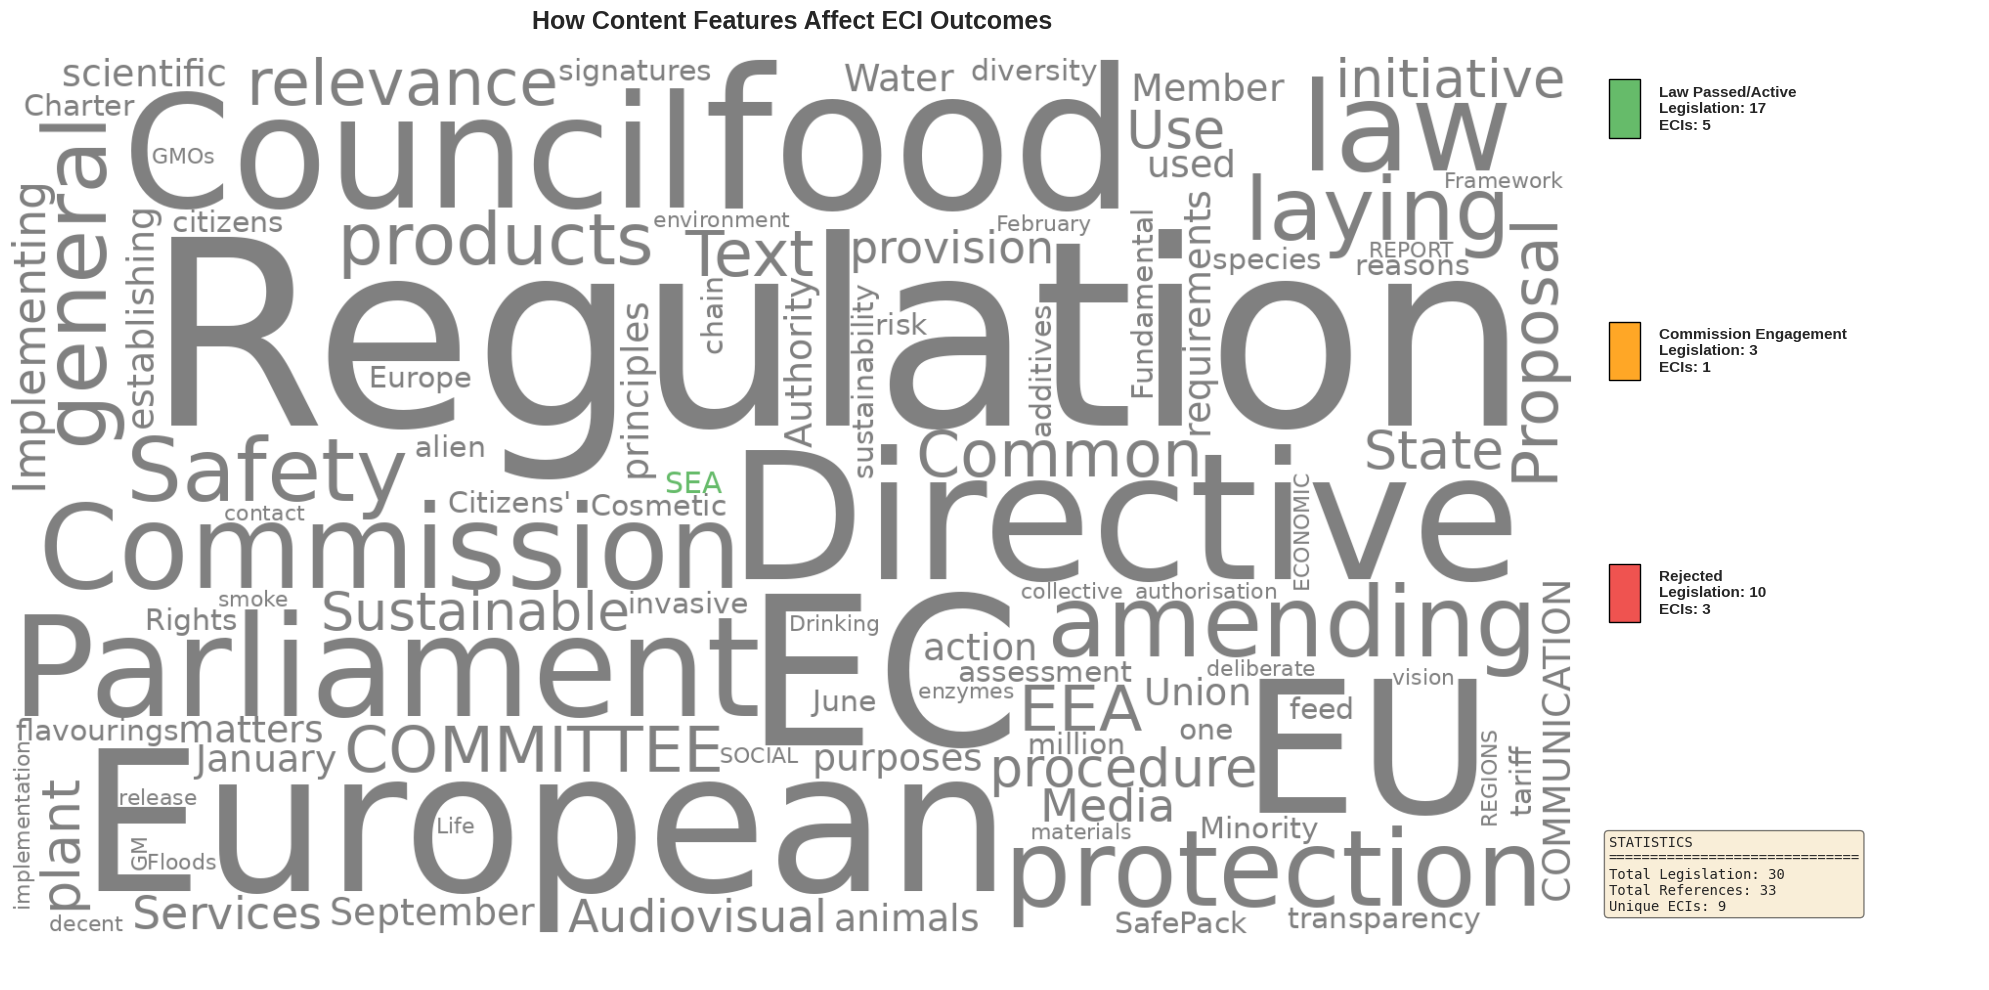


VISUALIZATION COMPLETE

LEGISLATION REFERENCE STATISTICS

Top 15 Most Referenced Legislation Across ECIs:

 1. [Law Passed/Active   ] References:   2 | Regulation (EC) No 178/2002 of the European Parliament and of the Coun
 2. [Law Passed/Active   ] References:   2 | SEA
 3. [Rejected            ] References:   2 | Charter of Fundamental Rights
 4. [Law Passed/Active   ] References:   1 | COMMUNICATION FROM THE COMMISSION TO THE EUROPEAN PARLIAMENT, THE COUN
 5. [Rejected            ] References:   1 | Audiovisual Media Services Directive
 6. [Law Passed/Active   ] References:   1 | Invasive Alien Species Regulation
 7. [Law Passed/Active   ] References:   1 | Commission Implementing Regulation (EU) 2025/1422 of 17 July 2025 amen
 8. [Commission Engagement] References:   1 | REACH Regulation
 9. [Commission Engagement] References:   1 | EU Cosmetics Regulation
10. [Commission Engagement] References:   1 | Cosmetic Products Regulation
11. [Law Passed/Active   ] References:   1 | Commis

In [18]:
# ===============================================================================
# COMPLETE WORD CLOUD ANALYSIS: FROM DATA TO VISUALIZATION
# ===============================================================================
# Objective: Analyze how referenced legislation content affects ECI outcomes
# Output: Word cloud visualization colored by outcome category
# ===============================================================================

import pandas as pd
import json
import ast
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import matplotlib.font_manager as fm
from pathlib import Path
from collections import Counter

# ===============================================================================
# STEP 1: LOAD DATA
# ===============================================================================

# Load legislation titles reference data
legislation_titles = pd.read_csv('legislation_titles.csv')

# Load ECI responses data
df_responses = pd.read_csv('df_responses_enriched.csv')

print("=" * 80)
print("DATA LOADED")
print("=" * 80)
print(f"Legislation titles: {len(legislation_titles)} records")
print(f"ECI responses: {len(df_responses)} records")

# ===============================================================================
# STEP 2: OUTCOME MAPPING
# ===============================================================================

def map_outcome_to_category(outcome_status):
    """
    Map final_outcome values to standardized categories for word cloud coloring.
    
    Categories:
    - Commission Engagement: Law Promised, Action Plan Created, Being Studied
    - Law Passed/Active: Law Active, Law Passed
    - Rejected: All rejection types
    """
    if pd.isna(outcome_status):
        return None
    
    outcome_str = str(outcome_status)
    
    # Commission Engagement
    if any(x in outcome_str for x in ['Law Promised', 'Action Plan', 'Being Studied']):
        return 'Commission Engagement'
    
    # Law Passed/Active
    elif any(x in outcome_str for x in ['Law Active', 'Law Passed']):
        return 'Law Passed/Active'
    
    # Rejected
    elif 'Rejected' in outcome_str:
        return 'Rejected'
    
    return None

# ===============================================================================
# STEP 3: LEGISLATION REFERENCE EXTRACTION
# ===============================================================================

def extract_legislation_ids(referenced_leg_json):
    """
    Extract all legislation identifiers from referenced_legislation_by_id field.
    Handles nested dictionary structure with "Directive" and "CELEX" keys.
    """
    if pd.isna(referenced_leg_json) or referenced_leg_json == '':
        return set()
    
    ids = set()
    
    try:
        if isinstance(referenced_leg_json, str):
            leg_data = ast.literal_eval(referenced_leg_json) if referenced_leg_json.strip() else {}
        else:
            leg_data = referenced_leg_json
        
        if isinstance(leg_data, dict):
            for key, value in leg_data.items():
                if isinstance(value, list):
                    ids.update(value)
                elif isinstance(value, str):
                    ids.add(value)
        elif isinstance(leg_data, str):
            for item in leg_data.split(','):
                item = item.strip()
                if item:
                    ids.add(item)
    except (ValueError, SyntaxError) as e:
        if isinstance(referenced_leg_json, str):
            for item in referenced_leg_json.replace('Directive', '').replace('CELEX', '').split(','):
                item = item.strip()
                if item and item not in ['', '{}', '[]']:
                    ids.add(item)
    
    return ids


def map_ids_to_titles(ids_set, legislation_df):
    """
    Map legislation IDs (natural numbers and CELEX IDs) to full legislation titles.
    """
    titles = []
    
    for leg_id in ids_set:
        if not leg_id or leg_id.strip() == '':
            continue
        
        leg_id_clean = leg_id.strip()
        
        # Try matching by natural_number
        match = legislation_df[legislation_df['natural_number'] == leg_id_clean]
        
        # If not found, try matching by celex_id
        if match.empty:
            match = legislation_df[legislation_df['celex_id'] == leg_id_clean]
        
        # Add title if found
        if not match.empty:
            title = match.iloc[0]['title']
            titles.append(title)
    
    return titles


def extract_named_legislation(referenced_leg_names_json):
    """
    Extract legislation names/titles from referenced_legislation_by_name field.
    """
    if pd.isna(referenced_leg_names_json) or referenced_leg_names_json == '':
        return []
    
    names = []
    
    try:
        if isinstance(referenced_leg_names_json, str):
            leg_data = ast.literal_eval(referenced_leg_names_json) if referenced_leg_names_json.strip() else {}
        else:
            leg_data = referenced_leg_names_json
        
        if isinstance(leg_data, dict):
            for key, value in leg_data.items():
                if isinstance(value, list):
                    names.extend(value)
                elif isinstance(value, str) and value.strip():
                    names.append(value)
        elif isinstance(leg_data, str):
            for item in leg_data.split(','):
                item = item.strip()
                if item and item not in ['', '{}', '[]']:
                    names.append(item)
    except (ValueError, SyntaxError):
        if isinstance(referenced_leg_names_json, str):
            for item in referenced_leg_names_json.split(','):
                item = item.strip()
                if item and item not in ['', '{}', '[]', 'directives', 'regulations', 'charters']:
                    names.append(item)
    
    return names

# ===============================================================================
# STEP 4: PREPARE WORD CLOUD DATA
# ===============================================================================

def prepare_wordcloud_data(df_responses, legislation_titles):
    """
    Prepare complete dataset for word cloud visualization.
    
    Returns: DataFrame with columns:
        - legislation_title: Full title of referenced legislation
        - outcome: Standardized outcome category
        - eci_title: Title of the ECI for reference
    """
    
    wordcloud_records = []
    
    for idx, row in df_responses.iterrows():
        # Map outcome to standardized category
        outcome = map_outcome_to_category(row['final_outcome_status'])
        
        if outcome is None:
            continue
        
        eci_title = row['title']
        
        # Extract and map legislation from IDs
        leg_ids = extract_legislation_ids(row['referenced_legislation_by_id'])
        titles_from_ids = map_ids_to_titles(leg_ids, legislation_titles)
        
        # Extract named legislation
        named_legislation = extract_named_legislation(row['referenced_legislation_by_name'])
        
        # Combine all legislation references
        all_legislation = titles_from_ids + named_legislation
        
        # Create record for each unique legislation reference
        for leg_title in all_legislation:
            if leg_title and leg_title.strip():
                wordcloud_records.append({
                    'legislation_title': leg_title.strip(),
                    'outcome': outcome,
                    'eci_title': eci_title
                })
    
    # Create DataFrame
    df_wordcloud = pd.DataFrame(wordcloud_records)
    
    return df_wordcloud


# Prepare word cloud data
df_wordcloud = prepare_wordcloud_data(df_responses, legislation_titles)

print("\n" + "=" * 80)
print("WORD CLOUD DATA PREPARATION SUMMARY")
print("=" * 80)
print(f"\nTotal legislation references extracted: {len(df_wordcloud)}")
print(f"Unique legislation titles: {df_wordcloud['legislation_title'].nunique()}")
print(f"\nBreakdown by outcome category:")
print(df_wordcloud['outcome'].value_counts())

# ===============================================================================
# STEP 5: FONT DETECTION
# ===============================================================================

def get_system_font():
    """
    Find a valid TrueType font available on the system.
    
    Returns:
        Path to a TrueType font file
    """
    # Common font locations by OS
    font_paths = [
        # Linux
        '/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf',
        '/usr/share/fonts/truetype/liberation/LiberationSans-Regular.ttf',
        '/usr/share/fonts/opentype/noto/NotoSans-Regular.ttf',
        # macOS
        '/Library/Fonts/Arial.ttf',
        '/System/Library/Fonts/Helvetica.ttc',
        # Windows
        'C:\\Windows\\Fonts\\arial.ttf',
    ]
    
    for font_path in font_paths:
        if Path(font_path).exists():
            print(f"✓ Using font: {font_path}")
            return font_path
    
    # Fallback: try to find any TTF font on the system
    try:
        fonts = fm.findSystemFonts()
        ttf_fonts = [f for f in fonts if f.endswith('.ttf')]
        if ttf_fonts:
            print(f"✓ Using font: {ttf_fonts[0]}")
            return ttf_fonts[0]
    except:
        pass
    
    # Last resort
    print("⚠ Using fallback: DejaVuSans")
    return '/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf'

# ===============================================================================
# STEP 6: WORD CLOUD COLOR CONFIGURATION
# ===============================================================================

# Define colors for each outcome category
OUTCOME_COLORS = {
    'Commission Engagement': '#FFA726',  # Orange
    'Law Passed/Active': '#66BB6A',      # Green
    'Rejected': '#EF5350'                # Red
}

def color_func_by_outcome(word, font_size, position, orientation, random_state=None, outcome_map=None):
    """
    Color function that assigns colors based on word's outcome category.
    """
    if outcome_map and word in outcome_map:
        outcome = outcome_map[word]
        return OUTCOME_COLORS.get(outcome, '#808080')
    return '#808080'


def create_outcome_map(df_wordcloud):
    """
    Create a dictionary mapping each legislation title to its outcome.
    Uses the most common outcome if a legislation appears with multiple outcomes.
    """
    outcome_map = {}
    
    for title in df_wordcloud['legislation_title'].unique():
        outcomes = df_wordcloud[df_wordcloud['legislation_title'] == title]['outcome'].value_counts()
        if len(outcomes) > 0:
            outcome_map[title] = outcomes.index[0]
    
    return outcome_map

# ===============================================================================
# STEP 7: WORD CLOUD GENERATION
# ===============================================================================

def generate_wordcloud_by_outcome(df_wordcloud, width=1600, height=900, max_words=100, font_path=None):
    """
    Generate word cloud colored by outcome category.
    """
    
    # Auto-detect font if not provided
    if font_path is None:
        font_path = get_system_font()
    
    # Create outcome map
    outcome_map = create_outcome_map(df_wordcloud)
    
    # Create text with repeated words
    text = ' '.join(df_wordcloud['legislation_title'].tolist())
    
    # Generate word cloud with font specified
    wordcloud = WordCloud(
        width=width,
        height=height,
        background_color='white',
        max_words=max_words,
        relative_scaling=0.5,
        min_font_size=10,
        collocations=False,
        colormap=None,
        font_path=font_path
    )
    
    # Generate and color
    wordcloud.generate(text)
    
    # Apply outcome-based coloring
    # FIX: Accept **kwargs to handle font_path argument from newer wordcloud versions
    wordcloud.recolor(
        color_func=lambda word, font_size, position, orientation, random_state=None, **kwargs: 
                    color_func_by_outcome(word, font_size, position, orientation, random_state, outcome_map)
    )
    
    return wordcloud, outcome_map


def generate_wordclouds_by_outcome_separate(df_wordcloud, width=800, height=600, max_words=80, font_path=None):
    """
    Generate three separate word clouds, one for each outcome category.
    """
    
    # Auto-detect font if not provided
    if font_path is None:
        font_path = get_system_font()
    
    wordclouds = {}
    
    for outcome in ['Law Passed/Active', 'Commission Engagement', 'Rejected']:
        subset = df_wordcloud[df_wordcloud['outcome'] == outcome]
        
        if subset.empty:
            continue
        
        text = ' '.join(subset['legislation_title'].tolist())
        
        # FIX: Create a proper color function that accepts **kwargs
        def make_color_func(color):
            return lambda word, font_size, position, orientation, random_state=None, **kwargs: color
        
        wordcloud = WordCloud(
            width=width,
            height=height,
            background_color='white',
            max_words=max_words,
            relative_scaling=0.5,
            min_font_size=10,
            collocations=False,
            color_func=make_color_func(OUTCOME_COLORS[outcome]),
            font_path=font_path
        )
        
        wordcloud.generate(text)
        wordclouds[outcome] = wordcloud
    
    return wordclouds

# ===============================================================================
# STEP 8: VISUALIZATION
# ===============================================================================

def plot_wordcloud_with_legend(wordcloud, outcome_map, df_wordcloud, title="How Content Features Affect ECI Outcomes"):
    """
    Create a figure with word cloud and outcome legend.
    """
    
    fig, (ax_wc, ax_legend) = plt.subplots(1, 2, figsize=(20, 10), gridspec_kw={'width_ratios': [4, 1]})
    
    # Plot word cloud on left
    ax_wc.imshow(wordcloud, interpolation='bilinear')
    ax_wc.axis('off')
    ax_wc.set_title(title, fontsize=18, fontweight='bold', pad=20)
    
    # Create legend on right
    ax_legend.axis('off')
    
    # Calculate statistics
    stats_by_outcome = df_wordcloud.groupby('outcome').agg({
        'legislation_title': 'nunique',
        'eci_title': 'nunique'
    }).rename(columns={
        'legislation_title': 'Legislation Count',
        'eci_title': 'ECI Count'
    })
    
    # Create legend
    y_pos = 0.95
    for outcome in ['Law Passed/Active', 'Commission Engagement', 'Rejected']:
        if outcome in stats_by_outcome.index:
            count = stats_by_outcome.loc[outcome, 'Legislation Count']
            eci_count = stats_by_outcome.loc[outcome, 'ECI Count']
            
            # Add colored square and label
            ax_legend.add_patch(plt.Rectangle((0.05, y_pos - 0.08), 0.08, 0.06, 
                                             facecolor=OUTCOME_COLORS[outcome], 
                                             edgecolor='black', linewidth=1))
            
            ax_legend.text(0.18, y_pos - 0.05, f'{outcome}\n'
                                              f'Legislation: {count}\n'
                                              f'ECIs: {eci_count}',
                          fontsize=11, fontweight='bold',
                          verticalalignment='center')
            y_pos -= 0.25
    
    # Add statistics box
    ax_legend.text(0.05, 0.15, 
                  f"STATISTICS\n"
                  f"{'=' * 30}\n"
                  f"Total Legislation: {len(outcome_map)}\n"
                  f"Total References: {len(df_wordcloud)}\n"
                  f"Unique ECIs: {df_wordcloud['eci_title'].nunique()}",
                  fontsize=10, verticalalignment='top',
                  bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
                  family='monospace')
    
    ax_legend.set_xlim(0, 1)
    ax_legend.set_ylim(0, 1)
    
    plt.tight_layout()
    
    return fig


def plot_wordclouds_grid(wordclouds_dict, figsize=(18, 12)):
    """
    Plot word clouds in a 3-panel grid layout.
    """
    
    fig, axes = plt.subplots(1, 3, figsize=figsize)
    fig.suptitle('Legislation Content Features by ECI Outcome Category', 
                 fontsize=16, fontweight='bold', y=0.98)
    
    outcomes = ['Law Passed/Active', 'Commission Engagement', 'Rejected']
    
    for idx, (ax, outcome) in enumerate(zip(axes, outcomes)):
        if outcome in wordclouds_dict:
            ax.imshow(wordclouds_dict[outcome], interpolation='bilinear')
            ax.set_title(f'{outcome}\n({len(wordclouds_dict[outcome].words_)} words)',
                        fontsize=13, fontweight='bold', pad=10,
                        color=OUTCOME_COLORS[outcome])
        ax.axis('off')
    
    plt.tight_layout()
    return fig


def print_legislation_statistics(df_wordcloud):
    """
    Print detailed statistics about referenced legislation.
    """
    print("\n" + "=" * 80)
    print("LEGISLATION REFERENCE STATISTICS")
    print("=" * 80)
    
    # Frequency of each legislation title
    leg_frequency = df_wordcloud['legislation_title'].value_counts()
    
    print(f"\nTop 15 Most Referenced Legislation Across ECIs:\n")
    for rank, (leg_title, count) in enumerate(leg_frequency.head(15).items(), 1):
        outcomes = df_wordcloud[df_wordcloud['legislation_title'] == leg_title]['outcome'].value_counts()
        primary_outcome = outcomes.index[0]
        print(f"{rank:2d}. [{primary_outcome:20s}] References: {count:3d} | {leg_title[:70]}")
    
    # Breakdown by outcome
    print(f"\n\nBreakdown by Outcome Category:\n")
    outcome_stats = df_wordcloud.groupby('outcome').agg({
        'legislation_title': 'count',
        'eci_title': 'nunique'
    }).rename(columns={'legislation_title': 'References', 'eci_title': 'Unique ECIs'})
    
    print(outcome_stats.to_string())
    print("\n" + "=" * 80)


def main_render_wordcloud(df_wordcloud, output_path=None, separate_clouds=False):
    """
    Main function to render word cloud visualization.
    """
    
    print("\n" + "=" * 80)
    print("WORD CLOUD VISUALIZATION")
    print("=" * 80)
    
    if separate_clouds:
        print("\nGenerating separate word clouds by outcome category...")
        wordclouds_dict = generate_wordclouds_by_outcome_separate(df_wordcloud)
        fig = plot_wordclouds_grid(wordclouds_dict)
        
    else:
        print("\nGenerating combined word cloud with outcome-based coloring...")
        wordcloud, outcome_map = generate_wordcloud_by_outcome(df_wordcloud)
        fig = plot_wordcloud_with_legend(wordcloud, outcome_map, df_wordcloud)
    
    # Save figure if path provided
    if output_path:
        fig.savefig(output_path, dpi=300, bbox_inches='tight')
        print(f"\n✓ Figure saved to: {output_path}")
    
    plt.tight_layout()
    plt.show()
    
    print("\n" + "=" * 80)
    print("VISUALIZATION COMPLETE")
    print("=" * 80)
    
    return fig

# ===============================================================================
# STEP 9: EXECUTE
# ===============================================================================

# Option 1: Combined cloud with legend (recommended for Jupyter)
fig = main_render_wordcloud(df_wordcloud, 
                            output_path=None,
                            separate_clouds=False)

# Option 2: Three separate clouds (uncomment to use)
# fig = main_render_wordcloud(df_wordcloud, 
#                             output_path=None,
#                             separate_clouds=True)

# Print statistics
print_legislation_statistics(df_wordcloud)


In [19]:
df_responses_enriched.columns

Index(['response_url', 'initiative_url', 'initiative_title',
       'registration_number', 'submission_text', 'commission_submission_date',
       'submission_news_url', 'commission_meeting_date',
       'commission_officials_met', 'parliament_hearing_date',
       'parliament_hearing_video_urls', 'plenary_debate_date',
       'plenary_debate_video_urls', 'official_communication_adoption_date',
       'official_communication_document_urls', 'commission_answer_text',
       'final_outcome_status', 'law_implementation_date',
       'commission_promised_new_law', 'commission_deadlines',
       'commission_rejected_initiative', 'commission_rejection_reason',
       'laws_actions', 'policies_actions', 'has_followup_section',
       'has_roadmap', 'has_workshop', 'has_partnership_programs',
       'court_cases_referenced', 'followup_latest_date',
       'followup_most_future_date', 'commission_factsheet_url',
       'followup_dedicated_website', 'referenced_legislation_by_id',
       'refere

In [20]:
df_responses_enriched[['referenced_legislation_by_id', 'referenced_legislation_by_id', 'final_outcome']].sample(3)

,referenced_legislation_by_id,referenced_legislation_by_id,final_outcome
0,"{""Article"": [""19(2)""], ""CELEX"": [""52014DC0335""], ""official_journal"": {""legislation"": [""2015, 260""]}}","{""Article"": [""19(2)""], ""CELEX"": [""52014DC0335""], ""official_journal"": {""legislation"": [""2015, 260""]}}",Commission Response
2,"{""Directive"": [""2010/63/EU""], ""CELEX"": [""52020DC0015""]}","{""Directive"": [""2010/63/EU""], ""CELEX"": [""52020DC0015""]}",Commission Response
1,NaN,NaN,Commission Response


In [21]:
legislation_titles = pd.read_csv("legislation_titles.csv")
legislation_titles.columns

Index(['celex_id', 'legislation_type', 'natural_number', 'lang', 'title'], dtype='object')

In [22]:
legislation_titles.head()

,celex_id,legislation_type,natural_number,lang,title
0,32010L0013,Directive,2010/13/EU,en,"Directive 2010/13/EU of the European Parliament and of the Council of 10 March 2010 on the coordination of certain provisions laid down by law, regulation or administrative action in Member States concerning the provision of audiovisual media services (Audiovisual Media Services Directive) (Codified version) (Text with EEA relevance)"
1,32010L0063,Directive,2010/63/EU,en,Directive 2010/63/EU of the European Parliament and of the Council of 22 September 2010 on the protection of animals used for scientific purposes Text with EEA relevance
2,52014DC0335,Communication (Commission),COM(2014) 335,en,"COMMUNICATION FROM THE COMMISSION TO THE EUROPEAN PARLIAMENT, THE COUNCIL, THE EUROPEAN ECONOMIC AND SOCIAL COMMITTEE AND THE COMMITTEE OF THE REGIONS A decent Life for all: from vision to collective action"
3,32002R0178,Regulation,178/2002,en,"Regulation (EC) No 178/2002 of the European Parliament and of the Council of 28 January 2002 laying down the general principles and requirements of food law, establishing the European Food Safety Authority and laying down procedures in matters of food safety"
4,52018PC0179,Proposal (Commission),COM(2018) 179,en,"Proposal for a REGULATION OF THE EUROPEAN PARLIAMENT AND OF THE COUNCIL on the transparency and sustainability of the EU risk assessment in the food chain amending Regulation (EC) No 178/2002 [on general food law], Directive 2001/18/EC [on the deliberate release into the environment of GMOs], Regulation (EC) No 1829/2003 [on GM food and feed], Regulation (EC) No 1831/2003 [on feed additives], Regulation (EC) No 2065/2003 [on smoke flavourings], Regulation (EC) No 1935/2004 [on food contact materials], Regulation (EC) No 1331/2008 [on the common authorisation procedure for food additives, food enzymes and food flavourings], Regulation (EC) No 1107/2009 [on plant protection products] and Regulation (EU) No 2015/2283 [on novel foods]"


In [23]:
df_responses_enriched["referenced_legislation_by_id"].to_list()

['{"Article": ["19(2)"], "CELEX": ["52014DC0335"], "official_journal": {"legislation": ["2015, 260"]}}',
 nan,
 '{"Directive": ["2010/63/EU"], "CELEX": ["52020DC0015"]}',
 '{"CELEX": ["52018PC0179", "32002R0178", "32019R1381"]}',
 '{"Directive": ["2010/13/EU"], "CELEX": ["62023CJ0026"]}',
 nan,
 '{"Article": ["15"]}',
 '{"CELEX": ["52022PC0305"]}',
 '{"CELEX": ["32024R2522"]}',
 nan,
 '{"Regulation": ["178/2002"], "Article": ["31", "29"], "CELEX": ["32025R1422"]}']

In [24]:
df_responses_enriched.to_csv("df_responses_enriched.csv")

In [25]:
# Check what outcome categories exist in the filtered data
print("Outcome categories present:")
print(df_filtered['outcome_category'].value_counts())


Outcome categories present:
Law Passed/Active        5
Waiting for Response     5
Rejected                 4
Commission Engagement    2
Name: outcome_category, dtype: int64


<a id='question-7'></a>
## <p style="padding:10px;background-color:#fff798;margin:0;color:#435672;font-family:newtimesroman;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500">7. What Commission engagement patterns predict implementation success?</p>

**Visualizations:**

- Grouped bar: Commission official roles met vs outcomes
- Comparison bar: Deadline presence vs law implementation rate
- Multi-panel: Follow-up activity profile by outcome
- Stacked bar: Roadmaps/workshops vs implementation

In [26]:
# Check what outcome categories exist in the filtered data
print("Outcome categories present:")
print(df_filtered['outcome_category'].value_counts())


Outcome categories present:
Law Passed/Active        5
Waiting for Response     5
Rejected                 4
Commission Engagement    2
Name: outcome_category, dtype: int64


<a id='question-8'></a>
## <p style="padding:10px;background-color:#fff798;margin:0;color:#435672;font-family:newtimesroman;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500">8. What commission response mechanisms characterize different outcomes?</p>

**Visualizations:**

- Box plot: Number of referenced legislation pieces by outcome
- Bar: Impact assessment presence vs outcomes
- Stacked bar: Stakeholder dialogue frequency
- Small multiples: Court cases presence and outcomes

In [27]:
# Q9 Analysis Code
# Referenced legislation
if 'referenced_legislation_by_name' in df_responses.columns:
    def count_referenced_legislation(ref_json):
        try:
            data = json.loads(ref_json)
            count = 0
            for category, items in data.items():
                if isinstance(items, list):
                    count += len(items)
                elif isinstance(items, dict):
                    count += len(items)
            return count
        except:
            return 0
    
    df_responses['referenced_leg_count'] = df_responses['referenced_legislation_by_name'].apply(count_referenced_legislation)
    
    leg_by_outcome = df_responses.groupby('final_outcome_status')['referenced_leg_count'].agg([
        ('count', 'count'),
        ('mean', 'mean'),
        ('median', 'median')
    ]).round(1)
    
    print("Referenced Legislation by Outcome:")
    print(leg_by_outcome)

# Impact assessments and stakeholder dialogue
if 'policies_actions' in df_responses.columns:
    def has_impact_assessment(actions_json):
        try:
            data = json.loads(actions_json)
            return any('impact assessment' in str(action).lower() for action in data)
        except:
            return False
    
    df_responses['has_assessment'] = df_responses['policies_actions'].apply(has_impact_assessment)
    
    assessment_by_outcome = df_responses.groupby('final_outcome_status')['has_assessment'].agg([
        ('count', 'count'),
        ('assessments', 'sum')
    ])
    
    print("\nImpact Assessments by Outcome:")
    print(assessment_by_outcome)

# Court cases
if 'court_cases_referenced' in df_responses.columns:
    has_court = df_responses['court_cases_referenced'].notna().sum()
    print(f"\nECIs with court cases referenced: {has_court}/{len(df_responses)}")

Referenced Legislation by Outcome:
                                count  mean  median
final_outcome_status                               
Action Plan Created                 1   3.0     3.0
Law Active                          4   2.2     2.5
Law Passed                          1   2.0     2.0
Law Promised                        1   0.0     0.0
Rejected - Already Covered          3   2.0     2.0
Rejected - Alternative Actions      1   1.0     1.0

Impact Assessments by Outcome:
                                count  assessments
final_outcome_status                              
Action Plan Created                 1            0
Law Active                          4            2
Law Passed                          1            1
Law Promised                        1            1
Rejected - Already Covered          3            0
Rejected - Alternative Actions      1            0

ECIs with court cases referenced: 2/11


<a id='question-1'></a>
## <p style="padding:10px;background-color:#fff798;margin:0;color:#435672;font-family:newtimesroman;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500">9. What Are the Key Findings?</p>

**Summary Analysis (Descriptive Only):**

- Simple comparisons: means, medians, distributions
- Correlation matrices: relationships between key variables
- Visual profiles: radar charts, parallel coordinates
- Key factors: distinguish successful from unsuccessful ECIs
- ⚠️ NO PREDICTIONS: Purely exploratory analysis

In [28]:
# # Q10 Analysis Code
# # Overall success rate
# overall_success_rate = (df_initiatives['collection_accepted'].sum() / len(df_initiatives)) * 100
# print(f"Overall ECI Success Rate: {overall_success_rate:.1f}%")

# # Comparative profile
# profile_comparison = df_initiatives.groupby('collection_accepted').agg({
#     'signatures_collected': ['mean', 'median'],
#     'collection_days': ['mean', 'median'],
#     'countries_threshold_met': 'mean',
#     'organizer_count': 'mean',
#     'language_count': 'mean',
#     'funding_total': ['mean', 'median']
# }).round(1)

# profile_comparison.index = ['Unsuccessful', 'Successful']

# print("\nSuccessful vs Unsuccessful ECI Profile Comparison:")
# print(profile_comparison)

# # Key distinguishing factors - FIX HERE
# numeric_cols = df_initiatives.select_dtypes(include=[np.number]).columns.tolist()
# # Filter columns with enough non-null data
# numeric_cols = [col for col in numeric_cols if df_initiatives[col].notna().sum() > 10]

# if numeric_cols and 'collection_accepted' in df_initiatives.columns:
#     try:
#         # Compute correlation matrix
#         corr_data = df_initiatives[numeric_cols + ['collection_accepted']].copy()
#         # Drop columns that are all NaN or have no variance
#         corr_data = corr_data.loc[:, corr_data.notna().sum() > 10]
        
#         correlation_matrix = corr_data.corr()
        
#         if 'collection_accepted' in correlation_matrix.columns:
#             correlation = correlation_matrix['collection_accepted'].drop('collection_accepted').sort_values(ascending=False)
#             print("\nTop Factors Correlated with Success:")
#             print(correlation.head(10))
#     except Exception as e:
#         print(f"\nCorrelation analysis skipped: {e}")

# # Outcome distribution in successful ECIs
# if 'df_responses' in locals() and len(df_responses) > 0:
#     print("\nCommission Outcome Distribution (for successful ECIs):")
#     print(df_responses['final_outcome_status'].value_counts())
    
#     # Implementation rate
#     impl_rate = df_responses['law_implementation_date'].notna().sum() / len(df_responses) * 100
#     print(f"\nLaw Implementation Rate: {impl_rate:.1f}%")